## Imports

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

In [2]:
frameList = []
video = cv2.VideoCapture('kamera roof.mp4')
cap = video
while(cap.isOpened()):
      
  # Capture frame-by-frame
  ret, img = cap.read()
  try:
      frame = Pipeline(img)
  except:
      frame = img
    
  if ret == True:
    # Display the resulting frame
    cv2.imshow('Frame', frame)
    frameList.append(frame)
   
    # Press Q on keyboard to  exit
    if cv2.waitKey(10) & 0xFF == ord('q'):
      break
  
  # Break the loop
  else: 
    break

# When everything done, release 
# the video capture object
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

## Camera calibration using chessboard images

In [3]:
def calibrate():
    # Create object points (0 0 0) ... (8 5 0)
    objp = np.zeros((9*6, 3), np.float32) 
    
    # assign grid points to x and y keeping z as zero
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    # Get directory for all calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    for indx, fname in enumerate(images):
        
        img = cv2.imread(fname)
        
        # Converting to grayclae - findChessboardCorners expects graysclae image
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find inner corners of chess baord
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Save camera matrix and distortion coefficient to pickle file
    
    calibration_param = {}
    calibration_param['mtx'] = mtx
    calibration_param['dist'] = dist
    pickle.dump( calibration_param, open('camera_cal/calibration_pickle.pickle', 'wb') )

In [4]:
calibrate()

## Undistorting image using camera matrix and distortion coefficient

In [5]:
def undistort_img(img, cal_dir = 'camera_cal/calibration_pickle.pickle'):
    
    # Read saved file
    with open(cal_dir, mode = 'rb') as f:
        file = pickle.load(f)
        
    mtx = file['mtx'] # camera matrix
    dist = file['dist'] # Distortion coefficients
    
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted_img

## Thresholding - Color thresholding and Gradient thresholding

In [8]:
def img_threshold(img, s_thresh=(110, 161), sx_thresh=(150, 255)): 
    
    undistorted_img = img
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    s_channel = hls[:, :, 1] 
    

    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

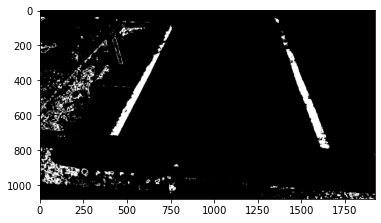

In [9]:
plt.imshow(img_threshold(frameList[0]),cmap ='gray')

## Perspective and Inverse perspective transform

In [12]:
a = [0,367]
b = [1920,367]
c = [0,695]
d = [1919,695]

In [13]:
def perspective_transform(img):
    
    src = np.float32([a,b,c,d])
    dst = np.float32([ [0, 0], [img.shape[1], 0], [0, img.shape[0]], [img.shape[1], img.shape[0]]])
    
    img_size = (img.shape[1],img.shape[0])

    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

def inv_perspective_transform(img):
    
    dst = np.float32([a,b,c,d])
    src = np.float32([ [0, 0], [img.shape[1], 0], [0, img.shape[0]], [img.shape[1], img.shape[0]]])
    
    img_size = (img.shape[1],img.shape[0])

    # Given src and dst points, calculate the inverse-perspective transform matrix 
    #(which is just perspective transform with src and dst interchanged)
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

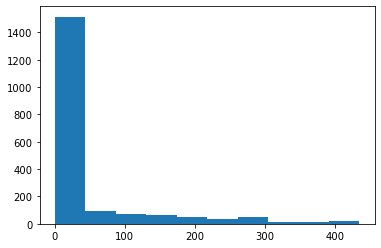

In [19]:
plt.hist(get_hist(perspective_transform(img_threshold(frameList[0]))))
plt.show()

# Helper functions

In [8]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = get_hist(binary_warped)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 200

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # the four boundaries of the window ###
        win_xleft_low   = leftx_current - margin
        win_xleft_high  = leftx_current + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # if the no of pixels in the current window > minpix then update window center
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

In [9]:
def fit_poly(leftx, lefty, rightx, righty):
    """
    Given x and y coordinates of lane pixels fir 2nd order polynomial through them
    
    here the function is of y and not x that is
    
    x = f(y) = Ay**2 + By + C
    
    returns coefficients A, B, C for each lane (left lane and right lane)
    """
    # Fit a second order polynomial to each with np.polyfit()
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
    except:
        left_fit = [-0.0000180364915, -0.160192300,  675.742079e+02]
    try:
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        right_fit = [ 0.0557572589, -120.552486, 67073.9181]
    print(left_fit)


    return left_fit, right_fit

In [10]:
def search_around_poly(binary_warped, left_fit, right_fit):
    """
    This function is extension to function find_lane_pixels().
    
    From second frame onwards of the video this function will be run.
    
    the idea is that we dont have to re-run window search for each and every frame.
    
    once we know where the lanes are, we can make educated guess about the position of lanes in the consecutive frame,
    
    because lane lines are continuous and dont change much from frame to frame(unless a very abruspt sharp turn).
    
    This function takes in the fitted polynomial from previous frame defines a margin and looks for non zero pixels 
    in that range only. it greatly increases the speed of the detection.
    """
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # we have left fitted polynomial (left_fit) and right fitted polynomial (right_fit) from previous frame,
    # using these polynomial and y coordinates of non zero pixels from warped image, 
    # we calculate corrsponding x coordinate and check if lies within margin, if it does then
    # then we count that pixel as being one from the lane lines.
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin))).nonzero()[0]
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin))).nonzero()[0]
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx = fit_poly(leftx, lefty, rightx, righty)

    return leftx, lefty, rightx, righty

In [11]:
def measure_curvature_real(left_fit_cr, right_fit_cr, img_shape):
    '''
    Calculates the curvature of polynomial functions in meters.
    and returns the position of vehical relative to the center of the lane
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = img_shape[0]
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # It was meentioned in one the course note that camera was mounted in the middle of the car,
    # so the postiion of the car is middle of the image, the we calculate the middle of lane using
    # two fitted polynomials
    car_pos = img_shape[1]/2
    left_lane_bottom_x = left_fit_cr[0]*img_shape[0]**2 + left_fit_cr[1]*img_shape[0] + left_fit_cr[2]
    right_lane_bottom_x = right_fit_cr[0]*img_shape[0]**2 + right_fit_cr[1]*img_shape[0] + right_fit_cr[2]
    lane_center_position = ((right_lane_bottom_x - left_lane_bottom_x) / 2) + left_lane_bottom_x
    car_center_offset = np.abs(car_pos - lane_center_position) * xm_per_pix
    
    return (left_curverad, right_curverad, car_center_offset)

In [12]:
def draw_lane(warped_img, undistorted_img, left_fit, right_fit):
    """
    Given warped image and original undistorted original image this function 
    draws final lane on the undistorted image
    """
    # Generate x and y values for plotting
    ploty = np.linspace(0, undistorted_img.shape[0]-1, undistorted_img.shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = inv_perspective_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    return result

# Final pipeline

For the first frame `find_lane_pixels()` function is called then from second frame onwards `search_around_poly()` is called.

In [13]:
first_run = True
gleft_fit = gright_fit = None

def Pipeline(img):
    global first_run, gleft_fit, gright_fit
    
    
    threshold_img, undistorted_img = img_threshold(img)
    
    warped_img = perspective_transform(threshold_img)
    
    if first_run:
        leftx, lefty, rightx, righty = find_lane_pixels(warped_img)
        left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
        gleft_fit = left_fit
        gright_fit = right_fit
        first_run = False
    else:
        leftx, lefty, rightx, righty = search_around_poly(warped_img, gleft_fit, gright_fit)
        left_fit, right_fit = fit_poly(leftx, lefty, rightx, righty)
        gleft_fit = left_fit
        gright_fit = right_fit
    
    #print(left_fitx, right_fitx)
    measures = measure_curvature_real(left_fit, right_fit, img_shape = img.shape )

    final_img = draw_lane(warped_img, undistorted_img, left_fit, right_fit)
    cv2.circle(final_img, (a[0], a[1]), 5, (0, 0, 255), -1) # top left
    cv2.circle(final_img, (b[0], b[1]), 5, (0, 0, 255), -1) # top right
    cv2.circle(final_img, (c[0], c[1]), 5, (0, 0, 255), -1) # bottom left
    cv2.circle(final_img, (d[0], d[1]), 5, (0, 0, 255), -1) # bottom right
    
    # writing lane curvature and vehical offset on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (0, 0, 0)
    fontSize = 1
    cv2.putText(final_img, 'Lane Curvature: {:.0f} m'.format(np.mean([measures[0],measures[1]])), 
                (500, 620), font, fontSize, fontColor, 2)
    cv2.putText(final_img, 'Vehicle offset: {:.4f} m'.format(measures[2]), (500, 650), font, fontSize, fontColor, 2)
    
    return final_img

# Testing Images

In [14]:
from moviepy.editor import VideoFileClip
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

first_run = True
gleft_fit = gright_fit = None

myclip = VideoFileClip('kamera roof.mp4')

output_vid = 'gopro_output.mp4'
clip = myclip.fl_image(Pipeline)
n_frames = (1 for x in clip.iter_frames())
print(n_frames)
clip.write_videofile(output_vid, audio=False)
myclip.reader.close()
myclip.close()

[ 4.99191889e-06 -1.65980390e-01  6.09416942e+02]
<generator object <genexpr> at 0x7fea9af2c430>
Moviepy - Building video gopro_output.mp4.
Moviepy - Writing video gopro_output.mp4



t:   0%|                                     | 0/2283 [00:00<?, ?it/s, now=None]

[ 5.00114511e-06 -1.66058265e-01  6.09476476e+02]
[ 5.00114511e-06 -1.66058265e-01  6.09476476e+02]


t:   0%|                             | 3/2283 [00:00<02:10, 17.51it/s, now=None]

[-1.05718129e-06 -1.60463124e-01  6.09065946e+02]
[-1.05718129e-06 -1.60463124e-01  6.09065946e+02]
[ 3.93199491e-06 -1.65906486e-01  6.09575520e+02]
[ 3.93199491e-06 -1.65906486e-01  6.09575520e+02]


t:   0%|                             | 5/2283 [00:00<02:18, 16.44it/s, now=None]

[ 1.23485430e-06 -1.62381661e-01  6.09263457e+02]
[ 1.23485430e-06 -1.62381661e-01  6.09263457e+02]
[ 1.05735779e-05 -1.70912780e-01  6.10302668e+02]


t:   0%|                             | 7/2283 [00:00<02:25, 15.68it/s, now=None]

[ 1.05735779e-05 -1.70912780e-01  6.10302668e+02]
[ 3.10682572e-06 -1.63783120e-01  6.08849947e+02]
[ 3.10682572e-06 -1.63783120e-01  6.08849947e+02]
[-3.61176409e-06 -1.57552532e-01  6.08533303e+02]
[-3.61176409e-06 -1.57552532e-01  6.08533303e+02]
[-1.01563231e-07 -1.60041927e-01  6.08312853e+02]
[-1.01563231e-07 -1.60041927e-01  6.08312853e+02]


t:   0%|                             | 9/2283 [00:00<02:24, 15.78it/s, now=None]

[ 2.95179290e-06 -1.64436188e-01  6.09510325e+02]
[ 2.95179290e-06 -1.64436188e-01  6.09510325e+02]
[ 3.51858642e-06 -1.65401374e-01  6.09601876e+02]
[ 3.51858642e-06 -1.65401374e-01  6.09601876e+02]


t:   0%|▏                           | 11/2283 [00:00<02:25, 15.63it/s, now=None]

[ 8.66546236e-08 -1.62074598e-01  6.09457729e+02]
[ 8.66546236e-08 -1.62074598e-01  6.09457729e+02]
[-3.24862281e-07 -1.62151217e-01  6.09355488e+02]
[-3.24862281e-07 -1.62151217e-01  6.09355488e+02]


t:   1%|▏                           | 13/2283 [00:00<02:25, 15.61it/s, now=None]

[ 7.85118201e-06 -1.68456251e-01  6.10242707e+02]
[ 7.85118201e-06 -1.68456251e-01  6.10242707e+02]
[ 2.50322065e-06 -1.63677982e-01  6.09072928e+02]
[ 2.50322065e-06 -1.63677982e-01  6.09072928e+02]


t:   1%|▏                           | 15/2283 [00:00<02:24, 15.73it/s, now=None]

[ 7.83044894e-06 -1.68353894e-01  6.10068919e+02]
[ 7.83044894e-06 -1.68353894e-01  6.10068919e+02]
[-4.38561792e-07 -1.62190681e-01  6.09582271e+02]
[-4.38561792e-07 -1.62190681e-01  6.09582271e+02]


t:   1%|▏                           | 17/2283 [00:01<02:23, 15.84it/s, now=None]

[-1.37661831e-06 -1.60618794e-01  6.09210944e+02]
[-1.37661831e-06 -1.60618794e-01  6.09210944e+02]
[ 7.38589016e-07 -1.61570331e-01  6.08869031e+02]
[ 7.38589016e-07 -1.61570331e-01  6.08869031e+02]


t:   1%|▏                           | 19/2283 [00:01<02:25, 15.54it/s, now=None]

[-3.26105789e-06 -1.58505700e-01  6.08700098e+02]
[-3.26105789e-06 -1.58505700e-01  6.08700098e+02]


t:   1%|▎                           | 21/2283 [00:01<02:29, 15.14it/s, now=None]

[ 2.60456559e-06 -1.62630899e-01  6.08668593e+02]
[ 2.60456559e-06 -1.62630899e-01  6.08668593e+02]
[ 1.83673877e-06 -1.63287437e-01  6.09070298e+02]
[ 1.83673877e-06 -1.63287437e-01  6.09070298e+02]
[ 1.49108449e-06 -1.63590994e-01  6.09821490e+02]


t:   1%|▎                           | 23/2283 [00:01<02:28, 15.24it/s, now=None]

[ 1.49108449e-06 -1.63590994e-01  6.09821490e+02]
[ 8.98668810e-06 -1.68688993e-01  6.09606079e+02]


t:   1%|▎                           | 25/2283 [00:01<02:28, 15.16it/s, now=None]

[ 8.98668810e-06 -1.68688993e-01  6.09606079e+02]
[ 2.68810807e-06 -1.63440124e-01  6.09025784e+02]
[ 2.68810807e-06 -1.63440124e-01  6.09025784e+02]
[ 9.70514215e-07 -1.62202971e-01  6.09048134e+02]
[ 9.70514215e-07 -1.62202971e-01  6.09048134e+02]
[ 7.45681119e-06 -1.68532361e-01  6.09911659e+02]


t:   1%|▎                           | 29/2283 [00:01<02:29, 15.10it/s, now=None]

[ 7.45681119e-06 -1.68532361e-01  6.09911659e+02]
[ 1.22101024e-06 -1.63097846e-01  6.09235390e+02]
[ 1.22101024e-06 -1.63097846e-01  6.09235390e+02]
[-2.09851821e-06 -1.59861156e-01  6.09052034e+02]
[-2.09851821e-06 -1.59861156e-01  6.09052034e+02]
[ 6.17912259e-07 -1.62639148e-01  6.09268047e+02]
[ 6.17912259e-07 -1.62639148e-01  6.09268047e+02]


t:   1%|▍                           | 31/2283 [00:02<02:28, 15.22it/s, now=None]

[ 3.54672787e-07 -1.61925498e-01  6.08934943e+02]
[ 3.54672787e-07 -1.61925498e-01  6.08934943e+02]
[ 7.88812244e-06 -1.69265638e-01  6.10481190e+02]
[ 7.88812244e-06 -1.69265638e-01  6.10481190e+02]
[ 4.50874133e-06 -1.65049404e-01  6.09240047e+02]
[ 4.50874133e-06 -1.65049404e-01  6.09240047e+02]


t:   1%|▍                           | 33/2283 [00:02<02:26, 15.36it/s, now=None]

[-1.77685965e-07 -1.60405820e-01  6.08405051e+02]
[-1.77685965e-07 -1.60405820e-01  6.08405051e+02]


t:   2%|▍                           | 35/2283 [00:02<02:24, 15.53it/s, now=None]

[ 3.43380644e-06 -1.65118082e-01  6.09558303e+02]
[ 3.43380644e-06 -1.65118082e-01  6.09558303e+02]
[ 2.12535213e-06 -1.63775711e-01  6.09237655e+02]
[ 2.12535213e-06 -1.63775711e-01  6.09237655e+02]
[ 2.37994665e-06 -1.64007228e-01  6.08964591e+02]
[ 2.37994665e-06 -1.64007228e-01  6.08964591e+02]


t:   2%|▍                           | 37/2283 [00:02<02:23, 15.65it/s, now=None]

[ 4.26702974e-06 -1.65915887e-01  6.09442174e+02]
[ 4.26702974e-06 -1.65915887e-01  6.09442174e+02]


t:   2%|▍                           | 39/2283 [00:02<02:23, 15.66it/s, now=None]

[-1.72083106e-07 -1.61833437e-01  6.09013175e+02]
[-1.72083106e-07 -1.61833437e-01  6.09013175e+02]
[ 7.84592739e-06 -1.67783072e-01  6.09760514e+02]
[ 7.84592739e-06 -1.67783072e-01  6.09760514e+02]
[ 1.32883267e-05 -1.72712593e-01  6.10597999e+02]
[ 1.32883267e-05 -1.72712593e-01  6.10597999e+02]


t:   2%|▌                           | 41/2283 [00:02<02:23, 15.61it/s, now=None]

[ 1.11690249e-05 -1.71057941e-01  6.09761244e+02]
[ 1.11690249e-05 -1.71057941e-01  6.09761244e+02]


t:   2%|▌                           | 43/2283 [00:02<02:23, 15.62it/s, now=None]

[ 4.71537154e-06 -1.66407990e-01  6.09606364e+02]
[ 4.71537154e-06 -1.66407990e-01  6.09606364e+02]
[ 7.54010186e-06 -1.67939825e-01  6.09528574e+02]
[ 7.54010186e-06 -1.67939825e-01  6.09528574e+02]


t:   2%|▌                           | 45/2283 [00:02<02:29, 14.98it/s, now=None]

[ 6.52450979e-06 -1.68025884e-01  6.09666995e+02]
[ 6.52450979e-06 -1.68025884e-01  6.09666995e+02]


t:   2%|▌                           | 47/2283 [00:03<02:34, 14.44it/s, now=None]

[ 5.69995326e-06 -1.67462714e-01  6.09747610e+02]
[ 5.69995326e-06 -1.67462714e-01  6.09747610e+02]
[ 9.15489216e-06 -1.71001303e-01  6.10880512e+02]
[ 9.15489216e-06 -1.71001303e-01  6.10880512e+02]
[ 1.59846939e-06 -1.62140652e-01  6.08923035e+02]
[ 1.59846939e-06 -1.62140652e-01  6.08923035e+02]


t:   2%|▋                           | 51/2283 [00:03<03:14, 11.48it/s, now=None]

[ 2.83184669e-06 -1.64201594e-01  6.09013714e+02]
[ 2.83184669e-06 -1.64201594e-01  6.09013714e+02]
[-5.83166536e-07 -1.60771632e-01  6.08579307e+02]
[-5.83166536e-07 -1.60771632e-01  6.08579307e+02]
[ 1.50444851e-06 -1.62619956e-01  6.08822471e+02]
[ 1.50444851e-06 -1.62619956e-01  6.08822471e+02]


t:   2%|▋                           | 53/2283 [00:03<03:08, 11.85it/s, now=None]

[ 2.79968000e-06 -1.64468436e-01  6.09501268e+02]
[ 2.79968000e-06 -1.64468436e-01  6.09501268e+02]
[ 3.62386347e-06 -1.64496821e-01  6.09245033e+02]
[ 3.62386347e-06 -1.64496821e-01  6.09245033e+02]
[ 2.50683088e-06 -1.64497828e-01  6.09243312e+02]
[ 2.50683088e-06 -1.64497828e-01  6.09243312e+02]


t:   2%|▋                           | 57/2283 [00:03<03:04, 12.09it/s, now=None]

[ 2.15144601e-06 -1.63201834e-01  6.08990430e+02]
[ 2.15144601e-06 -1.63201834e-01  6.08990430e+02]
[ 2.43653092e-07 -1.62204873e-01  6.08951209e+02]
[ 2.43653092e-07 -1.62204873e-01  6.08951209e+02]
[ 5.80884753e-07 -1.62997488e-01  6.09183156e+02]
[ 5.80884753e-07 -1.62997488e-01  6.09183156e+02]


t:   3%|▋                           | 59/2283 [00:04<02:59, 12.37it/s, now=None]

[ 7.34994258e-06 -1.68651918e-01  6.10063080e+02]
[ 7.34994258e-06 -1.68651918e-01  6.10063080e+02]
[ 8.27568355e-06 -1.69145602e-01  6.10186614e+02]
[ 8.27568355e-06 -1.69145602e-01  6.10186614e+02]
[-4.89494918e-07 -1.62335380e-01  6.09763776e+02]
[-4.89494918e-07 -1.62335380e-01  6.09763776e+02]


t:   3%|▊                           | 63/2283 [00:04<02:59, 12.35it/s, now=None]

[-1.12204106e-06 -1.61711343e-01  6.10319993e+02]
[-1.12204106e-06 -1.61711343e-01  6.10319993e+02]
[-3.30258497e-07 -1.62832335e-01  6.10850376e+02]
[-3.30258497e-07 -1.62832335e-01  6.10850376e+02]
[ 8.58644819e-06 -1.71745181e-01  6.12238601e+02]
[ 8.58644819e-06 -1.71745181e-01  6.12238601e+02]


t:   3%|▊                           | 65/2283 [00:04<03:05, 11.94it/s, now=None]

[ 2.40320378e-06 -1.64400258e-01  6.10501491e+02]
[ 2.40320378e-06 -1.64400258e-01  6.10501491e+02]
[-1.96671029e-06 -1.59782035e-01  6.10072629e+02]
[-1.96671029e-06 -1.59782035e-01  6.10072629e+02]
[ 5.45657548e-06 -1.66777023e-01  6.12352940e+02]
[ 5.45657548e-06 -1.66777023e-01  6.12352940e+02]


t:   3%|▊                           | 69/2283 [00:04<03:05, 11.95it/s, now=None]

[ 1.87388974e-06 -1.66173370e-01  6.13707619e+02]
[ 1.87388974e-06 -1.66173370e-01  6.13707619e+02]
[ 7.12229919e-06 -1.68678199e-01  6.13243999e+02]
[ 7.12229919e-06 -1.68678199e-01  6.13243999e+02]
[ 5.66774242e-06 -1.66931936e-01  6.11681483e+02]
[ 5.66774242e-06 -1.66931936e-01  6.11681483e+02]


t:   3%|▊                           | 71/2283 [00:05<03:05, 11.92it/s, now=None]

[ 4.04571868e-07 -1.62189929e-01  6.09052379e+02]
[ 4.04571868e-07 -1.62189929e-01  6.09052379e+02]
[ 4.50141687e-06 -1.67269483e-01  6.07645264e+02]
[ 4.50141687e-06 -1.67269483e-01  6.07645264e+02]
[ 5.22288967e-06 -1.66206731e-01  6.06062723e+02]


t:   3%|▉                           | 73/2283 [00:05<03:16, 11.25it/s, now=None]

[ 5.22288967e-06 -1.66206731e-01  6.06062723e+02]
[ 5.10477328e-06 -1.66287361e-01  6.06708051e+02]
[ 5.10477328e-06 -1.66287361e-01  6.06708051e+02]
[ 5.72623986e-06 -1.66046829e-01  6.07051253e+02]
[ 5.72623986e-06 -1.66046829e-01  6.07051253e+02]


t:   3%|▉                           | 75/2283 [00:05<03:10, 11.60it/s, now=None]

[ 1.71154971e-06 -1.62970882e-01  6.07685886e+02]
[ 1.71154971e-06 -1.62970882e-01  6.07685886e+02]
[ 2.81517312e-06 -1.63588621e-01  6.07053651e+02]
[ 2.81517312e-06 -1.63588621e-01  6.07053651e+02]
[-6.34386244e-07 -1.61059818e-01  6.05819764e+02]
[-6.34386244e-07 -1.61059818e-01  6.05819764e+02]


t:   3%|▉                           | 79/2283 [00:05<03:12, 11.48it/s, now=None]

[-2.30942817e-06 -1.59824571e-01  6.04534781e+02]
[-2.30942817e-06 -1.59824571e-01  6.04534781e+02]
[-7.26521187e-07 -1.60595794e-01  6.04388414e+02]
[-7.26521187e-07 -1.60595794e-01  6.04388414e+02]
[ 4.98157163e-06 -1.65946187e-01  6.05297465e+02]
[ 4.98157163e-06 -1.65946187e-01  6.05297465e+02]


t:   4%|█                           | 83/2283 [00:06<03:06, 11.80it/s, now=None]

[-3.70019778e-07 -1.60521174e-01  6.04626617e+02]
[-3.70019778e-07 -1.60521174e-01  6.04626617e+02]
[ 1.58235862e-06 -1.62737063e-01  6.04772362e+02]
[ 1.58235862e-06 -1.62737063e-01  6.04772362e+02]
[ 5.80526195e-06 -1.64984721e-01  6.04910169e+02]
[ 5.80526195e-06 -1.64984721e-01  6.04910169e+02]


t:   4%|█                           | 85/2283 [00:06<03:06, 11.76it/s, now=None]

[-4.67349800e-07 -1.60412570e-01  6.04276237e+02]
[-4.67349800e-07 -1.60412570e-01  6.04276237e+02]
[ 4.52256045e-06 -1.65574784e-01  6.04517614e+02]
[ 4.52256045e-06 -1.65574784e-01  6.04517614e+02]
[-1.97853705e-06 -1.59915585e-01  6.03596203e+02]
[-1.97853705e-06 -1.59915585e-01  6.03596203e+02]


t:   4%|█                           | 89/2283 [00:06<03:01, 12.09it/s, now=None]

[-1.80844856e-06 -1.59009144e-01  6.03329335e+02]
[-1.80844856e-06 -1.59009144e-01  6.03329335e+02]
[-1.87592708e-06 -1.59526446e-01  6.04049017e+02]
[-1.87592708e-06 -1.59526446e-01  6.04049017e+02]
[ 5.64081332e-07 -1.61602860e-01  6.04314598e+02]
[ 5.64081332e-07 -1.61602860e-01  6.04314598e+02]


t:   4%|█                           | 91/2283 [00:06<02:57, 12.34it/s, now=None]

[-4.37251985e-06 -1.57193981e-01  6.03556712e+02]
[-4.37251985e-06 -1.57193981e-01  6.03556712e+02]
[-6.24583715e-06 -1.54481697e-01  6.02456677e+02]
[-6.24583715e-06 -1.54481697e-01  6.02456677e+02]
[ 4.96333593e-06 -1.66049895e-01  6.05211606e+02]
[ 4.96333593e-06 -1.66049895e-01  6.05211606e+02]


t:   4%|█▏                          | 95/2283 [00:07<02:54, 12.54it/s, now=None]

[ 2.32720773e-06 -1.64326013e-01  6.05396081e+02]
[ 2.32720773e-06 -1.64326013e-01  6.05396081e+02]
[-1.28965003e-06 -1.60676305e-01  6.04598741e+02]
[-1.28965003e-06 -1.60676305e-01  6.04598741e+02]
[-1.30204949e-06 -1.60364385e-01  6.04536228e+02]
[-1.30204949e-06 -1.60364385e-01  6.04536228e+02]


t:   4%|█▏                          | 97/2283 [00:07<02:57, 12.34it/s, now=None]

[-1.22158250e-06 -1.60872889e-01  6.04845743e+02]
[-1.22158250e-06 -1.60872889e-01  6.04845743e+02]
[-2.00622394e-06 -1.59616802e-01  6.04350226e+02]
[-2.00622394e-06 -1.59616802e-01  6.04350226e+02]
[-4.28450278e-06 -1.57266670e-01  6.04079337e+02]
[-4.28450278e-06 -1.57266670e-01  6.04079337e+02]


t:   4%|█▏                         | 101/2283 [00:07<02:55, 12.42it/s, now=None]

[ 4.97767191e-06 -1.66320411e-01  6.05611139e+02]
[ 4.97767191e-06 -1.66320411e-01  6.05611139e+02]
[-5.58489579e-06 -1.56758887e-01  6.04331102e+02]
[-5.58489579e-06 -1.56758887e-01  6.04331102e+02]
[ 5.64016421e-06 -1.66491564e-01  6.06480866e+02]
[ 5.64016421e-06 -1.66491564e-01  6.06480866e+02]


t:   5%|█▏                         | 103/2283 [00:07<02:54, 12.52it/s, now=None]

[ 5.75905071e-06 -1.64519907e-01  6.05594248e+02]
[ 5.75905071e-06 -1.64519907e-01  6.05594248e+02]
[-3.73421964e-06 -1.57777747e-01  6.04267050e+02]
[-3.73421964e-06 -1.57777747e-01  6.04267050e+02]
[-4.28638078e-06 -1.55355019e-01  6.03446871e+02]
[-4.28638078e-06 -1.55355019e-01  6.03446871e+02]


t:   5%|█▎                         | 107/2283 [00:08<02:51, 12.65it/s, now=None]

[-3.33941253e-06 -1.57334458e-01  6.04099239e+02]
[-3.33941253e-06 -1.57334458e-01  6.04099239e+02]
[-5.63820382e-06 -1.55679934e-01  6.03861494e+02]
[-5.63820382e-06 -1.55679934e-01  6.03861494e+02]
[-3.80234696e-06 -1.57000382e-01  6.04281741e+02]
[-3.80234696e-06 -1.57000382e-01  6.04281741e+02]


t:   5%|█▎                         | 109/2283 [00:08<02:54, 12.47it/s, now=None]

[ 2.21055439e-07 -1.61328430e-01  6.04875642e+02]
[ 2.21055439e-07 -1.61328430e-01  6.04875642e+02]
[-9.01880853e-07 -1.59901522e-01  6.04702611e+02]
[-9.01880853e-07 -1.59901522e-01  6.04702611e+02]
[ 5.66147072e-07 -1.61561639e-01  6.05218771e+02]
[ 5.66147072e-07 -1.61561639e-01  6.05218771e+02]


t:   5%|█▎                         | 111/2283 [00:08<02:53, 12.49it/s, now=None]

[ 1.65131225e-06 -1.63724044e-01  6.05595624e+02]
[ 1.65131225e-06 -1.63724044e-01  6.05595624e+02]
[ 2.90600344e-06 -1.64946036e-01  6.05636461e+02]
[ 2.90600344e-06 -1.64946036e-01  6.05636461e+02]
[ 1.38413605e-06 -1.63588071e-01  6.05963947e+02]
[ 1.38413605e-06 -1.63588071e-01  6.05963947e+02]


t:   5%|█▎                         | 115/2283 [00:08<02:55, 12.34it/s, now=None]

[ 3.15759071e-06 -1.65062310e-01  6.06084023e+02]
[ 3.15759071e-06 -1.65062310e-01  6.06084023e+02]
[-1.33738948e-06 -1.59568096e-01  6.04984256e+02]
[-1.33738948e-06 -1.59568096e-01  6.04984256e+02]
[-9.94737118e-07 -1.60980679e-01  6.05173978e+02]
[-9.94737118e-07 -1.60980679e-01  6.05173978e+02]


t:   5%|█▍                         | 119/2283 [00:09<02:53, 12.49it/s, now=None]

[-4.51231882e-06 -1.56694937e-01  6.04293959e+02]
[-4.51231882e-06 -1.56694937e-01  6.04293959e+02]
[ 3.97582994e-06 -1.65821598e-01  6.06021633e+02]
[ 3.97582994e-06 -1.65821598e-01  6.06021633e+02]
[-4.11891605e-06 -1.58185889e-01  6.05420958e+02]
[-4.11891605e-06 -1.58185889e-01  6.05420958e+02]


t:   5%|█▍                         | 121/2283 [00:09<03:02, 11.82it/s, now=None]

[-2.46528156e-06 -1.59135757e-01  6.05674016e+02]
[-2.46528156e-06 -1.59135757e-01  6.05674016e+02]
[-1.87856083e-06 -1.59629919e-01  6.05633582e+02]
[-1.87856083e-06 -1.59629919e-01  6.05633582e+02]
[-5.65666120e-06 -1.55121962e-01  6.05001658e+02]
[-5.65666120e-06 -1.55121962e-01  6.05001658e+02]


t:   5%|█▍                         | 125/2283 [00:09<02:59, 12.02it/s, now=None]

[-4.54973235e-06 -1.57150348e-01  6.05750234e+02]
[-4.54973235e-06 -1.57150348e-01  6.05750234e+02]
[-2.03300598e-06 -1.59695025e-01  6.05422898e+02]
[-2.03300598e-06 -1.59695025e-01  6.05422898e+02]
[-5.46276163e-07 -1.60455774e-01  6.04900828e+02]
[-5.46276163e-07 -1.60455774e-01  6.04900828e+02]


t:   6%|█▌                         | 127/2283 [00:09<02:57, 12.17it/s, now=None]

[ 4.43841467e-06 -1.65128341e-01  6.05682690e+02]
[ 4.43841467e-06 -1.65128341e-01  6.05682690e+02]
[-2.92550238e-06 -1.59811270e-01  6.05003745e+02]
[-2.92550238e-06 -1.59811270e-01  6.05003745e+02]
[ 4.95117649e-08 -1.61532973e-01  6.04400372e+02]
[ 4.95117649e-08 -1.61532973e-01  6.04400372e+02]


t:   6%|█▌                         | 131/2283 [00:10<02:55, 12.28it/s, now=None]

[-3.90836556e-06 -1.58235953e-01  6.03712136e+02]
[-3.90836556e-06 -1.58235953e-01  6.03712136e+02]
[-5.73668942e-06 -1.55678517e-01  6.03691410e+02]
[-5.73668942e-06 -1.55678517e-01  6.03691410e+02]
[-4.84387140e-06 -1.56849775e-01  6.03312455e+02]
[-4.84387140e-06 -1.56849775e-01  6.03312455e+02]


t:   6%|█▌                         | 133/2283 [00:10<02:58, 12.02it/s, now=None]

[-1.49861907e-06 -1.60105717e-01  6.03539972e+02]
[-1.49861907e-06 -1.60105717e-01  6.03539972e+02]
[-3.16422974e-06 -1.58408196e-01  6.03072434e+02]
[-3.16422974e-06 -1.58408196e-01  6.03072434e+02]
[ 2.83590294e-06 -1.63244759e-01  6.02645341e+02]
[ 2.83590294e-06 -1.63244759e-01  6.02645341e+02]


t:   6%|█▌                         | 137/2283 [00:10<02:58, 12.02it/s, now=None]

[-6.51304623e-07 -1.62138874e-01  6.03067318e+02]
[-6.51304623e-07 -1.62138874e-01  6.03067318e+02]
[-3.00417960e-06 -1.58657434e-01  6.02095812e+02]
[-3.00417960e-06 -1.58657434e-01  6.02095812e+02]
[ 8.51226671e-07 -1.61814440e-01  6.02014858e+02]
[ 8.51226671e-07 -1.61814440e-01  6.02014858e+02]


t:   6%|█▋                         | 139/2283 [00:10<02:54, 12.32it/s, now=None]

[-3.08529029e-06 -1.58413869e-01  6.01840391e+02]
[-3.08529029e-06 -1.58413869e-01  6.01840391e+02]
[-5.33601001e-06 -1.56408461e-01  6.01022108e+02]
[-5.33601001e-06 -1.56408461e-01  6.01022108e+02]
[-6.56092288e-06 -1.54104927e-01  5.99705152e+02]
[-6.56092288e-06 -1.54104927e-01  5.99705152e+02]


t:   6%|█▋                         | 143/2283 [00:11<02:53, 12.33it/s, now=None]

[-6.05533566e-06 -1.54293373e-01  5.99539129e+02]
[-6.05533566e-06 -1.54293373e-01  5.99539129e+02]
[-4.84946419e-06 -1.56192527e-01  6.00174004e+02]
[-4.84946419e-06 -1.56192527e-01  6.00174004e+02]
[-3.40086379e-06 -1.57898094e-01  6.00463314e+02]
[-3.40086379e-06 -1.57898094e-01  6.00463314e+02]


t:   6%|█▋                         | 145/2283 [00:11<02:56, 12.08it/s, now=None]

[-2.90336426e-06 -1.57889502e-01  6.00495285e+02]
[-2.90336426e-06 -1.57889502e-01  6.00495285e+02]
[-3.39956127e-06 -1.57203229e-01  5.99779051e+02]
[-3.39956127e-06 -1.57203229e-01  5.99779051e+02]
[-7.52778030e-06 -1.53915231e-01  5.98429612e+02]
[-7.52778030e-06 -1.53915231e-01  5.98429612e+02]


t:   7%|█▊                         | 149/2283 [00:11<02:56, 12.12it/s, now=None]

[-4.49197663e-07 -1.59862834e-01  5.99035018e+02]
[-4.49197663e-07 -1.59862834e-01  5.99035018e+02]
[-4.46560498e-06 -1.56016318e-01  5.98885169e+02]
[-4.46560498e-06 -1.56016318e-01  5.98885169e+02]
[-2.27607184e-06 -1.58363278e-01  5.99757184e+02]
[-2.27607184e-06 -1.58363278e-01  5.99757184e+02]


t:   7%|█▊                         | 151/2283 [00:11<02:54, 12.25it/s, now=None]

[-5.14328654e-06 -1.55500072e-01  5.99831162e+02]
[-5.14328654e-06 -1.55500072e-01  5.99831162e+02]
[-1.05601892e-05 -1.49247781e-01  5.98439922e+02]
[-1.05601892e-05 -1.49247781e-01  5.98439922e+02]
[ 8.58190691e-07 -1.61623157e-01  6.00006481e+02]
[ 8.58190691e-07 -1.61623157e-01  6.00006481e+02]


t:   7%|█▊                         | 155/2283 [00:12<02:52, 12.37it/s, now=None]

[-4.19232906e-06 -1.55897229e-01  5.98073147e+02]
[-4.19232906e-06 -1.55897229e-01  5.98073147e+02]
[-2.52572586e-06 -1.58459440e-01  5.98469965e+02]
[-2.52572586e-06 -1.58459440e-01  5.98469965e+02]
[-3.20977259e-06 -1.57944030e-01  5.98473937e+02]
[-3.20977259e-06 -1.57944030e-01  5.98473937e+02]


t:   7%|█▊                         | 157/2283 [00:12<02:52, 12.32it/s, now=None]

[-5.65256931e-06 -1.54430108e-01  5.97187963e+02]
[-5.65256931e-06 -1.54430108e-01  5.97187963e+02]
[-2.50925623e-06 -1.58002381e-01  5.97652953e+02]
[-2.50925623e-06 -1.58002381e-01  5.97652953e+02]
[-2.61761116e-06 -1.57096242e-01  5.97077529e+02]
[-2.61761116e-06 -1.57096242e-01  5.97077529e+02]


t:   7%|█▉                         | 161/2283 [00:12<02:52, 12.29it/s, now=None]

[-5.91374798e-06 -1.53685175e-01  5.95714377e+02]
[-5.91374798e-06 -1.53685175e-01  5.95714377e+02]
[-5.28011150e-06 -1.54739466e-01  5.95500768e+02]
[-5.28011150e-06 -1.54739466e-01  5.95500768e+02]
[ 4.05614944e-07 -1.59895095e-01  5.95804997e+02]
[ 4.05614944e-07 -1.59895095e-01  5.95804997e+02]


t:   7%|█▉                         | 163/2283 [00:12<02:49, 12.48it/s, now=None]

[-4.48474906e-06 -1.55410324e-01  5.94507547e+02]
[-4.48474906e-06 -1.55410324e-01  5.94507547e+02]
[-4.82614375e-06 -1.54489712e-01  5.93770587e+02]
[-4.82614375e-06 -1.54489712e-01  5.93770587e+02]
[-2.21526472e-06 -1.56397007e-01  5.93718613e+02]
[-2.21526472e-06 -1.56397007e-01  5.93718613e+02]


t:   7%|█▉                         | 167/2283 [00:13<02:48, 12.58it/s, now=None]

[-3.83081150e-06 -1.54817613e-01  5.93001222e+02]
[-3.83081150e-06 -1.54817613e-01  5.93001222e+02]
[ 1.87887829e-06 -1.61507020e-01  5.93492633e+02]
[ 1.87887829e-06 -1.61507020e-01  5.93492633e+02]
[ 2.21209643e-06 -1.62316115e-01  5.92237303e+02]
[ 2.21209643e-06 -1.62316115e-01  5.92237303e+02]


t:   7%|█▉                         | 169/2283 [00:13<02:54, 12.13it/s, now=None]

[ 2.24906679e-06 -1.62209486e-01  5.92474527e+02]
[ 2.24906679e-06 -1.62209486e-01  5.92474527e+02]
[-3.09928852e-06 -1.56150557e-01  5.91543697e+02]
[-3.09928852e-06 -1.56150557e-01  5.91543697e+02]
[ 8.37877396e-06 -1.66851078e-01  5.92979826e+02]
[ 8.37877396e-06 -1.66851078e-01  5.92979826e+02]


t:   7%|██                         | 171/2283 [00:13<02:52, 12.23it/s, now=None]

[-3.22723225e-06 -1.55187267e-01  5.90361453e+02]
[-3.22723225e-06 -1.55187267e-01  5.90361453e+02]
[ 4.74277093e-07 -1.58899530e-01  5.90702196e+02]
[ 4.74277093e-07 -1.58899530e-01  5.90702196e+02]
[ 8.92955814e-07 -1.58728866e-01  5.89712257e+02]
[ 8.92955814e-07 -1.58728866e-01  5.89712257e+02]


t:   8%|██                         | 175/2283 [00:13<02:54, 12.05it/s, now=None]

[ 5.51424861e-06 -1.64974258e-01  5.90405210e+02]
[ 5.51424861e-06 -1.64974258e-01  5.90405210e+02]
[ 2.20101711e-06 -1.60855046e-01  5.89454275e+02]
[ 2.20101711e-06 -1.60855046e-01  5.89454275e+02]
[ 3.33091532e-06 -1.62496093e-01  5.89522543e+02]
[ 3.33091532e-06 -1.62496093e-01  5.89522543e+02]


t:   8%|██                         | 179/2283 [00:14<02:54, 12.08it/s, now=None]

[ 2.01450411e-06 -1.60694917e-01  5.88644235e+02]
[ 2.01450411e-06 -1.60694917e-01  5.88644235e+02]
[ 3.22533351e-06 -1.61426861e-01  5.88239476e+02]
[ 3.22533351e-06 -1.61426861e-01  5.88239476e+02]
[ 4.57217697e-06 -1.62630949e-01  5.87606357e+02]
[ 4.57217697e-06 -1.62630949e-01  5.87606357e+02]


t:   8%|██▏                        | 181/2283 [00:14<02:59, 11.72it/s, now=None]

[ 5.64853173e-06 -1.63865294e-01  5.87622630e+02]
[ 5.64853173e-06 -1.63865294e-01  5.87622630e+02]
[ 9.16755468e-06 -1.67886513e-01  5.87668282e+02]
[ 9.16755468e-06 -1.67886513e-01  5.87668282e+02]
[ 1.27892446e-05 -1.68494012e-01  5.86933741e+02]
[ 1.27892446e-05 -1.68494012e-01  5.86933741e+02]


t:   8%|██▏                        | 183/2283 [00:14<02:56, 11.88it/s, now=None]

[ 8.86988509e-06 -1.66501741e-01  5.86284790e+02]
[ 8.86988509e-06 -1.66501741e-01  5.86284790e+02]
[ 8.76457846e-06 -1.66713443e-01  5.85787554e+02]
[ 8.76457846e-06 -1.66713443e-01  5.85787554e+02]
[ 5.19907784e-06 -1.62984536e-01  5.84236543e+02]
[ 5.19907784e-06 -1.62984536e-01  5.84236543e+02]


t:   8%|██▏                        | 187/2283 [00:14<02:59, 11.71it/s, now=None]

[ 1.31961328e-05 -1.70414968e-01  5.84152892e+02]
[ 1.31961328e-05 -1.70414968e-01  5.84152892e+02]
[ 6.07373415e-06 -1.64804533e-01  5.83478125e+02]
[ 6.07373415e-06 -1.64804533e-01  5.83478125e+02]
[ 1.09446681e-05 -1.70924632e-01  5.84680341e+02]
[ 1.09446681e-05 -1.70924632e-01  5.84680341e+02]


t:   8%|██▎                        | 191/2283 [00:15<02:57, 11.80it/s, now=None]

[ 5.62815593e-06 -1.63761950e-01  5.82805124e+02]
[ 5.62815593e-06 -1.63761950e-01  5.82805124e+02]
[ 8.55175219e-06 -1.67959082e-01  5.83405421e+02]
[ 8.55175219e-06 -1.67959082e-01  5.83405421e+02]
[ 3.28812780e-06 -1.61076077e-01  5.81150888e+02]
[ 3.28812780e-06 -1.61076077e-01  5.81150888e+02]


t:   8%|██▎                        | 193/2283 [00:15<03:01, 11.54it/s, now=None]

[ 9.50543871e-06 -1.68236898e-01  5.82253210e+02]
[ 9.50543871e-06 -1.68236898e-01  5.82253210e+02]
[ 9.34207927e-06 -1.68333243e-01  5.81588367e+02]
[ 9.34207927e-06 -1.68333243e-01  5.81588367e+02]
[ 4.06917081e-06 -1.63003636e-01  5.80388264e+02]


t:   9%|██▎                        | 197/2283 [00:15<03:01, 11.49it/s, now=None]

[ 4.06917081e-06 -1.63003636e-01  5.80388264e+02]
[ 5.01498723e-06 -1.62468820e-01  5.79750281e+02]
[ 5.01498723e-06 -1.62468820e-01  5.79750281e+02]
[ 1.17844226e-05 -1.72928078e-01  5.82700520e+02]
[ 1.17844226e-05 -1.72928078e-01  5.82700520e+02]
[ 6.15275962e-06 -1.66150751e-01  5.80727411e+02]
[ 6.15275962e-06 -1.66150751e-01  5.80727411e+02]


t:   9%|██▎                        | 199/2283 [00:15<02:57, 11.73it/s, now=None]

[ 5.55512996e-06 -1.64787372e-01  5.79735445e+02]
[ 5.55512996e-06 -1.64787372e-01  5.79735445e+02]
[ 2.87806989e-06 -1.61095038e-01  5.77881480e+02]
[ 2.87806989e-06 -1.61095038e-01  5.77881480e+02]
[ 5.12523064e-06 -1.64528378e-01  5.78542085e+02]
[ 5.12523064e-06 -1.64528378e-01  5.78542085e+02]


t:   9%|██▍                        | 203/2283 [00:16<02:52, 12.06it/s, now=None]

[ 8.69221424e-06 -1.70233180e-01  5.80096826e+02]
[ 8.69221424e-06 -1.70233180e-01  5.80096826e+02]
[ 6.75998510e-06 -1.67132214e-01  5.78747129e+02]
[ 6.75998510e-06 -1.67132214e-01  5.78747129e+02]
[ 1.24896189e-05 -1.73971904e-01  5.79573331e+02]
[ 1.24896189e-05 -1.73971904e-01  5.79573331e+02]


t:   9%|██▍                        | 205/2283 [00:16<02:58, 11.65it/s, now=None]

[ 3.19748772e-06 -1.61610595e-01  5.76117666e+02]
[ 3.19748772e-06 -1.61610595e-01  5.76117666e+02]
[ 8.60930205e-06 -1.68655428e-01  5.77364949e+02]
[ 8.60930205e-06 -1.68655428e-01  5.77364949e+02]
[ 4.68179860e-06 -1.63321601e-01  5.75889535e+02]
[ 4.68179860e-06 -1.63321601e-01  5.75889535e+02]


t:   9%|██▍                        | 207/2283 [00:16<02:53, 11.96it/s, now=None]

[ 5.69505403e-06 -1.66725880e-01  5.76725175e+02]
[ 5.69505403e-06 -1.66725880e-01  5.76725175e+02]
[ 8.45412743e-06 -1.70119601e-01  5.77284676e+02]
[ 8.45412743e-06 -1.70119601e-01  5.77284676e+02]
[ 7.48703737e-06 -1.69659858e-01  5.76289668e+02]
[ 7.48703737e-06 -1.69659858e-01  5.76289668e+02]


t:   9%|██▍                        | 211/2283 [00:16<02:53, 11.97it/s, now=None]

[ 6.50483049e-06 -1.67112890e-01  5.75350587e+02]
[ 6.50483049e-06 -1.67112890e-01  5.75350587e+02]
[ 6.25581377e-06 -1.67243008e-01  5.75542596e+02]
[ 6.25581377e-06 -1.67243008e-01  5.75542596e+02]
[ 6.74532666e-06 -1.66686129e-01  5.74141905e+02]
[ 6.74532666e-06 -1.66686129e-01  5.74141905e+02]


t:   9%|██▌                        | 215/2283 [00:17<02:50, 12.10it/s, now=None]

[ 5.59854109e-06 -1.65984530e-01  5.74019285e+02]
[ 5.59854109e-06 -1.65984530e-01  5.74019285e+02]
[ 5.58012777e-06 -1.67545670e-01  5.73827095e+02]
[ 5.58012777e-06 -1.67545670e-01  5.73827095e+02]
[ 4.07145005e-06 -1.64732645e-01  5.73080233e+02]
[ 4.07145005e-06 -1.64732645e-01  5.73080233e+02]


t:  10%|██▌                        | 217/2283 [00:17<02:55, 11.76it/s, now=None]

[-1.98537365e-07 -1.59908432e-01  5.71177078e+02]
[-1.98537365e-07 -1.59908432e-01  5.71177078e+02]
[ 1.68826596e-06 -1.60834550e-01  5.70182435e+02]
[ 1.68826596e-06 -1.60834550e-01  5.70182435e+02]
[-1.03916968e-06 -1.56859545e-01  5.69069167e+02]
[-1.03916968e-06 -1.56859545e-01  5.69069167e+02]


t:  10%|██▌                        | 221/2283 [00:17<02:53, 11.85it/s, now=None]

[-1.31839108e-06 -1.57220363e-01  5.68831067e+02]
[-1.31839108e-06 -1.57220363e-01  5.68831067e+02]
[-4.55264003e-06 -1.53702972e-01  5.67939403e+02]
[-4.55264003e-06 -1.53702972e-01  5.67939403e+02]
[ 2.67043780e-06 -1.63918772e-01  5.70099583e+02]
[ 2.67043780e-06 -1.63918772e-01  5.70099583e+02]


t:  10%|██▋                        | 223/2283 [00:17<02:54, 11.78it/s, now=None]

[-1.85199969e-05 -1.41236805e-01  5.65180619e+02]
[-1.85199969e-05 -1.41236805e-01  5.65180619e+02]
[-3.29689107e-06 -1.55976499e-01  5.68648143e+02]
[-3.29689107e-06 -1.55976499e-01  5.68648143e+02]
[-8.48613694e-06 -1.52400304e-01  5.68565261e+02]
[-8.48613694e-06 -1.52400304e-01  5.68565261e+02]


t:  10%|██▋                        | 225/2283 [00:17<02:56, 11.66it/s, now=None]

[ 2.68673389e-10 -1.59093688e-01  5.68878436e+02]
[ 2.68673389e-10 -1.59093688e-01  5.68878436e+02]
[-2.40451730e-06 -1.54793762e-01  5.67337615e+02]
[-2.40451730e-06 -1.54793762e-01  5.67337615e+02]
[-1.44506295e-06 -1.56235516e-01  5.67761919e+02]
[-1.44506295e-06 -1.56235516e-01  5.67761919e+02]


t:  10%|██▋                        | 229/2283 [00:18<03:00, 11.36it/s, now=None]

[-1.45837227e-05 -1.46090002e-01  5.67100562e+02]
[-1.45837227e-05 -1.46090002e-01  5.67100562e+02]
[-2.42494218e-06 -1.54062167e-01  5.66790499e+02]
[-2.42494218e-06 -1.54062167e-01  5.66790499e+02]
[-1.25810486e-05 -1.45962958e-01  5.66454042e+02]
[-1.25810486e-05 -1.45962958e-01  5.66454042e+02]


t:  10%|██▊                        | 233/2283 [00:18<02:56, 11.60it/s, now=None]

[-1.29026660e-05 -1.45811823e-01  5.66564468e+02]
[-1.29026660e-05 -1.45811823e-01  5.66564468e+02]
[-1.67572856e-05 -1.41199159e-01  5.65946314e+02]
[-1.67572856e-05 -1.41199159e-01  5.65946314e+02]
[-1.37463734e-05 -1.42952054e-01  5.66261079e+02]
[-1.37463734e-05 -1.42952054e-01  5.66261079e+02]


t:  10%|██▊                        | 235/2283 [00:18<02:53, 11.81it/s, now=None]

[-2.44558979e-05 -1.33796166e-01  5.64620777e+02]
[-2.44558979e-05 -1.33796166e-01  5.64620777e+02]
[-1.51827131e-05 -1.40076548e-01  5.65821975e+02]
[-1.51827131e-05 -1.40076548e-01  5.65821975e+02]
[-7.83732051e-06 -1.47864831e-01  5.66852448e+02]
[-7.83732051e-06 -1.47864831e-01  5.66852448e+02]


t:  10%|██▊                        | 239/2283 [00:19<02:50, 11.99it/s, now=None]

[-1.10769071e-05 -1.43864112e-01  5.66082221e+02]
[-1.10769071e-05 -1.43864112e-01  5.66082221e+02]
[-3.83056130e-06 -1.51308357e-01  5.66563241e+02]
[-3.83056130e-06 -1.51308357e-01  5.66563241e+02]
[-4.22725656e-06 -1.51183537e-01  5.66690540e+02]
[-4.22725656e-06 -1.51183537e-01  5.66690540e+02]


t:  11%|██▊                        | 241/2283 [00:19<02:52, 11.86it/s, now=None]

[-6.49751908e-06 -1.48975831e-01  5.66433878e+02]
[-6.49751908e-06 -1.48975831e-01  5.66433878e+02]
[-1.26742676e-05 -1.41469361e-01  5.65126103e+02]
[-1.26742676e-05 -1.41469361e-01  5.65126103e+02]
[-8.50156335e-06 -1.46459639e-01  5.66853244e+02]
[-8.50156335e-06 -1.46459639e-01  5.66853244e+02]


t:  11%|██▊                        | 243/2283 [00:19<02:48, 12.12it/s, now=None]

[-5.22251175e-06 -1.49760034e-01  5.67198086e+02]
[-5.22251175e-06 -1.49760034e-01  5.67198086e+02]
[-1.04338371e-05 -1.43231310e-01  5.65631431e+02]
[-1.04338371e-05 -1.43231310e-01  5.65631431e+02]
[-9.62080892e-06 -1.43680287e-01  5.65945118e+02]
[-9.62080892e-06 -1.43680287e-01  5.65945118e+02]


t:  11%|██▉                        | 247/2283 [00:19<02:47, 12.17it/s, now=None]

[-3.89573928e-06 -1.49925103e-01  5.66400274e+02]
[-3.89573928e-06 -1.49925103e-01  5.66400274e+02]
[-1.04405253e-05 -1.41147516e-01  5.65273504e+02]
[-1.04405253e-05 -1.41147516e-01  5.65273504e+02]
[-1.12558365e-05 -1.40468633e-01  5.64949995e+02]
[-1.12558365e-05 -1.40468633e-01  5.64949995e+02]


t:  11%|██▉                        | 251/2283 [00:20<02:51, 11.86it/s, now=None]

[-2.68370838e-06 -1.50245469e-01  5.67038912e+02]
[-2.68370838e-06 -1.50245469e-01  5.67038912e+02]
[-8.44968351e-06 -1.42541845e-01  5.65764455e+02]
[-8.44968351e-06 -1.42541845e-01  5.65764455e+02]
[-2.17384586e-06 -1.49680710e-01  5.67160941e+02]
[-2.17384586e-06 -1.49680710e-01  5.67160941e+02]


t:  11%|██▉                        | 253/2283 [00:20<02:56, 11.47it/s, now=None]

[-4.64006068e-06 -1.47004129e-01  5.66214736e+02]
[-4.64006068e-06 -1.47004129e-01  5.66214736e+02]
[ 3.35940388e-06 -1.55707789e-01  5.67598593e+02]
[ 3.35940388e-06 -1.55707789e-01  5.67598593e+02]
[ 2.00550676e-06 -1.54410740e-01  5.67523323e+02]
[ 2.00550676e-06 -1.54410740e-01  5.67523323e+02]


t:  11%|███                        | 257/2283 [00:20<02:52, 11.74it/s, now=None]

[ 2.11355957e-06 -1.52868100e-01  5.67108168e+02]
[ 2.11355957e-06 -1.52868100e-01  5.67108168e+02]
[ 1.07815746e-05 -1.61523464e-01  5.68851431e+02]
[ 1.07815746e-05 -1.61523464e-01  5.68851431e+02]
[ 8.96146377e-06 -1.58295398e-01  5.68439858e+02]
[ 8.96146377e-06 -1.58295398e-01  5.68439858e+02]


t:  11%|███                        | 259/2283 [00:20<02:49, 11.94it/s, now=None]

[ 7.70739823e-06 -1.57898284e-01  5.68619623e+02]
[ 7.70739823e-06 -1.57898284e-01  5.68619623e+02]
[ 8.55828586e-06 -1.58922532e-01  5.69488426e+02]
[ 8.55828586e-06 -1.58922532e-01  5.69488426e+02]
[ 8.76567090e-06 -1.57894084e-01  5.69347952e+02]
[ 8.76567090e-06 -1.57894084e-01  5.69347952e+02]


t:  11%|███                        | 261/2283 [00:21<03:01, 11.14it/s, now=None]

[ 1.06367459e-05 -1.59574612e-01  5.69501663e+02]
[ 1.06367459e-05 -1.59574612e-01  5.69501663e+02]
[ 9.10914021e-06 -1.59122239e-01  5.69536123e+02]
[ 9.10914021e-06 -1.59122239e-01  5.69536123e+02]
[ 2.03150618e-07 -1.51189799e-01  5.68403931e+02]
[ 2.03150618e-07 -1.51189799e-01  5.68403931e+02]


t:  12%|███▏                       | 265/2283 [00:21<03:07, 10.78it/s, now=None]

[ 6.25070181e-06 -1.57193546e-01  5.69362682e+02]
[ 6.25070181e-06 -1.57193546e-01  5.69362682e+02]
[ 5.48702359e-06 -1.55483449e-01  5.68927800e+02]
[ 5.48702359e-06 -1.55483449e-01  5.68927800e+02]
[ 2.11560798e-06 -1.55191128e-01  5.69386139e+02]


t:  12%|███▏                       | 267/2283 [00:21<03:01, 11.08it/s, now=None]

[ 2.11560798e-06 -1.55191128e-01  5.69386139e+02]
[ 3.61677322e-06 -1.55917635e-01  5.69369300e+02]
[ 3.61677322e-06 -1.55917635e-01  5.69369300e+02]
[ 9.83205937e-07 -1.53973342e-01  5.69195931e+02]
[ 9.83205937e-07 -1.53973342e-01  5.69195931e+02]


t:  12%|███▏                       | 269/2283 [00:21<03:08, 10.67it/s, now=None]

[ 9.59272359e-06 -1.61010618e-01  5.69909062e+02]
[ 9.59272359e-06 -1.61010618e-01  5.69909062e+02]
[ 5.30382326e-06 -1.59278900e-01  5.70210918e+02]
[ 5.30382326e-06 -1.59278900e-01  5.70210918e+02]
[ 8.76854827e-06 -1.63703199e-01  5.71140469e+02]
[ 8.76854827e-06 -1.63703199e-01  5.71140469e+02]


t:  12%|███▏                       | 273/2283 [00:22<02:59, 11.19it/s, now=None]

[ 1.31799931e-05 -1.64688673e-01  5.70389909e+02]
[ 1.31799931e-05 -1.64688673e-01  5.70389909e+02]
[ 4.35157493e-06 -1.57612984e-01  5.69694704e+02]
[ 4.35157493e-06 -1.57612984e-01  5.69694704e+02]
[ 3.38210838e-06 -1.56449588e-01  5.69428782e+02]
[ 3.38210838e-06 -1.56449588e-01  5.69428782e+02]


t:  12%|███▎                       | 277/2283 [00:22<02:53, 11.54it/s, now=None]

[ 3.11204551e-06 -1.57671349e-01  5.70254251e+02]
[ 3.11204551e-06 -1.57671349e-01  5.70254251e+02]
[ 7.31114214e-06 -1.60242138e-01  5.70760992e+02]
[ 7.31114214e-06 -1.60242138e-01  5.70760992e+02]
[ 4.46261077e-06 -1.59191005e-01  5.71359846e+02]
[ 4.46261077e-06 -1.59191005e-01  5.71359846e+02]


t:  12%|███▎                       | 279/2283 [00:22<02:50, 11.72it/s, now=None]

[ 8.80749247e-06 -1.62874885e-01  5.72457199e+02]
[ 8.80749247e-06 -1.62874885e-01  5.72457199e+02]
[ 2.61735011e-06 -1.57630791e-01  5.72060446e+02]
[ 2.61735011e-06 -1.57630791e-01  5.72060446e+02]
[ 1.08430828e-05 -1.67578129e-01  5.75163315e+02]
[ 1.08430828e-05 -1.67578129e-01  5.75163315e+02]


t:  12%|███▎                       | 283/2283 [00:22<02:45, 12.11it/s, now=None]

[ 9.34268492e-06 -1.64058216e-01  5.74460970e+02]
[ 9.34268492e-06 -1.64058216e-01  5.74460970e+02]
[ 7.68527138e-06 -1.62638909e-01  5.74266792e+02]
[ 7.68527138e-06 -1.62638909e-01  5.74266792e+02]
[ 5.03580782e-06 -1.61221692e-01  5.74284816e+02]
[ 5.03580782e-06 -1.61221692e-01  5.74284816e+02]


t:  12%|███▎                       | 285/2283 [00:23<02:46, 11.99it/s, now=None]

[ 1.04527167e-05 -1.68148165e-01  5.76684878e+02]
[ 1.04527167e-05 -1.68148165e-01  5.76684878e+02]
[ 3.60722585e-06 -1.59331575e-01  5.74090548e+02]
[ 3.60722585e-06 -1.59331575e-01  5.74090548e+02]
[ 8.18726140e-06 -1.63454282e-01  5.75162357e+02]
[ 8.18726140e-06 -1.63454282e-01  5.75162357e+02]


t:  13%|███▍                       | 289/2283 [00:23<02:43, 12.16it/s, now=None]

[ 4.71883579e-07 -1.54767711e-01  5.73899405e+02]
[ 4.71883579e-07 -1.54767711e-01  5.73899405e+02]
[ 6.05701329e-06 -1.62011467e-01  5.75601842e+02]
[ 6.05701329e-06 -1.62011467e-01  5.75601842e+02]
[ 7.88034208e-06 -1.63940397e-01  5.76812987e+02]
[ 7.88034208e-06 -1.63940397e-01  5.76812987e+02]


t:  13%|███▍                       | 291/2283 [00:23<02:41, 12.36it/s, now=None]

[ 1.17492487e-05 -1.68544646e-01  5.77526169e+02]
[ 1.17492487e-05 -1.68544646e-01  5.77526169e+02]
[ 7.26533727e-06 -1.64071283e-01  5.77011874e+02]
[ 7.26533727e-06 -1.64071283e-01  5.77011874e+02]
[ 4.44473616e-06 -1.62205633e-01  5.77876738e+02]
[ 4.44473616e-06 -1.62205633e-01  5.77876738e+02]


t:  13%|███▍                       | 295/2283 [00:23<02:38, 12.56it/s, now=None]

[ 8.25318328e-06 -1.64497615e-01  5.77667545e+02]
[ 8.25318328e-06 -1.64497615e-01  5.77667545e+02]
[ 4.48767024e-06 -1.61564730e-01  5.76792956e+02]
[ 4.48767024e-06 -1.61564730e-01  5.76792956e+02]
[ 8.37675531e-06 -1.65451953e-01  5.77920156e+02]
[ 8.37675531e-06 -1.65451953e-01  5.77920156e+02]


t:  13%|███▌                       | 297/2283 [00:24<02:42, 12.23it/s, now=None]

[ 1.05160746e-05 -1.66553843e-01  5.77462681e+02]
[ 1.05160746e-05 -1.66553843e-01  5.77462681e+02]
[ 7.06005371e-06 -1.63203839e-01  5.77395540e+02]
[ 7.06005371e-06 -1.63203839e-01  5.77395540e+02]
[ 5.17170348e-06 -1.63023735e-01  5.78611519e+02]
[ 5.17170348e-06 -1.63023735e-01  5.78611519e+02]


t:  13%|███▌                       | 299/2283 [00:24<02:39, 12.42it/s, now=None]

[-1.74466884e-06 -1.57079233e-01  5.78516130e+02]
[-1.74466884e-06 -1.57079233e-01  5.78516130e+02]
[ 1.31065778e-05 -1.71224264e-01  5.80870490e+02]
[ 1.31065778e-05 -1.71224264e-01  5.80870490e+02]
[ 5.92396219e-06 -1.63560540e-01  5.79796634e+02]
[ 5.92396219e-06 -1.63560540e-01  5.79796634e+02]


t:  13%|███▌                       | 303/2283 [00:24<02:42, 12.17it/s, now=None]

[ 4.05454449e-06 -1.62449632e-01  5.78397167e+02]
[ 4.05454449e-06 -1.62449632e-01  5.78397167e+02]
[ 1.08385013e-05 -1.69559567e-01  5.81433984e+02]
[ 1.08385013e-05 -1.69559567e-01  5.81433984e+02]
[ 1.90372749e-06 -1.59611023e-01  5.79611831e+02]
[ 1.90372749e-06 -1.59611023e-01  5.79611831e+02]


t:  13%|███▋                       | 307/2283 [00:24<02:40, 12.28it/s, now=None]

[ 8.24277321e-06 -1.67419211e-01  5.81334208e+02]
[ 8.24277321e-06 -1.67419211e-01  5.81334208e+02]
[ 6.99334728e-06 -1.66163213e-01  5.80045816e+02]
[ 6.99334728e-06 -1.66163213e-01  5.80045816e+02]
[ 1.24756196e-07 -1.57836259e-01  5.80014773e+02]
[ 1.24756196e-07 -1.57836259e-01  5.80014773e+02]


t:  14%|███▋                       | 309/2283 [00:25<02:43, 12.09it/s, now=None]

[ 1.58406575e-06 -1.60883063e-01  5.81365026e+02]
[ 1.58406575e-06 -1.60883063e-01  5.81365026e+02]
[ 7.51769517e-06 -1.67780918e-01  5.82787638e+02]
[ 7.51769517e-06 -1.67780918e-01  5.82787638e+02]
[-8.90428479e-08 -1.58601081e-01  5.80998309e+02]
[-8.90428479e-08 -1.58601081e-01  5.80998309e+02]


t:  14%|███▋                       | 313/2283 [00:25<02:44, 11.94it/s, now=None]

[ 4.16762765e-06 -1.63488216e-01  5.82268814e+02]
[ 4.16762765e-06 -1.63488216e-01  5.82268814e+02]
[ 4.93158741e-06 -1.64243703e-01  5.82152372e+02]
[ 4.93158741e-06 -1.64243703e-01  5.82152372e+02]
[ 3.76218508e-06 -1.63360458e-01  5.82025296e+02]
[ 3.76218508e-06 -1.63360458e-01  5.82025296e+02]


t:  14%|███▋                       | 315/2283 [00:25<02:42, 12.14it/s, now=None]

[ 1.47983452e-05 -1.76682234e-01  5.84977006e+02]
[ 1.47983452e-05 -1.76682234e-01  5.84977006e+02]
[ 1.59559494e-05 -1.78584153e-01  5.86043575e+02]
[ 1.59559494e-05 -1.78584153e-01  5.86043575e+02]
[ 6.60497654e-06 -1.68150293e-01  5.83825155e+02]
[ 6.60497654e-06 -1.68150293e-01  5.83825155e+02]


t:  14%|███▊                       | 319/2283 [00:25<02:40, 12.21it/s, now=None]

[ 1.50781626e-05 -1.75007401e-01  5.85523891e+02]
[ 1.50781626e-05 -1.75007401e-01  5.85523891e+02]
[ 8.04889657e-06 -1.67148191e-01  5.85010924e+02]
[ 8.04889657e-06 -1.67148191e-01  5.85010924e+02]
[ 7.80675493e-06 -1.67410891e-01  5.84515289e+02]
[ 7.80675493e-06 -1.67410891e-01  5.84515289e+02]


t:  14%|███▊                       | 321/2283 [00:26<02:46, 11.81it/s, now=None]

[ 1.11998235e-05 -1.68110080e-01  5.84321052e+02]
[ 1.11998235e-05 -1.68110080e-01  5.84321052e+02]
[ 4.64394731e-06 -1.62709215e-01  5.83244453e+02]
[ 4.64394731e-06 -1.62709215e-01  5.83244453e+02]
[ 3.27444588e-06 -1.62070491e-01  5.83608562e+02]
[ 3.27444588e-06 -1.62070491e-01  5.83608562e+02]


t:  14%|███▊                       | 325/2283 [00:26<02:43, 11.97it/s, now=None]

[ 8.01392770e-06 -1.65002399e-01  5.83842896e+02]
[ 8.01392770e-06 -1.65002399e-01  5.83842896e+02]
[ 5.67929182e-06 -1.63744482e-01  5.83478316e+02]
[ 5.67929182e-06 -1.63744482e-01  5.83478316e+02]
[ 8.77094952e-06 -1.67117233e-01  5.84157833e+02]
[ 8.77094952e-06 -1.67117233e-01  5.84157833e+02]


t:  14%|███▊                       | 327/2283 [00:26<02:38, 12.36it/s, now=None]

[ 8.55211857e-06 -1.67850253e-01  5.83856961e+02]
[ 8.55211857e-06 -1.67850253e-01  5.83856961e+02]
[ 4.66449351e-06 -1.64660108e-01  5.83087270e+02]
[ 4.66449351e-06 -1.64660108e-01  5.83087270e+02]
[ 4.05709481e-06 -1.63749757e-01  5.84325778e+02]
[ 4.05709481e-06 -1.63749757e-01  5.84325778e+02]


t:  14%|███▉                       | 329/2283 [00:26<02:41, 12.12it/s, now=None]

[-4.25140332e-06 -1.54812141e-01  5.82055389e+02]
[-4.25140332e-06 -1.54812141e-01  5.82055389e+02]
[ 3.92423292e-06 -1.60925620e-01  5.84332478e+02]
[ 3.92423292e-06 -1.60925620e-01  5.84332478e+02]
[ 1.57666906e-06 -1.59894762e-01  5.85377437e+02]
[ 1.57666906e-06 -1.59894762e-01  5.85377437e+02]


t:  15%|███▉                       | 333/2283 [00:27<02:48, 11.59it/s, now=None]

[-2.17981154e-06 -1.56137191e-01  5.84488296e+02]
[-2.17981154e-06 -1.56137191e-01  5.84488296e+02]
[-3.85763422e-06 -1.54798511e-01  5.84115329e+02]
[-3.85763422e-06 -1.54798511e-01  5.84115329e+02]
[-2.49356781e-06 -1.56333235e-01  5.84595872e+02]
[-2.49356781e-06 -1.56333235e-01  5.84595872e+02]


t:  15%|███▉                       | 335/2283 [00:27<02:46, 11.72it/s, now=None]

[-2.67542404e-06 -1.55529908e-01  5.84007028e+02]
[-2.67542404e-06 -1.55529908e-01  5.84007028e+02]
[-1.12252298e-05 -1.45824220e-01  5.82465164e+02]
[-1.12252298e-05 -1.45824220e-01  5.82465164e+02]
[-9.42087932e-06 -1.47802729e-01  5.83670888e+02]
[-9.42087932e-06 -1.47802729e-01  5.83670888e+02]


t:  15%|████                       | 339/2283 [00:27<02:44, 11.78it/s, now=None]

[-7.44640003e-06 -1.51348084e-01  5.84641546e+02]
[-7.44640003e-06 -1.51348084e-01  5.84641546e+02]
[-1.01512667e-05 -1.47316762e-01  5.83574907e+02]
[-1.01512667e-05 -1.47316762e-01  5.83574907e+02]
[-5.54704196e-06 -1.51352320e-01  5.83676668e+02]
[-5.54704196e-06 -1.51352320e-01  5.83676668e+02]


t:  15%|████                       | 343/2283 [00:27<02:46, 11.68it/s, now=None]

[-6.53056714e-06 -1.49859049e-01  5.83845188e+02]
[-6.53056714e-06 -1.49859049e-01  5.83845188e+02]
[-9.00416434e-06 -1.46847091e-01  5.83351548e+02]
[-9.00416434e-06 -1.46847091e-01  5.83351548e+02]
[-5.97135152e-07 -1.53555335e-01  5.84353506e+02]
[-5.97135152e-07 -1.53555335e-01  5.84353506e+02]


t:  15%|████                       | 345/2283 [00:28<02:46, 11.63it/s, now=None]

[ 1.75465347e-06 -1.59034058e-01  5.86820538e+02]
[ 1.75465347e-06 -1.59034058e-01  5.86820538e+02]
[-1.10367491e-06 -1.54094811e-01  5.85815912e+02]
[-1.10367491e-06 -1.54094811e-01  5.85815912e+02]
[-1.09511720e-07 -1.55481587e-01  5.86067205e+02]
[-1.09511720e-07 -1.55481587e-01  5.86067205e+02]


t:  15%|████                       | 347/2283 [00:28<02:43, 11.85it/s, now=None]

[ 2.86071696e-06 -1.58158700e-01  5.87034898e+02]
[ 2.86071696e-06 -1.58158700e-01  5.87034898e+02]
[ 5.49693654e-07 -1.55002979e-01  5.86998180e+02]
[ 5.49693654e-07 -1.55002979e-01  5.86998180e+02]
[-4.93572794e-08 -1.56392987e-01  5.87683221e+02]
[-4.93572794e-08 -1.56392987e-01  5.87683221e+02]


t:  15%|████▏                      | 351/2283 [00:28<02:50, 11.36it/s, now=None]

[ 4.75336148e-06 -1.60559094e-01  5.88877234e+02]
[ 4.75336148e-06 -1.60559094e-01  5.88877234e+02]
[ 5.30681253e-06 -1.62132000e-01  5.89899074e+02]
[ 5.30681253e-06 -1.62132000e-01  5.89899074e+02]
[-8.02164183e-07 -1.56009490e-01  5.89328457e+02]
[-8.02164183e-07 -1.56009490e-01  5.89328457e+02]


t:  16%|████▏                      | 355/2283 [00:28<02:42, 11.85it/s, now=None]

[ 2.73270343e-06 -1.58556479e-01  5.89967380e+02]
[ 2.73270343e-06 -1.58556479e-01  5.89967380e+02]
[ 9.95333018e-06 -1.66324689e-01  5.91526757e+02]
[ 9.95333018e-06 -1.66324689e-01  5.91526757e+02]
[ 5.27166053e-06 -1.60828013e-01  5.90732064e+02]
[ 5.27166053e-06 -1.60828013e-01  5.90732064e+02]


t:  16%|████▏                      | 357/2283 [00:29<02:51, 11.24it/s, now=None]

[ 4.34923329e-06 -1.61067855e-01  5.92027159e+02]
[ 4.34923329e-06 -1.61067855e-01  5.92027159e+02]
[ 7.04091449e-06 -1.61910028e-01  5.91544442e+02]
[ 7.04091449e-06 -1.61910028e-01  5.91544442e+02]
[ 1.03004754e-05 -1.63216164e-01  5.91747186e+02]


t:  16%|████▏                      | 359/2283 [00:29<02:46, 11.58it/s, now=None]

[ 1.03004754e-05 -1.63216164e-01  5.91747186e+02]
[ 1.28976400e-05 -1.66865372e-01  5.93376290e+02]
[ 1.28976400e-05 -1.66865372e-01  5.93376290e+02]
[ 1.51362590e-05 -1.67734960e-01  5.92453235e+02]
[ 1.51362590e-05 -1.67734960e-01  5.92453235e+02]


t:  16%|████▎                      | 363/2283 [00:29<02:47, 11.49it/s, now=None]

[ 8.83402232e-06 -1.62946012e-01  5.91836484e+02]
[ 8.83402232e-06 -1.62946012e-01  5.91836484e+02]
[ 8.92206901e-06 -1.62344414e-01  5.92345276e+02]
[ 8.92206901e-06 -1.62344414e-01  5.92345276e+02]
[ 7.01450202e-06 -1.60011664e-01  5.91722525e+02]
[ 7.01450202e-06 -1.60011664e-01  5.91722525e+02]


t:  16%|████▎                      | 365/2283 [00:29<02:53, 11.06it/s, now=None]

[ 5.34741895e-06 -1.58823740e-01  5.91841698e+02]
[ 5.34741895e-06 -1.58823740e-01  5.91841698e+02]
[ 1.22810299e-06 -1.54369346e-01  5.91730720e+02]
[ 1.22810299e-06 -1.54369346e-01  5.91730720e+02]


t:  16%|████▎                      | 367/2283 [00:30<02:49, 11.32it/s, now=None]

[ 5.18158339e-07 -1.54787163e-01  5.92495399e+02]
[ 5.18158339e-07 -1.54787163e-01  5.92495399e+02]
[-8.17265152e-07 -1.53342261e-01  5.92982922e+02]
[-8.17265152e-07 -1.53342261e-01  5.92982922e+02]
[ 8.94326001e-07 -1.55290617e-01  5.93846969e+02]
[ 8.94326001e-07 -1.55290617e-01  5.93846969e+02]


t:  16%|████▎                      | 369/2283 [00:30<02:50, 11.25it/s, now=None]

[-1.56377513e-06 -1.53099608e-01  5.93864073e+02]
[-1.56377513e-06 -1.53099608e-01  5.93864073e+02]
[-4.75103179e-06 -1.48819885e-01  5.92887675e+02]
[-4.75103179e-06 -1.48819885e-01  5.92887675e+02]
[-4.69820037e-06 -1.50433265e-01  5.94162521e+02]
[-4.69820037e-06 -1.50433265e-01  5.94162521e+02]


t:  16%|████▍                      | 373/2283 [00:30<02:51, 11.11it/s, now=None]

[-3.90417455e-06 -1.50642435e-01  5.94363152e+02]
[-3.90417455e-06 -1.50642435e-01  5.94363152e+02]
[-1.98990022e-06 -1.52119237e-01  5.94475407e+02]
[-1.98990022e-06 -1.52119237e-01  5.94475407e+02]


t:  16%|████▍                      | 375/2283 [00:30<03:01, 10.49it/s, now=None]

[-5.22949110e-06 -1.48753708e-01  5.93851800e+02]
[-5.22949110e-06 -1.48753708e-01  5.93851800e+02]
[-3.00068330e-06 -1.49902055e-01  5.94178631e+02]
[-3.00068330e-06 -1.49902055e-01  5.94178631e+02]
[ 3.00179919e-06 -1.58024588e-01  5.95496555e+02]
[ 3.00179919e-06 -1.58024588e-01  5.95496555e+02]


t:  17%|████▍                      | 377/2283 [00:31<03:24,  9.30it/s, now=None]

[ 4.08374965e-06 -1.58556491e-01  5.95736483e+02]
[ 4.08374965e-06 -1.58556491e-01  5.95736483e+02]


t:  17%|████▍                      | 379/2283 [00:31<03:52,  8.20it/s, now=None]

[ 6.85374384e-06 -1.61282414e-01  5.95316113e+02]
[ 6.85374384e-06 -1.61282414e-01  5.95316113e+02]
[ 2.58424559e-06 -1.57260095e-01  5.94796127e+02]
[ 2.58424559e-06 -1.57260095e-01  5.94796127e+02]


t:  17%|████▌                      | 381/2283 [00:31<03:57,  8.00it/s, now=None]

[ 1.14479690e-05 -1.66536874e-01  5.96386882e+02]
[ 1.14479690e-05 -1.66536874e-01  5.96386882e+02]
[ 1.12975813e-05 -1.66963221e-01  5.97134563e+02]
[ 1.12975813e-05 -1.66963221e-01  5.97134563e+02]


t:  17%|████▌                      | 383/2283 [00:31<03:37,  8.73it/s, now=None]

[ 9.47107257e-06 -1.67411636e-01  5.98124477e+02]
[ 9.47107257e-06 -1.67411636e-01  5.98124477e+02]
[ 1.10349485e-05 -1.68277480e-01  5.98867014e+02]
[ 1.10349485e-05 -1.68277480e-01  5.98867014e+02]


t:  17%|████▌                      | 385/2283 [00:32<03:36,  8.77it/s, now=None]

[ 5.06723160e-06 -1.61352886e-01  5.97034339e+02]
[ 5.06723160e-06 -1.61352886e-01  5.97034339e+02]
[ 3.43043144e-06 -1.59632590e-01  5.96970528e+02]
[ 3.43043144e-06 -1.59632590e-01  5.96970528e+02]


t:  17%|████▌                      | 387/2283 [00:32<03:30,  8.99it/s, now=None]

[ 4.94770399e-06 -1.59292563e-01  5.95729344e+02]
[ 4.94770399e-06 -1.59292563e-01  5.95729344e+02]
[ 7.21060945e-06 -1.61280439e-01  5.95473169e+02]
[ 7.21060945e-06 -1.61280439e-01  5.95473169e+02]


t:  17%|████▌                      | 389/2283 [00:32<03:34,  8.82it/s, now=None]

[ 7.83941199e-06 -1.62544172e-01  5.96015150e+02]
[ 7.83941199e-06 -1.62544172e-01  5.96015150e+02]
[ 7.99845297e-06 -1.63431479e-01  5.96220104e+02]
[ 7.99845297e-06 -1.63431479e-01  5.96220104e+02]


t:  17%|████▌                      | 390/2283 [00:32<03:28,  9.06it/s, now=None]

[ 5.11077229e-06 -1.59096947e-01  5.95278010e+02]
[ 5.11077229e-06 -1.59096947e-01  5.95278010e+02]
[ 3.62642660e-06 -1.57630767e-01  5.95224555e+02]
[ 3.62642660e-06 -1.57630767e-01  5.95224555e+02]
[ 4.24426427e-06 -1.57920071e-01  5.95313437e+02]


t:  17%|████▋                      | 394/2283 [00:33<03:07, 10.05it/s, now=None]

[ 4.24426427e-06 -1.57920071e-01  5.95313437e+02]
[ 2.48498716e-06 -1.56250752e-01  5.95073908e+02]
[ 2.48498716e-06 -1.56250752e-01  5.95073908e+02]
[ 5.90694886e-06 -1.58842203e-01  5.95176499e+02]
[ 5.90694886e-06 -1.58842203e-01  5.95176499e+02]


t:  17%|████▋                      | 396/2283 [00:33<03:00, 10.45it/s, now=None]

[ 3.37037657e-06 -1.56600073e-01  5.95346661e+02]
[ 3.37037657e-06 -1.56600073e-01  5.95346661e+02]
[ 4.35827349e-06 -1.59712221e-01  5.95983581e+02]
[ 4.35827349e-06 -1.59712221e-01  5.95983581e+02]


t:  17%|████▋                      | 398/2283 [00:33<03:06, 10.10it/s, now=None]

[ 7.10659841e-06 -1.65417574e-01  5.98046818e+02]
[ 7.10659841e-06 -1.65417574e-01  5.98046818e+02]
[ 5.58776626e-06 -1.60669801e-01  5.95440063e+02]
[ 5.58776626e-06 -1.60669801e-01  5.95440063e+02]
[ 1.77045079e-06 -1.57807083e-01  5.95342336e+02]
[ 1.77045079e-06 -1.57807083e-01  5.95342336e+02]


t:  18%|████▋                      | 400/2283 [00:33<03:04, 10.21it/s, now=None]

[-4.88558236e-06 -1.49394754e-01  5.93067274e+02]
[-4.88558236e-06 -1.49394754e-01  5.93067274e+02]
[ 3.62730937e-06 -1.60282006e-01  5.95866836e+02]
[ 3.62730937e-06 -1.60282006e-01  5.95866836e+02]


t:  18%|████▊                      | 403/2283 [00:33<03:09,  9.93it/s, now=None]

[ 1.25604269e-06 -1.57935506e-01  5.95831137e+02]
[ 1.25604269e-06 -1.57935506e-01  5.95831137e+02]
[ 1.09683595e-06 -1.56793896e-01  5.94204435e+02]
[ 1.09683595e-06 -1.56793896e-01  5.94204435e+02]
[-4.73103065e-06 -1.50661651e-01  5.93093931e+02]


t:  18%|████▊                      | 405/2283 [00:34<03:08,  9.98it/s, now=None]

[-4.73103065e-06 -1.50661651e-01  5.93093931e+02]
[-6.75715654e-06 -1.48544387e-01  5.91448606e+02]
[-6.75715654e-06 -1.48544387e-01  5.91448606e+02]
[-6.49258477e-06 -1.49483970e-01  5.90079338e+02]
[-6.49258477e-06 -1.49483970e-01  5.90079338e+02]


t:  18%|████▊                      | 407/2283 [00:34<03:00, 10.42it/s, now=None]

[-7.96406419e-06 -1.46324295e-01  5.87034230e+02]
[-7.96406419e-06 -1.46324295e-01  5.87034230e+02]
[-3.67935000e-06 -1.49857077e-01  5.85030556e+02]
[-3.67935000e-06 -1.49857077e-01  5.85030556e+02]
[-2.95631972e-06 -1.49681037e-01  5.83250299e+02]


t:  18%|████▊                      | 411/2283 [00:34<02:57, 10.54it/s, now=None]

[-2.95631972e-06 -1.49681037e-01  5.83250299e+02]
[-3.39685209e-06 -1.48129962e-01  5.81616658e+02]
[-3.39685209e-06 -1.48129962e-01  5.81616658e+02]
[-5.86946098e-06 -1.44463274e-01  5.79586088e+02]
[-5.86946098e-06 -1.44463274e-01  5.79586088e+02]


t:  18%|████▉                      | 413/2283 [00:34<02:54, 10.72it/s, now=None]

[-6.89075817e-06 -1.44429317e-01  5.78843945e+02]
[-6.89075817e-06 -1.44429317e-01  5.78843945e+02]
[-7.25423967e-06 -1.42593122e-01  5.76598297e+02]
[-7.25423967e-06 -1.42593122e-01  5.76598297e+02]
[-9.23757783e-06 -1.38529187e-01  5.73170012e+02]
[-9.23757783e-06 -1.38529187e-01  5.73170012e+02]


t:  18%|████▉                      | 415/2283 [00:35<02:47, 11.14it/s, now=None]

[-9.85877593e-06 -1.39522158e-01  5.72237525e+02]
[-9.85877593e-06 -1.39522158e-01  5.72237525e+02]
[-1.10171858e-05 -1.37187927e-01  5.69601394e+02]
[-1.10171858e-05 -1.37187927e-01  5.69601394e+02]
[-9.04110430e-06 -1.38619839e-01  5.68014669e+02]
[-9.04110430e-06 -1.38619839e-01  5.68014669e+02]


t:  18%|████▉                      | 419/2283 [00:35<02:47, 11.16it/s, now=None]

[-7.13803705e-06 -1.41679455e-01  5.67091162e+02]
[-7.13803705e-06 -1.41679455e-01  5.67091162e+02]
[-6.26117680e-06 -1.42970534e-01  5.65942133e+02]
[-6.26117680e-06 -1.42970534e-01  5.65942133e+02]
[ 1.85501196e-06 -1.50533402e-01  5.65364760e+02]
[ 1.85501196e-06 -1.50533402e-01  5.65364760e+02]


t:  19%|█████                      | 423/2283 [00:35<02:41, 11.55it/s, now=None]

[ 5.45881510e-06 -1.56472534e-01  5.66256370e+02]
[ 5.45881510e-06 -1.56472534e-01  5.66256370e+02]
[ 7.05676593e-06 -1.60566964e-01  5.66277425e+02]
[ 7.05676593e-06 -1.60566964e-01  5.66277425e+02]
[ 1.07541854e-05 -1.63887126e-01  5.64724842e+02]
[ 1.07541854e-05 -1.63887126e-01  5.64724842e+02]


t:  19%|█████                      | 425/2283 [00:35<02:42, 11.43it/s, now=None]

[ 1.26096786e-05 -1.67245341e-01  5.63521671e+02]
[ 1.26096786e-05 -1.67245341e-01  5.63521671e+02]
[ 4.58621256e-06 -1.59299145e-01  5.60877939e+02]
[ 4.58621256e-06 -1.59299145e-01  5.60877939e+02]
[ 1.42171229e-05 -1.69878345e-01  5.60388085e+02]
[ 1.42171229e-05 -1.69878345e-01  5.60388085e+02]


t:  19%|█████                      | 427/2283 [00:36<02:38, 11.73it/s, now=None]

[ 2.12596822e-05 -1.76502167e-01  5.59592038e+02]
[ 2.12596822e-05 -1.76502167e-01  5.59592038e+02]
[ 2.05124915e-05 -1.74915135e-01  5.57795718e+02]
[ 2.05124915e-05 -1.74915135e-01  5.57795718e+02]
[ 2.34449120e-05 -1.79535007e-01  5.58266599e+02]
[ 2.34449120e-05 -1.79535007e-01  5.58266599e+02]


t:  19%|█████                      | 431/2283 [00:36<02:38, 11.67it/s, now=None]

[ 2.56172385e-05 -1.83316503e-01  5.58452340e+02]
[ 2.56172385e-05 -1.83316503e-01  5.58452340e+02]
[ 2.38357525e-05 -1.83311754e-01  5.58085881e+02]
[ 2.38357525e-05 -1.83311754e-01  5.58085881e+02]
[ 2.06333104e-05 -1.80176000e-01  5.56824652e+02]
[ 2.06333104e-05 -1.80176000e-01  5.56824652e+02]


t:  19%|█████▏                     | 435/2283 [00:36<02:37, 11.74it/s, now=None]

[ 1.80064625e-05 -1.79186707e-01  5.54462762e+02]
[ 1.80064625e-05 -1.79186707e-01  5.54462762e+02]
[ 2.08863001e-05 -1.81516923e-01  5.53403977e+02]
[ 2.08863001e-05 -1.81516923e-01  5.53403977e+02]
[ 1.89519776e-05 -1.80854426e-01  5.51504993e+02]
[ 1.89519776e-05 -1.80854426e-01  5.51504993e+02]


t:  19%|█████▏                     | 437/2283 [00:36<02:39, 11.58it/s, now=None]

[ 2.43463122e-05 -1.87190461e-01  5.51443080e+02]
[ 2.43463122e-05 -1.87190461e-01  5.51443080e+02]
[ 2.31591413e-05 -1.87002432e-01  5.50124576e+02]
[ 2.31591413e-05 -1.87002432e-01  5.50124576e+02]
[ 2.70993375e-05 -1.94610013e-01  5.50474401e+02]
[ 2.70993375e-05 -1.94610013e-01  5.50474401e+02]


t:  19%|█████▏                     | 439/2283 [00:37<02:39, 11.56it/s, now=None]

[ 3.36800174e-05 -2.01177386e-01  5.50381085e+02]
[ 3.36800174e-05 -2.01177386e-01  5.50381085e+02]
[ 3.84886929e-05 -2.07811237e-01  5.50834730e+02]
[ 3.84886929e-05 -2.07811237e-01  5.50834730e+02]
[ 3.93823983e-05 -2.09831394e-01  5.50147600e+02]
[ 3.93823983e-05 -2.09831394e-01  5.50147600e+02]


t:  19%|█████▏                     | 443/2283 [00:37<02:42, 11.29it/s, now=None]

[ 4.62734530e-05 -2.17757540e-01  5.50808287e+02]
[ 4.62734530e-05 -2.17757540e-01  5.50808287e+02]
[ 4.54771421e-05 -2.20094492e-01  5.50248020e+02]
[ 4.54771421e-05 -2.20094492e-01  5.50248020e+02]
[ 4.96505901e-05 -2.26644769e-01  5.51152720e+02]
[ 4.96505901e-05 -2.26644769e-01  5.51152720e+02]


t:  19%|█████▎                     | 445/2283 [00:37<02:43, 11.27it/s, now=None]

[ 5.91495474e-05 -2.38370254e-01  5.52359284e+02]
[ 5.91495474e-05 -2.38370254e-01  5.52359284e+02]
[ 6.37191841e-05 -2.45245490e-01  5.53153389e+02]
[ 6.37191841e-05 -2.45245490e-01  5.53153389e+02]
[ 6.98547542e-05 -2.54453003e-01  5.55058169e+02]


t:  20%|█████▎                     | 447/2283 [00:37<02:47, 10.97it/s, now=None]

[ 6.98547542e-05 -2.54453003e-01  5.55058169e+02]
[ 6.31883351e-05 -2.51879055e-01  5.55549464e+02]
[ 6.31883351e-05 -2.51879055e-01  5.55549464e+02]
[ 7.14320544e-05 -2.62664964e-01  5.57503880e+02]


t:  20%|█████▎                     | 451/2283 [00:38<02:47, 10.91it/s, now=None]

[ 7.14320544e-05 -2.62664964e-01  5.57503880e+02]
[ 8.07544794e-05 -2.78570008e-01  5.61690425e+02]
[ 8.07544794e-05 -2.78570008e-01  5.61690425e+02]
[ 8.11134947e-05 -2.82348259e-01  5.62529263e+02]
[ 8.11134947e-05 -2.82348259e-01  5.62529263e+02]


t:  20%|█████▎                     | 453/2283 [00:38<02:43, 11.21it/s, now=None]

[ 8.31430238e-05 -2.88448926e-01  5.63425698e+02]
[ 8.31430238e-05 -2.88448926e-01  5.63425698e+02]
[ 8.98395802e-05 -2.99060036e-01  5.66128958e+02]
[ 8.98395802e-05 -2.99060036e-01  5.66128958e+02]
[ 9.46581295e-05 -3.08510215e-01  5.68553181e+02]
[ 9.46581295e-05 -3.08510215e-01  5.68553181e+02]


t:  20%|█████▍                     | 455/2283 [00:38<02:36, 11.69it/s, now=None]

[ 9.98405240e-05 -3.17958014e-01  5.70826036e+02]
[ 9.98405240e-05 -3.17958014e-01  5.70826036e+02]
[ 1.08051557e-04 -3.30997754e-01  5.74509117e+02]
[ 1.08051557e-04 -3.30997754e-01  5.74509117e+02]
[ 1.07707354e-04 -3.35593202e-01  5.77399776e+02]


t:  20%|█████▍                     | 459/2283 [00:38<02:35, 11.69it/s, now=None]

[ 1.07707354e-04 -3.35593202e-01  5.77399776e+02]
[ 1.14246115e-04 -3.45927458e-01  5.80621081e+02]
[ 1.14246115e-04 -3.45927458e-01  5.80621081e+02]
[ 1.17353584e-04 -3.53846332e-01  5.84250458e+02]
[ 1.17353584e-04 -3.53846332e-01  5.84250458e+02]


t:  20%|█████▍                     | 461/2283 [00:39<02:36, 11.65it/s, now=None]

[ 1.23398736e-04 -3.65108921e-01  5.87710464e+02]
[ 1.23398736e-04 -3.65108921e-01  5.87710464e+02]
[ 1.26173919e-04 -3.70609229e-01  5.89357797e+02]
[ 1.26173919e-04 -3.70609229e-01  5.89357797e+02]
[ 1.24413487e-04 -3.74494263e-01  5.92136055e+02]
[ 1.24413487e-04 -3.74494263e-01  5.92136055e+02]


t:  20%|█████▍                     | 465/2283 [00:39<02:33, 11.88it/s, now=None]

[ 1.21374496e-04 -3.77180340e-01  5.95944032e+02]
[ 1.21374496e-04 -3.77180340e-01  5.95944032e+02]
[ 1.29728291e-04 -3.91469822e-01  5.99589544e+02]
[ 1.29728291e-04 -3.91469822e-01  5.99589544e+02]
[ 1.18549651e-04 -3.81180226e-01  6.00799087e+02]
[ 1.18549651e-04 -3.81180226e-01  6.00799087e+02]


t:  20%|█████▌                     | 467/2283 [00:39<02:28, 12.24it/s, now=None]

[ 1.19586266e-04 -3.88545580e-01  6.04325332e+02]
[ 1.19586266e-04 -3.88545580e-01  6.04325332e+02]
[ 1.28710624e-04 -4.01400647e-01  6.08494011e+02]
[ 1.28710624e-04 -4.01400647e-01  6.08494011e+02]
[ 1.15210314e-04 -3.96534890e-01  6.08456377e+02]
[ 1.15210314e-04 -3.96534890e-01  6.08456377e+02]


t:  21%|█████▌                     | 471/2283 [00:39<02:28, 12.22it/s, now=None]

[ 1.10109799e-04 -3.89890649e-01  6.11197857e+02]
[ 1.10109799e-04 -3.89890649e-01  6.11197857e+02]
[ 1.04197119e-04 -3.92058405e-01  6.11187796e+02]
[ 1.04197119e-04 -3.92058405e-01  6.11187796e+02]
[ 9.75671817e-05 -3.88874438e-01  6.12750301e+02]
[ 9.75671817e-05 -3.88874438e-01  6.12750301e+02]


t:  21%|█████▌                     | 473/2283 [00:40<02:30, 12.00it/s, now=None]

[ 9.53242562e-05 -3.84803360e-01  6.18047352e+02]
[ 9.53242562e-05 -3.84803360e-01  6.18047352e+02]
[ 8.38106136e-05 -3.76813107e-01  6.20493261e+02]
[ 8.38106136e-05 -3.76813107e-01  6.20493261e+02]
[ 7.99305888e-05 -3.82554591e-01  6.21095892e+02]
[ 7.99305888e-05 -3.82554591e-01  6.21095892e+02]


t:  21%|█████▌                     | 475/2283 [00:40<02:27, 12.27it/s, now=None]

[ 7.49599658e-05 -3.73542530e-01  6.25341136e+02]
[ 7.49599658e-05 -3.73542530e-01  6.25341136e+02]
[ 7.36724149e-05 -3.75739440e-01  6.28245272e+02]
[ 7.36724149e-05 -3.75739440e-01  6.28245272e+02]
[ 5.78691594e-05 -3.63430801e-01  6.30227111e+02]
[ 5.78691594e-05 -3.63430801e-01  6.30227111e+02]


t:  21%|█████▋                     | 479/2283 [00:40<02:27, 12.27it/s, now=None]

[ 6.41843497e-05 -3.71391217e-01  6.34097615e+02]
[ 6.41843497e-05 -3.71391217e-01  6.34097615e+02]
[ 6.18187609e-05 -3.71405919e-01  6.36844905e+02]
[ 6.18187609e-05 -3.71405919e-01  6.36844905e+02]
[ 6.28145272e-05 -3.75436351e-01  6.40510176e+02]
[ 6.28145272e-05 -3.75436351e-01  6.40510176e+02]


t:  21%|█████▋                     | 483/2283 [00:40<02:18, 13.04it/s, now=None]

[ 6.28122965e-05 -3.81387997e-01  6.45714170e+02]
[ 6.28122965e-05 -3.81387997e-01  6.45714170e+02]
[ 5.68962941e-05 -3.75084898e-01  6.46340668e+02]
[ 5.68962941e-05 -3.75084898e-01  6.46340668e+02]
[ 6.63809251e-05 -3.87678693e-01  6.50948482e+02]
[ 6.63809251e-05 -3.87678693e-01  6.50948482e+02]


t:  21%|█████▋                     | 485/2283 [00:40<02:16, 13.21it/s, now=None]

[ 6.82957776e-05 -3.92532985e-01  6.54768605e+02]
[ 6.82957776e-05 -3.92532985e-01  6.54768605e+02]
[ 6.62647254e-05 -3.91650773e-01  6.55580507e+02]
[ 6.62647254e-05 -3.91650773e-01  6.55580507e+02]
[ 6.88529382e-05 -3.97680386e-01  6.57738334e+02]
[ 6.88529382e-05 -3.97680386e-01  6.57738334e+02]


t:  21%|█████▊                     | 487/2283 [00:41<02:16, 13.19it/s, now=None]

[ 7.81964894e-05 -4.09022464e-01  6.59698337e+02]
[ 7.81964894e-05 -4.09022464e-01  6.59698337e+02]
[ 7.74391985e-05 -4.11120989e-01  6.61284386e+02]
[ 7.74391985e-05 -4.11120989e-01  6.61284386e+02]
[ 8.16203314e-05 -4.18630384e-01  6.63474708e+02]
[ 8.16203314e-05 -4.18630384e-01  6.63474708e+02]


t:  22%|█████▊                     | 491/2283 [00:41<02:18, 12.98it/s, now=None]

[ 8.01260363e-05 -4.17460892e-01  6.65293282e+02]
[ 8.01260363e-05 -4.17460892e-01  6.65293282e+02]
[ 9.35417496e-05 -4.36175172e-01  6.70401757e+02]
[ 9.35417496e-05 -4.36175172e-01  6.70401757e+02]
[ 8.99382988e-05 -4.35345686e-01  6.73134134e+02]
[ 8.99382988e-05 -4.35345686e-01  6.73134134e+02]


t:  22%|█████▊                     | 495/2283 [00:41<02:19, 12.83it/s, now=None]

[ 1.08563397e-04 -4.56497205e-01  6.78002308e+02]
[ 1.08563397e-04 -4.56497205e-01  6.78002308e+02]
[ 1.09106712e-04 -4.58834997e-01  6.78885384e+02]
[ 1.09106712e-04 -4.58834997e-01  6.78885384e+02]
[ 1.18218970e-04 -4.70933102e-01  6.80703115e+02]
[ 1.18218970e-04 -4.70933102e-01  6.80703115e+02]


t:  22%|█████▉                     | 497/2283 [00:41<02:21, 12.64it/s, now=None]

[ 1.16261398e-04 -4.69906216e-01  6.79944402e+02]
[ 1.16261398e-04 -4.69906216e-01  6.79944402e+02]
[ 1.18214338e-04 -4.76305057e-01  6.81650218e+02]
[ 1.18214338e-04 -4.76305057e-01  6.81650218e+02]
[ 1.23025344e-04 -4.83822557e-01  6.83887394e+02]
[ 1.23025344e-04 -4.83822557e-01  6.83887394e+02]


t:  22%|█████▉                     | 499/2283 [00:42<02:17, 12.93it/s, now=None]

[ 1.25573901e-04 -4.87537448e-01  6.84601763e+02]
[ 1.25573901e-04 -4.87537448e-01  6.84601763e+02]
[ 1.20395460e-04 -4.84730070e-01  6.83331314e+02]
[ 1.20395460e-04 -4.84730070e-01  6.83331314e+02]
[ 1.14764983e-04 -4.81800085e-01  6.82974359e+02]
[ 1.14764983e-04 -4.81800085e-01  6.82974359e+02]


t:  22%|█████▉                     | 503/2283 [00:42<02:18, 12.87it/s, now=None]

[ 1.13496926e-04 -4.83826989e-01  6.84086817e+02]
[ 1.13496926e-04 -4.83826989e-01  6.84086817e+02]
[ 1.10964420e-04 -4.82615550e-01  6.83231651e+02]
[ 1.10964420e-04 -4.82615550e-01  6.83231651e+02]
[ 9.63508930e-05 -4.70193895e-01  6.80599330e+02]
[ 9.63508930e-05 -4.70193895e-01  6.80599330e+02]


t:  22%|█████▉                     | 507/2283 [00:42<02:17, 12.94it/s, now=None]

[ 9.28420649e-05 -4.67234122e-01  6.79327844e+02]
[ 9.28420649e-05 -4.67234122e-01  6.79327844e+02]
[ 8.33407860e-05 -4.58298444e-01  6.78657084e+02]
[ 8.33407860e-05 -4.58298444e-01  6.78657084e+02]
[ 7.53522676e-05 -4.52683618e-01  6.78752076e+02]
[ 7.53522676e-05 -4.52683618e-01  6.78752076e+02]


t:  22%|██████                     | 509/2283 [00:42<02:23, 12.33it/s, now=None]

[ 6.96908347e-05 -4.48180934e-01  6.78233451e+02]
[ 6.96908347e-05 -4.48180934e-01  6.78233451e+02]
[ 5.32322287e-05 -4.30451112e-01  6.73883245e+02]
[ 5.32322287e-05 -4.30451112e-01  6.73883245e+02]
[ 3.98931692e-05 -4.17674873e-01  6.71857701e+02]
[ 3.98931692e-05 -4.17674873e-01  6.71857701e+02]


t:  22%|██████                     | 511/2283 [00:43<02:18, 12.82it/s, now=None]

[ 3.51227392e-05 -4.12513552e-01  6.71475801e+02]
[ 3.51227392e-05 -4.12513552e-01  6.71475801e+02]
[ 2.96422789e-05 -4.10117159e-01  6.71618148e+02]
[ 2.96422789e-05 -4.10117159e-01  6.71618148e+02]
[ 3.05206917e-05 -4.11664532e-01  6.73566246e+02]
[ 3.05206917e-05 -4.11664532e-01  6.73566246e+02]


t:  23%|██████                     | 515/2283 [00:43<02:20, 12.58it/s, now=None]

[ 2.60778396e-05 -4.07542486e-01  6.73054034e+02]
[ 2.60778396e-05 -4.07542486e-01  6.73054034e+02]
[ 2.48929596e-05 -4.05190929e-01  6.72241134e+02]
[ 2.48929596e-05 -4.05190929e-01  6.72241134e+02]
[ 4.00105603e-05 -4.21038637e-01  6.74323444e+02]
[ 4.00105603e-05 -4.21038637e-01  6.74323444e+02]


t:  23%|██████▏                    | 519/2283 [00:43<02:16, 12.95it/s, now=None]

[ 3.97468448e-05 -4.19375965e-01  6.74060761e+02]
[ 3.97468448e-05 -4.19375965e-01  6.74060761e+02]
[ 5.19670411e-05 -4.30414407e-01  6.76348437e+02]
[ 5.19670411e-05 -4.30414407e-01  6.76348437e+02]
[ 4.70039413e-05 -4.25499430e-01  6.75310530e+02]
[ 4.70039413e-05 -4.25499430e-01  6.75310530e+02]


t:  23%|██████▏                    | 521/2283 [00:43<02:12, 13.27it/s, now=None]

[ 5.34218583e-05 -4.33418979e-01  6.77914726e+02]
[ 5.34218583e-05 -4.33418979e-01  6.77914726e+02]
[ 6.46986036e-05 -4.47094011e-01  6.82413566e+02]
[ 6.46986036e-05 -4.47094011e-01  6.82413566e+02]
[ 6.43969549e-05 -4.47943926e-01  6.82872995e+02]
[ 6.43969549e-05 -4.47943926e-01  6.82872995e+02]


t:  23%|██████▏                    | 525/2283 [00:44<02:20, 12.53it/s, now=None]

[ 7.01883437e-05 -4.54283831e-01  6.84216352e+02]
[ 7.01883437e-05 -4.54283831e-01  6.84216352e+02]
[ 8.45450486e-05 -4.71585153e-01  6.88791085e+02]
[ 8.45450486e-05 -4.71585153e-01  6.88791085e+02]
[ 8.54401010e-05 -4.71370825e-01  6.88416378e+02]
[ 8.54401010e-05 -4.71370825e-01  6.88416378e+02]
[ 1.00538329e-04 -4.93422741e-01  6.95587766e+02]
[ 1.00538329e-04 -4.93422741e-01  6.95587766e+02]
[ 1.16941634e-04 -5.14464788e-01  7.02388324e+02]
[ 1.16941634e-04 -5.14464788e-01  7.02388324e+02]


t:  23%|██████▎                    | 529/2283 [00:44<02:35, 11.29it/s, now=None]

[ 1.25597587e-04 -5.27181849e-01  7.07874472e+02]
[ 1.25597587e-04 -5.27181849e-01  7.07874472e+02]
[ 1.20524477e-04 -5.20973460e-01  7.05356949e+02]
[ 1.20524477e-04 -5.20973460e-01  7.05356949e+02]
[ 1.25621443e-04 -5.29811252e-01  7.09799352e+02]
[ 1.25621443e-04 -5.29811252e-01  7.09799352e+02]


t:  23%|██████▎                    | 533/2283 [00:44<02:24, 12.14it/s, now=None]

[ 1.35395216e-04 -5.43616442e-01  7.14675084e+02]
[ 1.35395216e-04 -5.43616442e-01  7.14675084e+02]
[ 1.42942903e-04 -5.58342308e-01  7.19716078e+02]
[ 1.42942903e-04 -5.58342308e-01  7.19716078e+02]
[ 1.42589220e-04 -5.60438681e-01  7.23108126e+02]
[ 1.42589220e-04 -5.60438681e-01  7.23108126e+02]


t:  23%|██████▎                    | 535/2283 [00:44<02:20, 12.47it/s, now=None]

[ 1.43475252e-04 -5.66569877e-01  7.26789031e+02]
[ 1.43475252e-04 -5.66569877e-01  7.26789031e+02]
[ 1.48936832e-04 -5.79540114e-01  7.35012030e+02]
[ 1.48936832e-04 -5.79540114e-01  7.35012030e+02]
[ 1.47462896e-04 -5.77987752e-01  7.33464901e+02]
[ 1.47462896e-04 -5.77987752e-01  7.33464901e+02]


t:  24%|██████▎                    | 539/2283 [00:45<02:14, 12.97it/s, now=None]

[ 1.47616814e-04 -5.84246686e-01  7.38562165e+02]
[ 1.47616814e-04 -5.84246686e-01  7.38562165e+02]
[ 1.54596780e-04 -5.92940744e-01  7.40622320e+02]
[ 1.54596780e-04 -5.92940744e-01  7.40622320e+02]
[ 1.47782401e-04 -5.92956037e-01  7.44443191e+02]
[ 1.47782401e-04 -5.92956037e-01  7.44443191e+02]


t:  24%|██████▍                    | 541/2283 [00:45<02:14, 12.91it/s, now=None]

[ 1.49597771e-04 -5.98758222e-01  7.48014584e+02]
[ 1.49597771e-04 -5.98758222e-01  7.48014584e+02]
[ 1.20618100e-04 -5.76669469e-01  7.51655410e+02]
[ 1.20618100e-04 -5.76669469e-01  7.51655410e+02]
[ 1.23130477e-04 -5.75027503e-01  7.47859350e+02]
[ 1.23130477e-04 -5.75027503e-01  7.47859350e+02]


t:  24%|██████▍                    | 545/2283 [00:45<02:15, 12.87it/s, now=None]

[ 1.19405691e-04 -5.75315266e-01  7.53621094e+02]
[ 1.19405691e-04 -5.75315266e-01  7.53621094e+02]
[ 1.19326069e-04 -5.78537561e-01  7.57971657e+02]
[ 1.19326069e-04 -5.78537561e-01  7.57971657e+02]
[ 1.11867593e-04 -5.71638174e-01  7.54989576e+02]
[ 1.11867593e-04 -5.71638174e-01  7.54989576e+02]


t:  24%|██████▍                    | 547/2283 [00:45<02:15, 12.85it/s, now=None]

[ 8.74952081e-05 -5.47717881e-01  7.56628608e+02]
[ 8.74952081e-05 -5.47717881e-01  7.56628608e+02]
[ 7.63275086e-05 -5.37879369e-01  7.57576450e+02]
[ 7.63275086e-05 -5.37879369e-01  7.57576450e+02]
[ 8.09636439e-05 -5.40011357e-01  7.57050088e+02]
[ 8.09636439e-05 -5.40011357e-01  7.57050088e+02]


t:  24%|██████▌                    | 551/2283 [00:46<02:15, 12.74it/s, now=None]

[ 9.13671421e-05 -5.48311600e-01  7.54239055e+02]
[ 9.13671421e-05 -5.48311600e-01  7.54239055e+02]
[ 8.44139172e-05 -5.41287179e-01  7.57158852e+02]
[ 8.44139172e-05 -5.41287179e-01  7.57158852e+02]
[ 7.92203004e-05 -5.35579578e-01  7.52580050e+02]
[ 7.92203004e-05 -5.35579578e-01  7.52580050e+02]


t:  24%|██████▌                    | 553/2283 [00:46<02:16, 12.69it/s, now=None]

[ 7.50406216e-05 -5.30951310e-01  7.53029171e+02]
[ 7.50406216e-05 -5.30951310e-01  7.53029171e+02]
[ 7.37111982e-05 -5.24107193e-01  7.54526827e+02]
[ 7.37111982e-05 -5.24107193e-01  7.54526827e+02]
[ 7.15447554e-05 -5.22855235e-01  7.56694649e+02]
[ 7.15447554e-05 -5.22855235e-01  7.56694649e+02]


t:  24%|██████▌                    | 557/2283 [00:46<02:13, 12.91it/s, now=None]

[ 4.89728144e-05 -5.01133484e-01  7.47992076e+02]
[ 4.89728144e-05 -5.01133484e-01  7.47992076e+02]
[ 6.48726120e-05 -5.08947163e-01  7.51218384e+02]
[ 6.48726120e-05 -5.08947163e-01  7.51218384e+02]
[ 7.07366855e-05 -5.16570588e-01  7.55251266e+02]
[ 7.07366855e-05 -5.16570588e-01  7.55251266e+02]


t:  24%|██████▌                    | 559/2283 [00:46<02:29, 11.55it/s, now=None]

[ 4.84668161e-05 -4.91160560e-01  7.43926502e+02]
[ 4.84668161e-05 -4.91160560e-01  7.43926502e+02]
[ 6.58652527e-05 -5.04179216e-01  7.49030991e+02]
[ 6.58652527e-05 -5.04179216e-01  7.49030991e+02]
[ 5.18984098e-05 -4.90966988e-01  7.42483284e+02]
[ 5.18984098e-05 -4.90966988e-01  7.42483284e+02]


t:  25%|██████▋                    | 563/2283 [00:47<02:25, 11.83it/s, now=None]

[ 5.61250163e-05 -4.88985591e-01  7.39810873e+02]
[ 5.61250163e-05 -4.88985591e-01  7.39810873e+02]
[ 5.60924569e-05 -4.91736734e-01  7.39514332e+02]
[ 5.60924569e-05 -4.91736734e-01  7.39514332e+02]
[ 5.62183219e-05 -4.86880817e-01  7.36914684e+02]
[ 5.62183219e-05 -4.86880817e-01  7.36914684e+02]


t:  25%|██████▋                    | 565/2283 [00:47<02:19, 12.31it/s, now=None]

[ 3.80348670e-05 -4.62434318e-01  7.35390905e+02]
[ 3.80348670e-05 -4.62434318e-01  7.35390905e+02]
[ 3.23098847e-05 -4.55568075e-01  7.33723759e+02]
[ 3.23098847e-05 -4.55568075e-01  7.33723759e+02]
[ 2.32911424e-05 -4.37994577e-01  7.27942308e+02]
[ 2.32911424e-05 -4.37994577e-01  7.27942308e+02]


t:  25%|██████▋                    | 569/2283 [00:47<02:16, 12.53it/s, now=None]

[ 2.74127329e-05 -4.38827180e-01  7.25052652e+02]
[ 2.74127329e-05 -4.38827180e-01  7.25052652e+02]
[ 2.60583859e-05 -4.38984818e-01  7.25373831e+02]
[ 2.60583859e-05 -4.38984818e-01  7.25373831e+02]
[ 2.93268620e-05 -4.35606764e-01  7.20128919e+02]
[ 2.93268620e-05 -4.35606764e-01  7.20128919e+02]


t:  25%|██████▊                    | 571/2283 [00:47<02:17, 12.42it/s, now=None]

[ 2.51339928e-05 -4.36174719e-01  7.19684955e+02]
[ 2.51339928e-05 -4.36174719e-01  7.19684955e+02]
[ 1.34183017e-05 -4.20680131e-01  7.15372451e+02]
[ 1.34183017e-05 -4.20680131e-01  7.15372451e+02]
[ 4.37221301e-05 -4.49026688e-01  7.18914161e+02]
[ 4.37221301e-05 -4.49026688e-01  7.18914161e+02]


t:  25%|██████▊                    | 575/2283 [00:48<02:11, 13.03it/s, now=None]

[ 5.55531468e-05 -4.62742031e-01  7.20823999e+02]
[ 5.55531468e-05 -4.62742031e-01  7.20823999e+02]
[ 7.52413013e-05 -4.87475955e-01  7.25562277e+02]
[ 7.52413013e-05 -4.87475955e-01  7.25562277e+02]
[ 1.04310245e-04 -5.22195819e-01  7.30314248e+02]
[ 1.04310245e-04 -5.22195819e-01  7.30314248e+02]


t:  25%|██████▊                    | 577/2283 [00:48<02:09, 13.15it/s, now=None]

[ 1.21731615e-04 -5.44676968e-01  7.34545148e+02]
[ 1.21731615e-04 -5.44676968e-01  7.34545148e+02]
[ 1.48750623e-04 -5.77842119e-01  7.40268877e+02]
[ 1.48750623e-04 -5.77842119e-01  7.40268877e+02]
[ 1.72264407e-04 -6.06350628e-01  7.45994109e+02]
[ 1.72264407e-04 -6.06350628e-01  7.45994109e+02]


t:  25%|██████▊                    | 581/2283 [00:48<02:18, 12.29it/s, now=None]

[ 2.11234010e-04 -6.65073583e-01  7.63011480e+02]
[ 2.11234010e-04 -6.65073583e-01  7.63011480e+02]
[ 2.66631065e-04 -7.41060842e-01  7.85315882e+02]
[ 2.66631065e-04 -7.41060842e-01  7.85315882e+02]
[ 2.99822712e-04 -7.89542195e-01  7.99665509e+02]
[ 2.99822712e-04 -7.89542195e-01  7.99665509e+02]


t:  26%|██████▉                    | 583/2283 [00:48<02:17, 12.32it/s, now=None]

[ 3.32445071e-04 -8.35534039e-01  8.11427486e+02]
[ 3.32445071e-04 -8.35534039e-01  8.11427486e+02]
[ 3.61752126e-04 -8.74826535e-01  8.20767217e+02]
[ 3.61752126e-04 -8.74826535e-01  8.20767217e+02]
[ 4.03204595e-04 -9.31534880e-01  8.36466302e+02]
[ 4.03204595e-04 -9.31534880e-01  8.36466302e+02]


t:  26%|██████▉                    | 587/2283 [00:49<02:14, 12.62it/s, now=None]

[ 4.28974634e-04 -9.73648520e-01  8.50482539e+02]
[ 4.28974634e-04 -9.73648520e-01  8.50482539e+02]
[ 4.56580125e-04 -1.01812137e+00  8.65255804e+02]
[ 4.56580125e-04 -1.01812137e+00  8.65255804e+02]
[ 4.61237739e-04 -1.02814287e+00  8.69617284e+02]
[ 4.61237739e-04 -1.02814287e+00  8.69617284e+02]


t:  26%|██████▉                    | 589/2283 [00:49<02:18, 12.19it/s, now=None]

[ 4.87869557e-04 -1.07565962e+00  8.83493009e+02]
[ 4.87869557e-04 -1.07565962e+00  8.83493009e+02]
[ 5.00119734e-04 -1.10445828e+00  8.93330528e+02]
[ 5.00119734e-04 -1.10445828e+00  8.93330528e+02]
[ 5.09787159e-04 -1.12621643e+00  9.00278090e+02]
[ 5.09787159e-04 -1.12621643e+00  9.00278090e+02]


t:  26%|███████                    | 593/2283 [00:49<02:17, 12.32it/s, now=None]

[ 4.99161229e-04 -1.12845368e+00  9.05640164e+02]
[ 4.99161229e-04 -1.12845368e+00  9.05640164e+02]
[ 5.04106980e-04 -1.15081314e+00  9.17696891e+02]
[ 5.04106980e-04 -1.15081314e+00  9.17696891e+02]
[ 4.97849740e-04 -1.15438438e+00  9.22688926e+02]
[ 4.97849740e-04 -1.15438438e+00  9.22688926e+02]


t:  26%|███████                    | 595/2283 [00:49<02:18, 12.17it/s, now=None]

[ 4.93626043e-04 -1.17010170e+00  9.32114553e+02]
[ 4.93626043e-04 -1.17010170e+00  9.32114553e+02]
[ 4.69323640e-04 -1.15415248e+00  9.34630518e+02]
[ 4.69323640e-04 -1.15415248e+00  9.34630518e+02]
[ 4.47439536e-04 -1.14559955e+00  9.37924255e+02]
[ 4.47439536e-04 -1.14559955e+00  9.37924255e+02]


t:  26%|███████                    | 599/2283 [00:50<02:21, 11.94it/s, now=None]

[ 4.12980401e-04 -1.12062430e+00  9.36800056e+02]
[ 4.12980401e-04 -1.12062430e+00  9.36800056e+02]
[ 3.99018346e-04 -1.11488887e+00  9.39351719e+02]
[ 3.99018346e-04 -1.11488887e+00  9.39351719e+02]
[ 3.52853460e-04 -1.07787213e+00  9.40149979e+02]
[ 3.52853460e-04 -1.07787213e+00  9.40149979e+02]


t:  26%|███████                    | 601/2283 [00:50<02:19, 12.03it/s, now=None]

[ 3.08485272e-04 -1.04209916e+00  9.38894379e+02]
[ 3.08485272e-04 -1.04209916e+00  9.38894379e+02]
[ 2.56912881e-04 -9.92579278e-01  9.37311798e+02]
[ 2.56912881e-04 -9.92579278e-01  9.37311798e+02]
[ 2.17152912e-04 -9.57148923e-01  9.36452773e+02]
[ 2.17152912e-04 -9.57148923e-01  9.36452773e+02]


t:  26%|███████▏                   | 603/2283 [00:50<02:21, 11.84it/s, now=None]

[ 1.72940953e-04 -9.14315232e-01  9.34028373e+02]
[ 1.72940953e-04 -9.14315232e-01  9.34028373e+02]
[ 1.27375295e-04 -8.65794830e-01  9.27547880e+02]
[ 1.27375295e-04 -8.65794830e-01  9.27547880e+02]
[ 8.12256073e-05 -8.13646935e-01  9.20555168e+02]
[ 8.12256073e-05 -8.13646935e-01  9.20555168e+02]


t:  27%|███████▏                   | 607/2283 [00:50<02:21, 11.87it/s, now=None]

[ 6.84587728e-05 -7.94658809e-01  9.19392388e+02]
[ 6.84587728e-05 -7.94658809e-01  9.19392388e+02]
[ 4.49277579e-05 -7.60020674e-01  9.14217024e+02]
[ 4.49277579e-05 -7.60020674e-01  9.14217024e+02]
[ 6.22371920e-05 -7.66780906e-01  9.15444584e+02]
[ 6.22371920e-05 -7.66780906e-01  9.15444584e+02]


t:  27%|███████▏                   | 611/2283 [00:51<02:17, 12.16it/s, now=None]

[ 5.64964103e-05 -7.53223149e-01  9.14439134e+02]
[ 5.64964103e-05 -7.53223149e-01  9.14439134e+02]
[ 5.94184129e-05 -7.44436148e-01  9.11460375e+02]
[ 5.94184129e-05 -7.44436148e-01  9.11460375e+02]
[ 5.79809423e-05 -7.32689590e-01  9.08564854e+02]
[ 5.79809423e-05 -7.32689590e-01  9.08564854e+02]


t:  27%|███████▏                   | 613/2283 [00:51<02:21, 11.76it/s, now=None]

[ 5.80596582e-05 -7.23562269e-01  9.06880139e+02]
[ 5.80596582e-05 -7.23562269e-01  9.06880139e+02]
[ 5.82121588e-05 -7.19888536e-01  9.09217415e+02]
[ 5.82121588e-05 -7.19888536e-01  9.09217415e+02]
[ 3.98972928e-05 -6.85970650e-01  9.01304417e+02]
[ 3.98972928e-05 -6.85970650e-01  9.01304417e+02]


t:  27%|███████▎                   | 615/2283 [00:51<02:23, 11.59it/s, now=None]

[ 4.24431948e-05 -6.83691241e-01  9.02021276e+02]
[ 4.24431948e-05 -6.83691241e-01  9.02021276e+02]
[ 3.84957849e-05 -6.68808795e-01  8.98440720e+02]
[ 3.84957849e-05 -6.68808795e-01  8.98440720e+02]
[ 3.92715257e-05 -6.60253538e-01  8.93760672e+02]
[ 3.92715257e-05 -6.60253538e-01  8.93760672e+02]


t:  27%|███████▎                   | 619/2283 [00:51<02:24, 11.53it/s, now=None]

[ 2.75334032e-05 -6.37948604e-01  8.87800757e+02]
[ 2.75334032e-05 -6.37948604e-01  8.87800757e+02]
[ 1.88792097e-05 -6.18876800e-01  8.82059890e+02]
[ 1.88792097e-05 -6.18876800e-01  8.82059890e+02]
[ 9.31056852e-06 -6.03739189e-01  8.78434076e+02]
[ 9.31056852e-06 -6.03739189e-01  8.78434076e+02]


t:  27%|███████▎                   | 621/2283 [00:52<02:24, 11.47it/s, now=None]

[-1.72785505e-05 -5.68412644e-01  8.71232863e+02]
[-1.72785505e-05 -5.68412644e-01  8.71232863e+02]
[-1.36586653e-05 -5.63148096e-01  8.70079954e+02]
[-1.36586653e-05 -5.63148096e-01  8.70079954e+02]
[-2.21455799e-05 -5.49194640e-01  8.63648674e+02]
[-2.21455799e-05 -5.49194640e-01  8.63648674e+02]


t:  27%|███████▍                   | 625/2283 [00:52<02:24, 11.45it/s, now=None]

[ 5.33774450e-06 -5.74885238e-01  8.68470216e+02]
[ 5.33774450e-06 -5.74885238e-01  8.68470216e+02]
[ 1.95725884e-05 -5.82735530e-01  8.68310911e+02]
[ 1.95725884e-05 -5.82735530e-01  8.68310911e+02]
[ 3.27463003e-05 -5.93067667e-01  8.70391084e+02]
[ 3.27463003e-05 -5.93067667e-01  8.70391084e+02]


t:  28%|███████▍                   | 629/2283 [00:52<02:19, 11.83it/s, now=None]

[ 9.35766849e-05 -6.68310205e-01  8.91625106e+02]
[ 9.35766849e-05 -6.68310205e-01  8.91625106e+02]
[ 1.30188564e-04 -7.15863852e-01  9.08767207e+02]
[ 1.30188564e-04 -7.15863852e-01  9.08767207e+02]
[ 1.87234114e-04 -7.81003255e-01  9.24346241e+02]
[ 1.87234114e-04 -7.81003255e-01  9.24346241e+02]


t:  28%|███████▍                   | 631/2283 [00:52<02:18, 11.90it/s, now=None]

[ 2.42449046e-04 -8.52829343e-01  9.43144188e+02]
[ 2.42449046e-04 -8.52829343e-01  9.43144188e+02]
[ 2.93897442e-04 -9.14274824e-01  9.56974923e+02]
[ 2.93897442e-04 -9.14274824e-01  9.56974923e+02]
[ 3.34351147e-04 -9.62104826e-01  9.69466905e+02]
[ 3.34351147e-04 -9.62104826e-01  9.69466905e+02]


t:  28%|███████▍                   | 633/2283 [00:53<02:31, 10.90it/s, now=None]

[ 3.77813696e-04 -1.02068705e+00  9.87001394e+02]
[ 3.77813696e-04 -1.02068705e+00  9.87001394e+02]
[ 4.31403731e-04 -1.09018560e+00  1.00553938e+03]
[ 4.31403731e-04 -1.09018560e+00  1.00553938e+03]
[ 5.13536146e-04 -1.18964211e+00  1.02897489e+03]


t:  28%|███████▌                   | 635/2283 [00:53<02:32, 10.79it/s, now=None]

[ 5.13536146e-04 -1.18964211e+00  1.02897489e+03]
[ 5.88030532e-04 -1.28351118e+00  1.05282290e+03]
[ 5.88030532e-04 -1.28351118e+00  1.05282290e+03]
[ 6.35956923e-04 -1.35318797e+00  1.07066376e+03]


t:  28%|███████▌                   | 639/2283 [00:53<02:31, 10.82it/s, now=None]

[ 6.35956923e-04 -1.35318797e+00  1.07066376e+03]
[ 6.73393159e-04 -1.40588748e+00  1.08473393e+03]
[ 6.73393159e-04 -1.40588748e+00  1.08473393e+03]
[ 7.43984015e-04 -1.49696752e+00  1.10645852e+03]
[ 7.43984015e-04 -1.49696752e+00  1.10645852e+03]


t:  28%|███████▌                   | 641/2283 [00:53<02:39, 10.31it/s, now=None]

[ 7.98841445e-04 -1.57041036e+00  1.12492783e+03]
[ 7.98841445e-04 -1.57041036e+00  1.12492783e+03]
[ 8.14136165e-04 -1.60576615e+00  1.14138371e+03]
[ 8.14136165e-04 -1.60576615e+00  1.14138371e+03]


t:  28%|███████▌                   | 643/2283 [00:54<02:39, 10.28it/s, now=None]

[ 8.58944176e-04 -1.66251364e+00  1.15890974e+03]
[ 8.58944176e-04 -1.66251364e+00  1.15890974e+03]
[ 8.46502088e-04 -1.66740539e+00  1.17037978e+03]
[ 8.46502088e-04 -1.66740539e+00  1.17037978e+03]
[ 8.60365809e-04 -1.69951850e+00  1.18247131e+03]


t:  28%|███████▋                   | 645/2283 [00:54<02:36, 10.48it/s, now=None]

[ 8.60365809e-04 -1.69951850e+00  1.18247131e+03]
[ 8.74648845e-04 -1.72819093e+00  1.19849361e+03]
[ 8.74648845e-04 -1.72819093e+00  1.19849361e+03]
[ 8.49154209e-04 -1.72348334e+00  1.21093796e+03]
[ 8.49154209e-04 -1.72348334e+00  1.21093796e+03]


t:  28%|███████▋                   | 649/2283 [00:54<02:26, 11.16it/s, now=None]

[ 8.66269807e-04 -1.76004703e+00  1.23067613e+03]
[ 8.66269807e-04 -1.76004703e+00  1.23067613e+03]
[ 8.46611854e-04 -1.75740297e+00  1.24091636e+03]
[ 8.46611854e-04 -1.75740297e+00  1.24091636e+03]
[ 8.32213379e-04 -1.75299165e+00  1.24819417e+03]
[ 8.32213379e-04 -1.75299165e+00  1.24819417e+03]


t:  29%|███████▋                   | 651/2283 [00:54<02:27, 11.04it/s, now=None]

[ 8.08807106e-04 -1.74346870e+00  1.25530140e+03]
[ 8.08807106e-04 -1.74346870e+00  1.25530140e+03]
[ 7.84484851e-04 -1.73263774e+00  1.26387417e+03]
[ 7.84484851e-04 -1.73263774e+00  1.26387417e+03]
[ 7.72429708e-04 -1.73004529e+00  1.27474790e+03]
[ 7.72429708e-04 -1.73004529e+00  1.27474790e+03]


t:  29%|███████▋                   | 653/2283 [00:54<02:24, 11.27it/s, now=None]

[ 7.54561857e-04 -1.73152194e+00  1.28738173e+03]
[ 7.54561857e-04 -1.73152194e+00  1.28738173e+03]
[ 7.33392327e-04 -1.72746624e+00  1.29862539e+03]
[ 7.33392327e-04 -1.72746624e+00  1.29862539e+03]
[ 7.14723963e-04 -1.72122546e+00  1.30736210e+03]


t:  29%|███████▊                   | 657/2283 [00:55<02:20, 11.61it/s, now=None]

[ 7.14723963e-04 -1.72122546e+00  1.30736210e+03]
[ 6.93638977e-04 -1.71385654e+00  1.31543375e+03]
[ 6.93638977e-04 -1.71385654e+00  1.31543375e+03]
[ 6.67938474e-04 -1.69823799e+00  1.32455276e+03]
[ 6.67938474e-04 -1.69823799e+00  1.32455276e+03]


t:  29%|███████▊                   | 659/2283 [00:55<02:22, 11.40it/s, now=None]

[ 6.43718797e-04 -1.68289743e+00  1.33183381e+03]
[ 6.43718797e-04 -1.68289743e+00  1.33183381e+03]
[ 6.17669981e-04 -1.66564920e+00  1.33963366e+03]
[ 6.17669981e-04 -1.66564920e+00  1.33963366e+03]
[ 5.67125464e-04 -1.62528054e+00  1.34472363e+03]
[ 5.67125464e-04 -1.62528054e+00  1.34472363e+03]


t:  29%|███████▊                   | 661/2283 [00:55<02:23, 11.31it/s, now=None]

[ 5.46535291e-04 -1.60921349e+00  1.35155925e+03]
[ 5.46535291e-04 -1.60921349e+00  1.35155925e+03]
[ 5.07548003e-04 -1.57574008e+00  1.35792108e+03]
[ 5.07548003e-04 -1.57574008e+00  1.35792108e+03]
[ 4.92509186e-04 -1.56748213e+00  1.36824466e+03]
[ 4.92509186e-04 -1.56748213e+00  1.36824466e+03]


t:  29%|███████▊                   | 665/2283 [00:56<02:25, 11.11it/s, now=None]

[ 4.77437047e-04 -1.55546040e+00  1.37610711e+03]
[ 4.77437047e-04 -1.55546040e+00  1.37610711e+03]
[ 4.82240844e-04 -1.56403858e+00  1.38775184e+03]
[ 4.82240844e-04 -1.56403858e+00  1.38775184e+03]
[ 4.76211717e-04 -1.55765848e+00  1.39637856e+03]
[ 4.76211717e-04 -1.55765848e+00  1.39637856e+03]


t:  29%|███████▉                   | 667/2283 [00:56<02:22, 11.36it/s, now=None]

[ 4.78545793e-04 -1.56184173e+00  1.40810355e+03]
[ 4.78545793e-04 -1.56184173e+00  1.40810355e+03]
[ 5.07863597e-04 -1.59400274e+00  1.42363055e+03]
[ 5.07863597e-04 -1.59400274e+00  1.42363055e+03]
[ 5.22082850e-04 -1.60582423e+00  1.43580941e+03]


t:  29%|███████▉                   | 671/2283 [00:56<02:22, 11.28it/s, now=None]

[ 5.22082850e-04 -1.60582423e+00  1.43580941e+03]
[ 5.40037938e-04 -1.61701691e+00  1.44698003e+03]
[ 5.40037938e-04 -1.61701691e+00  1.44698003e+03]
[ 5.63999954e-04 -1.64327174e+00  1.46206838e+03]
[ 5.63999954e-04 -1.64327174e+00  1.46206838e+03]


t:  29%|███████▉                   | 673/2283 [00:56<02:24, 11.15it/s, now=None]

[ 5.86644680e-04 -1.65827679e+00  1.47030710e+03]
[ 5.86644680e-04 -1.65827679e+00  1.47030710e+03]
[ 6.57814029e-04 -1.72240236e+00  1.48882010e+03]
[ 6.57814029e-04 -1.72240236e+00  1.48882010e+03]
[ 6.56341207e-04 -1.72098649e+00  1.49742497e+03]
[ 6.56341207e-04 -1.72098649e+00  1.49742497e+03]


t:  30%|███████▉                   | 675/2283 [00:56<02:22, 11.31it/s, now=None]

[ 6.45196086e-04 -1.71342129e+00  1.50426342e+03]
[ 6.45196086e-04 -1.71342129e+00  1.50426342e+03]
[ 6.45874623e-04 -1.71342465e+00  1.51305754e+03]
[ 6.45874623e-04 -1.71342465e+00  1.51305754e+03]
[ 6.75455270e-04 -1.74058732e+00  1.52401408e+03]
[ 6.75455270e-04 -1.74058732e+00  1.52401408e+03]


t:  30%|████████                   | 679/2283 [00:57<02:24, 11.13it/s, now=None]

[ 7.06235726e-04 -1.78065188e+00  1.54166142e+03]
[ 7.06235726e-04 -1.78065188e+00  1.54166142e+03]
[ 6.99501819e-04 -1.77881884e+00  1.55194610e+03]
[ 6.99501819e-04 -1.77881884e+00  1.55194610e+03]
[ 7.22991433e-04 -1.81619511e+00  1.56947144e+03]
[ 7.22991433e-04 -1.81619511e+00  1.56947144e+03]


t:  30%|████████                   | 683/2283 [00:57<02:21, 11.30it/s, now=None]

[ 7.33559859e-04 -1.82841473e+00  1.58102968e+03]
[ 7.33559859e-04 -1.82841473e+00  1.58102968e+03]
[ 7.57398526e-04 -1.86303468e+00  1.59908596e+03]
[ 7.57398526e-04 -1.86303468e+00  1.59908596e+03]
[ 7.65977298e-04 -1.87940653e+00  1.61314938e+03]
[ 7.65977298e-04 -1.87940653e+00  1.61314938e+03]


t:  30%|████████                   | 685/2283 [00:57<02:18, 11.57it/s, now=None]

[ 7.81417775e-04 -1.90117664e+00  1.62731194e+03]
[ 7.81417775e-04 -1.90117664e+00  1.62731194e+03]
[ 7.75397727e-04 -1.89176817e+00  1.63439305e+03]
[ 7.75397727e-04 -1.89176817e+00  1.63439305e+03]
[ 7.89273821e-04 -1.91345497e+00  1.64879331e+03]
[ 7.89273821e-04 -1.91345497e+00  1.64879331e+03]


t:  30%|████████▏                  | 689/2283 [00:58<02:12, 12.02it/s, now=None]

[ 8.05706620e-04 -1.94800216e+00  1.66981332e+03]
[ 8.05706620e-04 -1.94800216e+00  1.66981332e+03]
[ 8.32841913e-04 -1.98970275e+00  1.68923348e+03]
[ 8.32841913e-04 -1.98970275e+00  1.68923348e+03]
[ 8.51880480e-04 -2.02066001e+00  1.70433048e+03]
[ 8.51880480e-04 -2.02066001e+00  1.70433048e+03]


t:  30%|████████▏                  | 691/2283 [00:58<02:18, 11.51it/s, now=None]

[ 8.18343944e-04 -1.98379339e+00  1.70488509e+03]
[ 8.18343944e-04 -1.98379339e+00  1.70488509e+03]
[ 8.13265991e-04 -1.98246445e+00  1.71439555e+03]
[ 8.13265991e-04 -1.98246445e+00  1.71439555e+03]
[ 7.73060565e-04 -1.93644027e+00  1.71461719e+03]
[ 7.73060565e-04 -1.93644027e+00  1.71461719e+03]


t:  30%|████████▏                  | 695/2283 [00:58<02:13, 11.91it/s, now=None]

[ 7.78419193e-04 -1.95779909e+00  1.73228131e+03]
[ 7.78419193e-04 -1.95779909e+00  1.73228131e+03]
[ 7.38786684e-04 -1.91318120e+00  1.73040349e+03]
[ 7.38786684e-04 -1.91318120e+00  1.73040349e+03]
[ 7.62270747e-04 -1.95236572e+00  1.74914529e+03]
[ 7.62270747e-04 -1.95236572e+00  1.74914529e+03]


t:  31%|████████▏                  | 697/2283 [00:58<02:15, 11.74it/s, now=None]

[ 7.22047594e-04 -1.90916075e+00  1.74941716e+03]
[ 7.22047594e-04 -1.90916075e+00  1.74941716e+03]
[ 7.07529176e-04 -1.89791728e+00  1.75748001e+03]
[ 7.07529176e-04 -1.89791728e+00  1.75748001e+03]
[ 7.03344703e-04 -1.90420150e+00  1.77322136e+03]
[ 7.03344703e-04 -1.90420150e+00  1.77322136e+03]


t:  31%|████████▎                  | 701/2283 [00:59<02:08, 12.30it/s, now=None]

[ 6.66143137e-04 -1.85649166e+00  1.77419163e+03]
[ 6.66143137e-04 -1.85649166e+00  1.77419163e+03]
[ 6.43657733e-04 -1.81858882e+00  1.76910483e+03]
[ 6.43657733e-04 -1.81858882e+00  1.76910483e+03]
[ 6.68957488e-04 -1.85302592e+00  1.78606075e+03]
[ 6.68957488e-04 -1.85302592e+00  1.78606075e+03]


t:  31%|████████▎                  | 703/2283 [00:59<02:07, 12.39it/s, now=None]

[ 7.00803843e-04 -1.89063076e+00  1.80585169e+03]
[ 7.00803843e-04 -1.89063076e+00  1.80585169e+03]
[ 8.05103474e-04 -2.04901519e+00  1.86751223e+03]
[ 8.05103474e-04 -2.04901519e+00  1.86751223e+03]
[ 9.45037452e-04 -2.24300017e+00  1.93368105e+03]
[ 9.45037452e-04 -2.24300017e+00  1.93368105e+03]


t:  31%|████████▎                  | 705/2283 [00:59<02:06, 12.50it/s, now=None]

[ 1.07108696e-03 -2.43687540e+00  2.00953067e+03]
[ 1.07108696e-03 -2.43687540e+00  2.00953067e+03]
[ 1.13593783e-03 -2.54965577e+00  2.06137008e+03]
[ 1.13593783e-03 -2.54965577e+00  2.06137008e+03]
[ 1.16270665e-03 -2.60141173e+00  2.09286265e+03]


t:  31%|████████▎                  | 707/2283 [00:59<02:19, 11.31it/s, now=None]

[ 1.16270665e-03 -2.60141173e+00  2.09286265e+03]
[ 1.14909929e-03 -2.59500031e+00  2.10635365e+03]
[ 1.14909929e-03 -2.59500031e+00  2.10635365e+03]


t:  31%|████████▍                  | 711/2283 [01:00<02:21, 11.07it/s, now=None]

[ 1.11546039e-03 -2.55113373e+00  2.10389171e+03]
[ 1.11546039e-03 -2.55113373e+00  2.10389171e+03]
[ 1.09811343e-03 -2.53067231e+00  2.10873941e+03]
[ 1.09811343e-03 -2.53067231e+00  2.10873941e+03]
[ 1.04184580e-03 -2.46241403e+00  2.10044905e+03]
[ 1.04184580e-03 -2.46241403e+00  2.10044905e+03]


t:  31%|████████▍                  | 713/2283 [01:00<02:17, 11.45it/s, now=None]

[ 9.94485828e-04 -2.40028699e+00  2.09169913e+03]
[ 9.94485828e-04 -2.40028699e+00  2.09169913e+03]
[ 9.66304448e-04 -2.35849827e+00  2.08618785e+03]
[ 9.66304448e-04 -2.35849827e+00  2.08618785e+03]
[ 8.94614942e-04 -2.27389335e+00  2.07247239e+03]
[ 8.94614942e-04 -2.27389335e+00  2.07247239e+03]


t:  31%|████████▍                  | 715/2283 [01:00<02:29, 10.50it/s, now=None]

[ 8.77053698e-04 -2.24210813e+00  2.06864046e+03]
[ 8.77053698e-04 -2.24210813e+00  2.06864046e+03]
[ 8.31981804e-04 -2.18803856e+00  2.06163693e+03]
[ 8.31981804e-04 -2.18803856e+00  2.06163693e+03]
[ 7.32908924e-04 -2.04954582e+00  2.02740018e+03]
[ 7.32908924e-04 -2.04954582e+00  2.02740018e+03]


t:  31%|████████▌                  | 719/2283 [01:00<02:20, 11.12it/s, now=None]

[ 6.88315130e-04 -1.98924617e+00  2.01610316e+03]
[ 6.88315130e-04 -1.98924617e+00  2.01610316e+03]
[ 6.34694866e-04 -1.91792547e+00  2.00392560e+03]
[ 6.34694866e-04 -1.91792547e+00  2.00392560e+03]
[ 5.74344386e-04 -1.83309997e+00  1.98398941e+03]
[ 5.74344386e-04 -1.83309997e+00  1.98398941e+03]


t:  32%|████████▌                  | 723/2283 [01:01<02:19, 11.17it/s, now=None]

[ 5.73066309e-04 -1.83078160e+00  1.99070670e+03]
[ 5.73066309e-04 -1.83078160e+00  1.99070670e+03]
[ 4.54690082e-04 -1.67182273e+00  1.95033107e+03]
[ 4.54690082e-04 -1.67182273e+00  1.95033107e+03]
[ 4.59453664e-04 -1.67130226e+00  1.95374657e+03]
[ 4.59453664e-04 -1.67130226e+00  1.95374657e+03]


t:  32%|████████▌                  | 725/2283 [01:01<02:25, 10.72it/s, now=None]

[ 4.67545231e-04 -1.67054020e+00  1.95559343e+03]
[ 4.67545231e-04 -1.67054020e+00  1.95559343e+03]
[ 4.94543380e-04 -1.69887218e+00  1.96843303e+03]
[ 4.94543380e-04 -1.69887218e+00  1.96843303e+03]
[ 4.93670292e-04 -1.68355030e+00  1.96556268e+03]


t:  32%|████████▌                  | 727/2283 [01:01<02:24, 10.78it/s, now=None]

[ 4.93670292e-04 -1.68355030e+00  1.96556268e+03]
[ 4.93464809e-04 -1.67319258e+00  1.96847835e+03]
[ 4.93464809e-04 -1.67319258e+00  1.96847835e+03]
[ 4.22858260e-04 -1.55650613e+00  1.93334451e+03]
[ 4.22858260e-04 -1.55650613e+00  1.93334451e+03]


t:  32%|████████▌                  | 729/2283 [01:01<02:22, 10.92it/s, now=None]

[ 4.19927721e-04 -1.54600071e+00  1.93525740e+03]
[ 4.19927721e-04 -1.54600071e+00  1.93525740e+03]
[ 4.58323055e-04 -1.58751583e+00  1.94934590e+03]
[ 4.58323055e-04 -1.58751583e+00  1.94934590e+03]
[ 5.48792943e-04 -1.70556468e+00  1.98926642e+03]
[ 5.48792943e-04 -1.70556468e+00  1.98926642e+03]


t:  32%|████████▋                  | 733/2283 [01:02<02:18, 11.15it/s, now=None]

[ 5.87641227e-04 -1.74754055e+00  2.00427653e+03]
[ 5.87641227e-04 -1.74754055e+00  2.00427653e+03]
[ 6.52456984e-04 -1.83019514e+00  2.03331996e+03]
[ 6.52456984e-04 -1.83019514e+00  2.03331996e+03]
[ 7.81653860e-04 -2.00878347e+00  2.09633901e+03]
[ 7.81653860e-04 -2.00878347e+00  2.09633901e+03]


t:  32%|████████▋                  | 737/2283 [01:02<02:11, 11.79it/s, now=None]

[ 9.21751224e-04 -2.20588940e+00  2.16649265e+03]
[ 9.21751224e-04 -2.20588940e+00  2.16649265e+03]
[ 1.00662782e-03 -2.33182504e+00  2.21474377e+03]
[ 1.00662782e-03 -2.33182504e+00  2.21474377e+03]
[ 1.07850297e-03 -2.43646646e+00  2.25326580e+03]
[ 1.07850297e-03 -2.43646646e+00  2.25326580e+03]


t:  32%|████████▋                  | 739/2283 [01:02<02:15, 11.41it/s, now=None]

[ 1.10419028e-03 -2.48544255e+00  2.27905488e+03]
[ 1.10419028e-03 -2.48544255e+00  2.27905488e+03]
[ 1.08118685e-03 -2.46663168e+00  2.28347538e+03]
[ 1.08118685e-03 -2.46663168e+00  2.28347538e+03]
[ 1.08502905e-03 -2.48185428e+00  2.29542468e+03]
[ 1.08502905e-03 -2.48185428e+00  2.29542468e+03]


t:  32%|████████▊                  | 741/2283 [01:02<02:12, 11.68it/s, now=None]

[ 1.03324966e-03 -2.40394607e+00  2.27284498e+03]
[ 1.03324966e-03 -2.40394607e+00  2.27284498e+03]
[ 1.07550163e-03 -2.46081446e+00  2.29197215e+03]
[ 1.07550163e-03 -2.46081446e+00  2.29197215e+03]
[ 1.05372732e-03 -2.41469044e+00  2.27662409e+03]
[ 1.05372732e-03 -2.41469044e+00  2.27662409e+03]


t:  33%|████████▊                  | 745/2283 [01:03<02:13, 11.48it/s, now=None]

[ 1.01358053e-03 -2.34261571e+00  2.25462551e+03]
[ 1.01358053e-03 -2.34261571e+00  2.25462551e+03]
[ 1.07614617e-03 -2.43765156e+00  2.29318959e+03]
[ 1.07614617e-03 -2.43765156e+00  2.29318959e+03]
[ 9.08488888e-04 -2.21677158e+00  2.23538041e+03]
[ 9.08488888e-04 -2.21677158e+00  2.23538041e+03]


t:  33%|████████▊                  | 749/2283 [01:03<02:08, 11.93it/s, now=None]

[ 9.21785505e-04 -2.23780809e+00  2.24972844e+03]
[ 9.21785505e-04 -2.23780809e+00  2.24972844e+03]
[ 8.83531094e-04 -2.18260977e+00  2.23640489e+03]
[ 8.83531094e-04 -2.18260977e+00  2.23640489e+03]
[ 8.05897049e-04 -2.08037193e+00  2.21150199e+03]
[ 8.05897049e-04 -2.08037193e+00  2.21150199e+03]


t:  33%|████████▉                  | 751/2283 [01:03<02:07, 12.06it/s, now=None]

[ 7.60252610e-04 -2.01990836e+00  2.19761701e+03]
[ 7.60252610e-04 -2.01990836e+00  2.19761701e+03]
[ 6.93415891e-04 -1.93149828e+00  2.17396781e+03]
[ 6.93415891e-04 -1.93149828e+00  2.17396781e+03]
[ 6.71870573e-04 -1.90370563e+00  2.16885116e+03]
[ 6.71870573e-04 -1.90370563e+00  2.16885116e+03]


t:  33%|████████▉                  | 755/2283 [01:03<02:03, 12.34it/s, now=None]

[ 6.01406756e-04 -1.80181219e+00  2.13630232e+03]
[ 6.01406756e-04 -1.80181219e+00  2.13630232e+03]
[ 5.38024555e-04 -1.71141381e+00  2.11213033e+03]
[ 5.38024555e-04 -1.71141381e+00  2.11213033e+03]
[ 4.16063143e-04 -1.54717013e+00  2.06373407e+03]
[ 4.16063143e-04 -1.54717013e+00  2.06373407e+03]


t:  33%|████████▉                  | 757/2283 [01:04<02:05, 12.13it/s, now=None]

[ 3.80180272e-04 -1.50250039e+00  2.05595059e+03]
[ 3.80180272e-04 -1.50250039e+00  2.05595059e+03]
[ 2.35148183e-04 -1.30001596e+00  1.99361015e+03]
[ 2.35148183e-04 -1.30001596e+00  1.99361015e+03]
[ 1.67287920e-04 -1.20227589e+00  1.96390506e+03]
[ 1.67287920e-04 -1.20227589e+00  1.96390506e+03]


t:  33%|█████████                  | 761/2283 [01:04<02:05, 12.10it/s, now=None]

[ 1.34660839e-04 -1.15467957e+00  1.94896922e+03]
[ 1.34660839e-04 -1.15467957e+00  1.94896922e+03]
[ 1.47200649e-04 -1.15915815e+00  1.94761514e+03]
[ 1.47200649e-04 -1.15915815e+00  1.94761514e+03]
[ 1.51730774e-04 -1.15701133e+00  1.94751949e+03]
[ 1.51730774e-04 -1.15701133e+00  1.94751949e+03]


t:  33%|█████████                  | 763/2283 [01:04<02:04, 12.25it/s, now=None]

[ 1.59999915e-04 -1.15276795e+00  1.94372026e+03]
[ 1.59999915e-04 -1.15276795e+00  1.94372026e+03]
[ 5.28599702e-05 -9.96888337e-01  1.89495162e+03]
[ 5.28599702e-05 -9.96888337e-01  1.89495162e+03]
[ 7.59049610e-05 -1.01171339e+00  1.89686725e+03]
[ 7.59049610e-05 -1.01171339e+00  1.89686725e+03]


t:  34%|█████████                  | 767/2283 [01:04<02:06, 11.96it/s, now=None]

[ 6.93449273e-05 -9.88640455e-01  1.88643177e+03]
[ 6.93449273e-05 -9.88640455e-01  1.88643177e+03]
[-1.13442166e-05 -8.77889893e-01  1.84904251e+03]
[-1.13442166e-05 -8.77889893e-01  1.84904251e+03]
[-4.11038180e-05 -8.32692352e-01  1.83285316e+03]
[-4.11038180e-05 -8.32692352e-01  1.83285316e+03]


t:  34%|█████████                  | 769/2283 [01:05<02:07, 11.89it/s, now=None]

[-8.41856655e-05 -7.70033638e-01  1.81344939e+03]
[-8.41856655e-05 -7.70033638e-01  1.81344939e+03]
[-8.14152282e-05 -7.63237310e-01  1.80847838e+03]
[-8.14152282e-05 -7.63237310e-01  1.80847838e+03]
[-7.64478698e-05 -7.49020892e-01  1.79966194e+03]
[-7.64478698e-05 -7.49020892e-01  1.79966194e+03]


t:  34%|█████████▏                 | 773/2283 [01:05<02:07, 11.88it/s, now=None]

[-6.82265024e-05 -7.35203939e-01  1.78795073e+03]
[-6.82265024e-05 -7.35203939e-01  1.78795073e+03]
[-5.74226362e-05 -7.29024636e-01  1.77962281e+03]
[-5.74226362e-05 -7.29024636e-01  1.77962281e+03]
[-6.03536113e-05 -7.07926340e-01  1.76719708e+03]
[-6.03536113e-05 -7.07926340e-01  1.76719708e+03]


t:  34%|█████████▏                 | 775/2283 [01:05<02:11, 11.50it/s, now=None]

[-6.21091996e-05 -6.87684907e-01  1.75192860e+03]
[-6.21091996e-05 -6.87684907e-01  1.75192860e+03]
[-6.28899440e-05 -6.72405482e-01  1.74305492e+03]
[-6.28899440e-05 -6.72405482e-01  1.74305492e+03]
[-4.85343541e-05 -6.73563956e-01  1.73277430e+03]
[-4.85343541e-05 -6.73563956e-01  1.73277430e+03]


t:  34%|█████████▏                 | 779/2283 [01:05<02:06, 11.94it/s, now=None]

[-4.90730664e-05 -6.56183865e-01  1.72071625e+03]
[-4.90730664e-05 -6.56183865e-01  1.72071625e+03]
[-5.35653772e-05 -6.38884370e-01  1.71248180e+03]
[-5.35653772e-05 -6.38884370e-01  1.71248180e+03]
[-6.88963116e-05 -5.98798062e-01  1.69472180e+03]
[-6.88963116e-05 -5.98798062e-01  1.69472180e+03]


t:  34%|█████████▏                 | 781/2283 [01:06<02:03, 12.19it/s, now=None]

[-4.33889392e-05 -6.10994585e-01  1.68735993e+03]
[-4.33889392e-05 -6.10994585e-01  1.68735993e+03]
[-4.97433261e-05 -5.94775816e-01  1.67889615e+03]
[-4.97433261e-05 -5.94775816e-01  1.67889615e+03]
[-4.45199899e-05 -5.86167967e-01  1.66936857e+03]
[-4.45199899e-05 -5.86167967e-01  1.66936857e+03]


t:  34%|█████████▎                 | 785/2283 [01:06<02:01, 12.29it/s, now=None]

[-4.49237149e-05 -5.77201971e-01  1.66051885e+03]
[-4.49237149e-05 -5.77201971e-01  1.66051885e+03]
[-3.9941156e-05 -5.7163917e-01  1.6524173e+03]
[-3.9941156e-05 -5.7163917e-01  1.6524173e+03]
[-3.84834570e-05 -5.61705828e-01  1.64164803e+03]
[-3.84834570e-05 -5.61705828e-01  1.64164803e+03]


t:  34%|█████████▎                 | 787/2283 [01:06<02:03, 12.12it/s, now=None]

[-3.15460029e-05 -5.56691420e-01  1.63225980e+03]
[-3.15460029e-05 -5.56691420e-01  1.63225980e+03]
[-3.37014658e-05 -5.44485316e-01  1.62267194e+03]
[-3.37014658e-05 -5.44485316e-01  1.62267194e+03]
[-3.25567802e-05 -5.36650532e-01  1.61385191e+03]
[-3.25567802e-05 -5.36650532e-01  1.61385191e+03]


t:  35%|█████████▎                 | 791/2283 [01:06<02:03, 12.12it/s, now=None]

[-3.54450693e-05 -5.23537541e-01  1.60371192e+03]
[-3.54450693e-05 -5.23537541e-01  1.60371192e+03]
[-4.23585093e-05 -5.03825401e-01  1.59145911e+03]
[-4.23585093e-05 -5.03825401e-01  1.59145911e+03]
[-4.66480698e-05 -4.92887723e-01  1.58227652e+03]
[-4.66480698e-05 -4.92887723e-01  1.58227652e+03]


t:  35%|█████████▍                 | 793/2283 [01:07<02:07, 11.70it/s, now=None]

[-4.85919693e-05 -4.81591021e-01  1.57255459e+03]
[-4.85919693e-05 -4.81591021e-01  1.57255459e+03]
[-4.41594707e-05 -4.75158540e-01  1.56269374e+03]
[-4.41594707e-05 -4.75158540e-01  1.56269374e+03]
[-5.26876841e-05 -4.56621244e-01  1.55075397e+03]
[-5.26876841e-05 -4.56621244e-01  1.55075397e+03]


t:  35%|█████████▍                 | 797/2283 [01:07<02:04, 11.92it/s, now=None]

[-4.59809017e-05 -4.55799444e-01  1.54349042e+03]
[-4.59809017e-05 -4.55799444e-01  1.54349042e+03]
[-4.33514656e-05 -4.48900887e-01  1.53188130e+03]
[-4.33514656e-05 -4.48900887e-01  1.53188130e+03]
[-3.85608982e-05 -4.47618733e-01  1.52729395e+03]
[-3.85608982e-05 -4.47618733e-01  1.52729395e+03]


t:  35%|█████████▍                 | 799/2283 [01:07<02:03, 12.00it/s, now=None]

[-4.26697480e-05 -4.31139891e-01  1.51586801e+03]
[-4.26697480e-05 -4.31139891e-01  1.51586801e+03]
[-4.54028937e-05 -4.22616127e-01  1.50686702e+03]
[-4.54028937e-05 -4.22616127e-01  1.50686702e+03]
[-4.04535184e-05 -4.18130338e-01  1.49616044e+03]
[-4.04535184e-05 -4.18130338e-01  1.49616044e+03]


t:  35%|█████████▍                 | 803/2283 [01:07<01:57, 12.64it/s, now=None]

[-3.80729271e-05 -4.13870194e-01  1.48878974e+03]
[-3.80729271e-05 -4.13870194e-01  1.48878974e+03]
[-4.17696526e-05 -4.01293622e-01  1.47837545e+03]
[-4.17696526e-05 -4.01293622e-01  1.47837545e+03]
[-3.84089157e-05 -3.98731246e-01  1.47002120e+03]
[-3.84089157e-05 -3.98731246e-01  1.47002120e+03]


t:  35%|█████████▌                 | 805/2283 [01:07<01:55, 12.77it/s, now=None]

[-4.24090418e-05 -3.87337400e-01  1.46044110e+03]
[-4.24090418e-05 -3.87337400e-01  1.46044110e+03]
[-3.41122904e-05 -3.87215129e-01  1.45166255e+03]
[-3.41122904e-05 -3.87215129e-01  1.45166255e+03]
[-3.49419199e-05 -3.79608540e-01  1.44336255e+03]
[-3.49419199e-05 -3.79608540e-01  1.44336255e+03]


t:  35%|█████████▌                 | 809/2283 [01:08<02:00, 12.24it/s, now=None]

[-3.25213012e-05 -3.75084554e-01  1.43439078e+03]
[-3.25213012e-05 -3.75084554e-01  1.43439078e+03]
[-3.07437651e-05 -3.68975393e-01  1.42462920e+03]
[-3.07437651e-05 -3.68975393e-01  1.42462920e+03]
[-2.57712136e-05 -3.67536532e-01  1.41556629e+03]
[-2.57712136e-05 -3.67536532e-01  1.41556629e+03]


t:  36%|█████████▌                 | 811/2283 [01:08<02:00, 12.21it/s, now=None]

[-2.45680576e-05 -3.62641258e-01  1.40701354e+03]
[-2.45680576e-05 -3.62641258e-01  1.40701354e+03]
[-1.66817338e-05 -3.66784659e-01  1.40013678e+03]
[-1.66817338e-05 -3.66784659e-01  1.40013678e+03]
[-1.30171436e-05 -3.64393369e-01  1.39191266e+03]
[-1.30171436e-05 -3.64393369e-01  1.39191266e+03]


t:  36%|█████████▋                 | 815/2283 [01:08<01:58, 12.39it/s, now=None]

[ 4.57893637e-07 -3.71185599e-01  1.38428190e+03]
[ 4.57893637e-07 -3.71185599e-01  1.38428190e+03]
[-7.64203957e-07 -3.62717534e-01  1.37356677e+03]
[-7.64203957e-07 -3.62717534e-01  1.37356677e+03]
[ 1.22514839e-05 -3.70919057e-01  1.36637763e+03]
[ 1.22514839e-05 -3.70919057e-01  1.36637763e+03]


t:  36%|█████████▋                 | 817/2283 [01:09<02:09, 11.30it/s, now=None]

[ 3.23870158e-06 -3.56349261e-01  1.35714218e+03]
[ 3.23870158e-06 -3.56349261e-01  1.35714218e+03]
[ 8.87417300e-06 -3.57690343e-01  1.34804475e+03]
[ 8.87417300e-06 -3.57690343e-01  1.34804475e+03]


t:  36%|█████████▋                 | 819/2283 [01:09<02:09, 11.27it/s, now=None]

[ 1.01378066e-05 -3.52457485e-01  1.33908332e+03]
[ 1.01378066e-05 -3.52457485e-01  1.33908332e+03]
[ 1.10962843e-05 -3.46993827e-01  1.33163721e+03]
[ 1.10962843e-05 -3.46993827e-01  1.33163721e+03]
[ 1.77244333e-06 -3.31839546e-01  1.32216464e+03]
[ 1.77244333e-06 -3.31839546e-01  1.32216464e+03]


t:  36%|█████████▋                 | 821/2283 [01:09<02:17, 10.63it/s, now=None]

[ 6.05275319e-06 -3.33875565e-01  1.31498412e+03]
[ 6.05275319e-06 -3.33875565e-01  1.31498412e+03]
[ 3.06238867e-07 -3.21068109e-01  1.30510652e+03]
[ 3.06238867e-07 -3.21068109e-01  1.30510652e+03]
[ 1.45058256e-05 -3.30917457e-01  1.29831547e+03]


t:  36%|█████████▊                 | 825/2283 [01:09<02:06, 11.53it/s, now=None]

[ 1.45058256e-05 -3.30917457e-01  1.29831547e+03]
[ 1.37153272e-05 -3.26791480e-01  1.28956140e+03]
[ 1.37153272e-05 -3.26791480e-01  1.28956140e+03]
[ 1.66615383e-05 -3.25527224e-01  1.28244066e+03]
[ 1.66615383e-05 -3.25527224e-01  1.28244066e+03]


t:  36%|█████████▊                 | 827/2283 [01:09<02:02, 11.85it/s, now=None]

[ 1.87711193e-05 -3.21210479e-01  1.27355444e+03]
[ 1.87711193e-05 -3.21210479e-01  1.27355444e+03]
[ 1.83196182e-05 -3.15332815e-01  1.26485484e+03]
[ 1.83196182e-05 -3.15332815e-01  1.26485484e+03]
[ 1.64292567e-05 -3.10659149e-01  1.25690750e+03]
[ 1.64292567e-05 -3.10659149e-01  1.25690750e+03]


t:  36%|█████████▊                 | 831/2283 [01:10<01:58, 12.21it/s, now=None]

[ 2.63589630e-05 -3.13104073e-01  1.24783976e+03]
[ 2.63589630e-05 -3.13104073e-01  1.24783976e+03]
[ 2.05302069e-05 -3.07343509e-01  1.23927749e+03]
[ 2.05302069e-05 -3.07343509e-01  1.23927749e+03]
[ 2.54796480e-05 -3.08616061e-01  1.23184658e+03]
[ 2.54796480e-05 -3.08616061e-01  1.23184658e+03]


t:  36%|█████████▊                 | 833/2283 [01:10<02:00, 12.05it/s, now=None]

[ 2.45957098e-05 -3.04647574e-01  1.22325283e+03]
[ 2.45957098e-05 -3.04647574e-01  1.22325283e+03]
[ 1.78318197e-05 -2.95479369e-01  1.21477498e+03]
[ 1.78318197e-05 -2.95479369e-01  1.21477498e+03]
[ 2.20089074e-05 -2.95996455e-01  1.20681851e+03]


t:  37%|█████████▉                 | 835/2283 [01:10<02:02, 11.85it/s, now=None]

[ 2.20089074e-05 -2.95996455e-01  1.20681851e+03]
[ 2.57290044e-05 -2.95831442e-01  1.19596180e+03]
[ 2.57290044e-05 -2.95831442e-01  1.19596180e+03]
[ 2.68035468e-05 -2.93701540e-01  1.18795431e+03]
[ 2.68035468e-05 -2.93701540e-01  1.18795431e+03]


t:  37%|█████████▉                 | 839/2283 [01:10<02:02, 11.83it/s, now=None]

[ 2.93138283e-05 -2.95390732e-01  1.18235796e+03]
[ 2.93138283e-05 -2.95390732e-01  1.18235796e+03]
[ 1.42537396e-05 -2.74194744e-01  1.17037334e+03]
[ 1.42537396e-05 -2.74194744e-01  1.17037334e+03]
[ 1.66809144e-05 -2.77396410e-01  1.16431622e+03]
[ 1.66809144e-05 -2.77396410e-01  1.16431622e+03]


t:  37%|█████████▉                 | 841/2283 [01:11<01:58, 12.18it/s, now=None]

[ 1.77383705e-05 -2.74573361e-01  1.15548016e+03]
[ 1.77383705e-05 -2.74573361e-01  1.15548016e+03]
[ 2.94318611e-05 -2.78952786e-01  1.14278977e+03]
[ 2.94318611e-05 -2.78952786e-01  1.14278977e+03]
[ 1.88882259e-05 -2.71384258e-01  1.13665477e+03]
[ 1.88882259e-05 -2.71384258e-01  1.13665477e+03]


t:  37%|█████████▉                 | 845/2283 [01:11<01:55, 12.40it/s, now=None]

[ 1.11081360e-05 -2.55975343e-01  1.12327876e+03]
[ 1.11081360e-05 -2.55975343e-01  1.12327876e+03]
[ 1.55872841e-05 -2.55827803e-01  1.11322805e+03]
[ 1.55872841e-05 -2.55827803e-01  1.11322805e+03]
[ 2.29023216e-05 -2.59263312e-01  1.10477892e+03]
[ 2.29023216e-05 -2.59263312e-01  1.10477892e+03]


t:  37%|██████████                 | 847/2283 [01:11<01:58, 12.10it/s, now=None]

[ 2.19168376e-05 -2.55606513e-01  1.09771833e+03]
[ 2.19168376e-05 -2.55606513e-01  1.09771833e+03]
[ 1.51641630e-05 -2.47446472e-01  1.08491470e+03]
[ 1.51641630e-05 -2.47446472e-01  1.08491470e+03]
[ 1.18443200e-05 -2.42363476e-01  1.07582637e+03]
[ 1.18443200e-05 -2.42363476e-01  1.07582637e+03]


t:  37%|██████████                 | 851/2283 [01:11<01:55, 12.42it/s, now=None]

[ 1.08000826e-05 -2.38003567e-01  1.06634089e+03]
[ 1.08000826e-05 -2.38003567e-01  1.06634089e+03]
[ 7.85379380e-06 -2.34331115e-01  1.05749593e+03]
[ 7.85379380e-06 -2.34331115e-01  1.05749593e+03]
[ 8.24918591e-06 -2.32553665e-01  1.04776611e+03]
[ 8.24918591e-06 -2.32553665e-01  1.04776611e+03]


t:  37%|██████████                 | 853/2283 [01:12<01:56, 12.25it/s, now=None]

[ 6.45446124e-06 -2.24803645e-01  1.03694116e+03]
[ 6.45446124e-06 -2.24803645e-01  1.03694116e+03]
[ 7.83024881e-06 -2.24884617e-01  1.02917694e+03]
[ 7.83024881e-06 -2.24884617e-01  1.02917694e+03]
[ 1.92370656e-06 -2.18140403e-01  1.01904137e+03]
[ 1.92370656e-06 -2.18140403e-01  1.01904137e+03]


t:  38%|██████████▏                | 857/2283 [01:12<01:52, 12.66it/s, now=None]

[-9.37132267e-07 -2.11099573e-01  1.00816769e+03]
[-9.37132267e-07 -2.11099573e-01  1.00816769e+03]
[-1.50704427e-06 -2.10727899e-01  9.99420792e+02]
[-1.50704427e-06 -2.10727899e-01  9.99420792e+02]
[-1.85642129e-06 -2.06924853e-01  9.89249553e+02]
[-1.85642129e-06 -2.06924853e-01  9.89249553e+02]


t:  38%|██████████▏                | 859/2283 [01:12<01:51, 12.75it/s, now=None]

[ 4.01208993e-06 -2.12955881e-01  9.82777137e+02]
[ 4.01208993e-06 -2.12955881e-01  9.82777137e+02]
[ 4.55320909e-06 -2.09914450e-01  9.73018387e+02]
[ 4.55320909e-06 -2.09914450e-01  9.73018387e+02]
[ 8.91166552e-06 -2.14359945e-01  9.64842225e+02]
[ 8.91166552e-06 -2.14359945e-01  9.64842225e+02]


t:  38%|██████████▏                | 863/2283 [01:12<01:51, 12.70it/s, now=None]

[ 1.48512772e-05 -2.19136225e-01  9.57537532e+02]
[ 1.48512772e-05 -2.19136225e-01  9.57537532e+02]
[ 1.39344594e-05 -2.17884666e-01  9.48520803e+02]
[ 1.39344594e-05 -2.17884666e-01  9.48520803e+02]
[ 1.97813960e-05 -2.25019798e-01  9.41407949e+02]
[ 1.97813960e-05 -2.25019798e-01  9.41407949e+02]


t:  38%|██████████▏                | 865/2283 [01:12<01:50, 12.83it/s, now=None]

[ 2.11919315e-05 -2.24021895e-01  9.31780540e+02]
[ 2.11919315e-05 -2.24021895e-01  9.31780540e+02]
[ 2.07409245e-05 -2.20922131e-01  9.21957625e+02]
[ 2.07409245e-05 -2.20922131e-01  9.21957625e+02]
[ 2.86553118e-05 -2.28964538e-01  9.14250312e+02]
[ 2.86553118e-05 -2.28964538e-01  9.14250312e+02]


t:  38%|██████████▎                | 869/2283 [01:13<01:55, 12.22it/s, now=None]

[ 3.34034729e-05 -2.34448864e-01  9.07667505e+02]
[ 3.34034729e-05 -2.34448864e-01  9.07667505e+02]
[ 4.64752195e-05 -2.46692432e-01  9.01603910e+02]
[ 4.64752195e-05 -2.46692432e-01  9.01603910e+02]
[ 4.09268702e-05 -2.42126282e-01  8.92459427e+02]
[ 4.09268702e-05 -2.42126282e-01  8.92459427e+02]


t:  38%|██████████▎                | 871/2283 [01:13<01:51, 12.67it/s, now=None]

[ 4.84656010e-05 -2.48829255e-01  8.84942184e+02]
[ 4.84656010e-05 -2.48829255e-01  8.84942184e+02]
[ 5.16598181e-05 -2.53419382e-01  8.77729116e+02]
[ 5.16598181e-05 -2.53419382e-01  8.77729116e+02]
[ 6.44421768e-05 -2.70129777e-01  8.74567497e+02]
[ 6.44421768e-05 -2.70129777e-01  8.74567497e+02]


t:  38%|██████████▎                | 875/2283 [01:13<01:53, 12.44it/s, now=None]

[ 6.76352509e-05 -2.74393396e-01  8.68017684e+02]
[ 6.76352509e-05 -2.74393396e-01  8.68017684e+02]
[ 8.06382046e-05 -2.89140210e-01  8.63169301e+02]
[ 8.06382046e-05 -2.89140210e-01  8.63169301e+02]
[ 8.69747619e-05 -2.96663323e-01  8.56377695e+02]
[ 8.69747619e-05 -2.96663323e-01  8.56377695e+02]


t:  38%|██████████▎                | 877/2283 [01:13<01:57, 11.98it/s, now=None]

[ 9.65836341e-05 -3.13370546e-01  8.54125631e+02]
[ 9.65836341e-05 -3.13370546e-01  8.54125631e+02]
[ 1.06288635e-04 -3.20540678e-01  8.47088539e+02]
[ 1.06288635e-04 -3.20540678e-01  8.47088539e+02]
[ 1.05123283e-04 -3.21020536e-01  8.38566587e+02]
[ 1.05123283e-04 -3.21020536e-01  8.38566587e+02]


t:  39%|██████████▍                | 881/2283 [01:14<01:57, 11.94it/s, now=None]

[ 1.08469332e-04 -3.25308346e-01  8.32348838e+02]
[ 1.08469332e-04 -3.25308346e-01  8.32348838e+02]
[ 1.11149218e-04 -3.32835628e-01  8.27312217e+02]
[ 1.11149218e-04 -3.32835628e-01  8.27312217e+02]
[ 1.23298484e-04 -3.46599909e-01  8.23269465e+02]
[ 1.23298484e-04 -3.46599909e-01  8.23269465e+02]


t:  39%|██████████▍                | 883/2283 [01:14<01:54, 12.21it/s, now=None]

[ 1.22099014e-04 -3.50733726e-01  8.18921651e+02]
[ 1.22099014e-04 -3.50733726e-01  8.18921651e+02]
[ 1.27525773e-04 -3.59299839e-01  8.13416829e+02]
[ 1.27525773e-04 -3.59299839e-01  8.13416829e+02]
[ 1.33400702e-04 -3.67791345e-01  8.07099512e+02]
[ 1.33400702e-04 -3.67791345e-01  8.07099512e+02]


t:  39%|██████████▍                | 887/2283 [01:14<01:57, 11.93it/s, now=None]

[ 1.35155145e-04 -3.76589795e-01  8.04379166e+02]
[ 1.35155145e-04 -3.76589795e-01  8.04379166e+02]
[ 1.33089386e-04 -3.76128899e-01  7.96665297e+02]
[ 1.33089386e-04 -3.76128899e-01  7.96665297e+02]
[ 1.35345423e-04 -3.80584317e-01  7.90287630e+02]
[ 1.35345423e-04 -3.80584317e-01  7.90287630e+02]


t:  39%|██████████▌                | 889/2283 [01:14<02:03, 11.30it/s, now=None]

[ 1.33703933e-04 -3.82738694e-01  7.84483610e+02]
[ 1.33703933e-04 -3.82738694e-01  7.84483610e+02]
[ 1.34568528e-04 -3.89527326e-01  7.80384909e+02]
[ 1.34568528e-04 -3.89527326e-01  7.80384909e+02]
[ 1.23664418e-04 -3.77815256e-01  7.70929659e+02]


t:  39%|██████████▌                | 891/2283 [01:15<01:58, 11.71it/s, now=None]

[ 1.23664418e-04 -3.77815256e-01  7.70929659e+02]
[ 1.21159160e-04 -3.80718688e-01  7.65818963e+02]
[ 1.21159160e-04 -3.80718688e-01  7.65818963e+02]
[ 1.19996570e-04 -3.79110530e-01  7.59209283e+02]
[ 1.19996570e-04 -3.79110530e-01  7.59209283e+02]


t:  39%|██████████▌                | 895/2283 [01:15<01:59, 11.63it/s, now=None]

[ 1.14169144e-04 -3.79775633e-01  7.55337542e+02]
[ 1.14169144e-04 -3.79775633e-01  7.55337542e+02]
[ 1.05630700e-04 -3.73281605e-01  7.49784750e+02]
[ 1.05630700e-04 -3.73281605e-01  7.49784750e+02]
[ 9.74857061e-05 -3.68778167e-01  7.44602512e+02]
[ 9.74857061e-05 -3.68778167e-01  7.44602512e+02]


t:  39%|██████████▌                | 897/2283 [01:15<02:03, 11.27it/s, now=None]

[ 9.05559879e-05 -3.61838945e-01  7.38063680e+02]
[ 9.05559879e-05 -3.61838945e-01  7.38063680e+02]
[ 9.25606146e-05 -3.67432276e-01  7.34586419e+02]
[ 9.25606146e-05 -3.67432276e-01  7.34586419e+02]
[ 8.64336270e-05 -3.62432679e-01  7.30396688e+02]
[ 8.64336270e-05 -3.62432679e-01  7.30396688e+02]


t:  39%|██████████▋                | 899/2283 [01:15<01:59, 11.62it/s, now=None]

[ 8.50769332e-05 -3.61855967e-01  7.25414565e+02]
[ 8.50769332e-05 -3.61855967e-01  7.25414565e+02]
[ 7.80482392e-05 -3.59761556e-01  7.23677423e+02]
[ 7.80482392e-05 -3.59761556e-01  7.23677423e+02]
[ 7.76780435e-05 -3.62294934e-01  7.19342765e+02]
[ 7.76780435e-05 -3.62294934e-01  7.19342765e+02]


t:  40%|██████████▋                | 903/2283 [01:16<01:56, 11.83it/s, now=None]

[ 7.64495381e-05 -3.61742316e-01  7.16144017e+02]
[ 7.64495381e-05 -3.61742316e-01  7.16144017e+02]
[ 7.78852436e-05 -3.66771443e-01  7.12850318e+02]
[ 7.78852436e-05 -3.66771443e-01  7.12850318e+02]
[ 7.29757982e-05 -3.63769193e-01  7.09097900e+02]
[ 7.29757982e-05 -3.63769193e-01  7.09097900e+02]


t:  40%|██████████▋                | 907/2283 [01:16<01:57, 11.67it/s, now=None]

[ 6.66543325e-05 -3.57503830e-01  7.03549429e+02]
[ 6.66543325e-05 -3.57503830e-01  7.03549429e+02]
[ 6.80909134e-05 -3.58978650e-01  6.99767338e+02]
[ 6.80909134e-05 -3.58978650e-01  6.99767338e+02]
[ 6.07859030e-05 -3.54643187e-01  6.95540595e+02]
[ 6.07859030e-05 -3.54643187e-01  6.95540595e+02]


t:  40%|██████████▊                | 909/2283 [01:16<01:58, 11.64it/s, now=None]

[ 6.53660113e-05 -3.58922632e-01  6.93213442e+02]
[ 6.53660113e-05 -3.58922632e-01  6.93213442e+02]
[ 6.42807661e-05 -3.59275744e-01  6.90271820e+02]
[ 6.42807661e-05 -3.59275744e-01  6.90271820e+02]
[ 6.34394595e-05 -3.61052407e-01  6.89841432e+02]
[ 6.34394595e-05 -3.61052407e-01  6.89841432e+02]


t:  40%|██████████▊                | 911/2283 [01:16<01:57, 11.69it/s, now=None]

[ 6.61870314e-05 -3.64514479e-01  6.88563492e+02]
[ 6.61870314e-05 -3.64514479e-01  6.88563492e+02]
[ 6.22224611e-05 -3.61796495e-01  6.87094227e+02]
[ 6.22224611e-05 -3.61796495e-01  6.87094227e+02]


t:  40%|██████████▊                | 915/2283 [01:17<02:02, 11.18it/s, now=None]

[ 7.53871129e-05 -3.79530613e-01  6.89544432e+02]
[ 7.53871129e-05 -3.79530613e-01  6.89544432e+02]
[ 7.31246460e-05 -3.78877591e-01  6.88694205e+02]
[ 7.31246460e-05 -3.78877591e-01  6.88694205e+02]
[ 7.03488193e-05 -3.77126376e-01  6.86926961e+02]
[ 7.03488193e-05 -3.77126376e-01  6.86926961e+02]


t:  40%|██████████▊                | 917/2283 [01:17<02:02, 11.18it/s, now=None]

[ 8.37317983e-05 -3.94954937e-01  6.89349417e+02]
[ 8.37317983e-05 -3.94954937e-01  6.89349417e+02]
[ 9.40164835e-05 -4.05549535e-01  6.88237921e+02]
[ 9.40164835e-05 -4.05549535e-01  6.88237921e+02]
[ 1.07757170e-04 -4.22128455e-01  6.90303052e+02]
[ 1.07757170e-04 -4.22128455e-01  6.90303052e+02]


t:  40%|██████████▊                | 919/2283 [01:17<01:58, 11.49it/s, now=None]

[ 1.06192722e-04 -4.22223774e-01  6.89408101e+02]
[ 1.06192722e-04 -4.22223774e-01  6.89408101e+02]
[ 9.78901221e-05 -4.16436910e-01  6.88287404e+02]
[ 9.78901221e-05 -4.16436910e-01  6.88287404e+02]
[ 9.93405601e-05 -4.18453460e-01  6.87222278e+02]
[ 9.93405601e-05 -4.18453460e-01  6.87222278e+02]


t:  40%|██████████▉                | 923/2283 [01:17<02:01, 11.17it/s, now=None]

[ 1.06402933e-04 -4.29211506e-01  6.87953715e+02]
[ 1.06402933e-04 -4.29211506e-01  6.87953715e+02]
[ 1.10496465e-04 -4.34156407e-01  6.87959322e+02]
[ 1.10496465e-04 -4.34156407e-01  6.87959322e+02]
[ 1.12516909e-04 -4.39000003e-01  6.88122577e+02]
[ 1.12516909e-04 -4.39000003e-01  6.88122577e+02]


t:  41%|██████████▉                | 925/2283 [01:18<02:01, 11.19it/s, now=None]

[ 1.07665339e-04 -4.35627162e-01  6.88033790e+02]
[ 1.07665339e-04 -4.35627162e-01  6.88033790e+02]
[ 1.08433073e-04 -4.38066261e-01  6.88778669e+02]
[ 1.08433073e-04 -4.38066261e-01  6.88778669e+02]
[ 1.13199483e-04 -4.44654607e-01  6.89952753e+02]
[ 1.13199483e-04 -4.44654607e-01  6.89952753e+02]


t:  41%|██████████▉                | 929/2283 [01:18<02:02, 11.02it/s, now=None]

[ 1.23344631e-04 -4.59218141e-01  6.93489236e+02]
[ 1.23344631e-04 -4.59218141e-01  6.93489236e+02]
[ 1.26719230e-04 -4.63008635e-01  6.93794156e+02]
[ 1.26719230e-04 -4.63008635e-01  6.93794156e+02]
[ 1.32771670e-04 -4.71604606e-01  6.95668374e+02]
[ 1.32771670e-04 -4.71604606e-01  6.95668374e+02]


t:  41%|███████████                | 931/2283 [01:18<01:59, 11.31it/s, now=None]

[ 1.29115352e-04 -4.71533976e-01  6.97574997e+02]
[ 1.29115352e-04 -4.71533976e-01  6.97574997e+02]
[ 1.20061376e-04 -4.64962725e-01  6.97287261e+02]
[ 1.20061376e-04 -4.64962725e-01  6.97287261e+02]
[ 1.13809666e-04 -4.61564755e-01  6.98843365e+02]
[ 1.13809666e-04 -4.61564755e-01  6.98843365e+02]


t:  41%|███████████                | 935/2283 [01:19<01:56, 11.59it/s, now=None]

[ 1.20800791e-04 -4.71636214e-01  7.01940486e+02]
[ 1.20800791e-04 -4.71636214e-01  7.01940486e+02]
[ 1.12630334e-04 -4.65811805e-01  7.02626315e+02]
[ 1.12630334e-04 -4.65811805e-01  7.02626315e+02]
[ 9.33179707e-05 -4.46855304e-01  7.00844845e+02]
[ 9.33179707e-05 -4.46855304e-01  7.00844845e+02]


t:  41%|███████████                | 939/2283 [01:19<01:55, 11.67it/s, now=None]

[ 8.20084551e-05 -4.36331679e-01  7.00565853e+02]
[ 8.20084551e-05 -4.36331679e-01  7.00565853e+02]
[ 6.78524017e-05 -4.19926082e-01  6.95711420e+02]
[ 6.78524017e-05 -4.19926082e-01  6.95711420e+02]
[ 4.50922926e-05 -3.96112961e-01  6.93940555e+02]
[ 4.50922926e-05 -3.96112961e-01  6.93940555e+02]


t:  41%|███████████▏               | 941/2283 [01:19<02:02, 10.99it/s, now=None]

[ 4.07536552e-05 -3.89421594e-01  6.92719967e+02]
[ 4.07536552e-05 -3.89421594e-01  6.92719967e+02]
[ 1.71148046e-05 -3.64565936e-01  6.90368289e+02]
[ 1.71148046e-05 -3.64565936e-01  6.90368289e+02]


t:  41%|███████████▏               | 943/2283 [01:19<01:57, 11.36it/s, now=None]

[-9.44558405e-06 -3.30823751e-01  6.83592605e+02]
[-9.44558405e-06 -3.30823751e-01  6.83592605e+02]
[-3.26447491e-05 -3.06619120e-01  6.80425791e+02]
[-3.26447491e-05 -3.06619120e-01  6.80425791e+02]
[-5.21596025e-05 -2.79142366e-01  6.73739515e+02]
[-5.21596025e-05 -2.79142366e-01  6.73739515e+02]


t:  41%|███████████▏               | 947/2283 [01:20<01:56, 11.51it/s, now=None]

[-6.67288072e-05 -2.60150023e-01  6.70747436e+02]
[-6.67288072e-05 -2.60150023e-01  6.70747436e+02]
[-8.14991893e-05 -2.39883226e-01  6.66319901e+02]
[-8.14991893e-05 -2.39883226e-01  6.66319901e+02]
[-1.06895804e-04 -2.07777127e-01  6.60712405e+02]
[-1.06895804e-04 -2.07777127e-01  6.60712405e+02]


t:  42%|███████████▏               | 949/2283 [01:20<01:57, 11.40it/s, now=None]

[-1.31592383e-04 -1.81444679e-01  6.55200764e+02]
[-1.31592383e-04 -1.81444679e-01  6.55200764e+02]
[-1.21636111e-04 -1.79465883e-01  6.51294269e+02]
[-1.21636111e-04 -1.79465883e-01  6.51294269e+02]
[-1.32504966e-04 -1.60314712e-01  6.46702226e+02]
[-1.32504966e-04 -1.60314712e-01  6.46702226e+02]


t:  42%|███████████▎               | 953/2283 [01:20<01:54, 11.61it/s, now=None]

[-1.59026687e-04 -1.30728808e-01  6.41330971e+02]
[-1.59026687e-04 -1.30728808e-01  6.41330971e+02]
[-1.53931873e-04 -1.23913019e-01  6.37129733e+02]
[-1.53931873e-04 -1.23913019e-01  6.37129733e+02]
[-1.79921198e-04 -9.31153638e-02  6.31785418e+02]
[-1.79921198e-04 -9.31153638e-02  6.31785418e+02]


t:  42%|███████████▎               | 955/2283 [01:20<01:52, 11.76it/s, now=None]

[-1.93300700e-04 -7.04876153e-02  6.27111683e+02]
[-1.93300700e-04 -7.04876153e-02  6.27111683e+02]
[-1.86494325e-04 -6.62339939e-02  6.23497726e+02]
[-1.86494325e-04 -6.62339939e-02  6.23497726e+02]
[-2.07935269e-04 -3.87789578e-02  6.16465534e+02]
[-2.07935269e-04 -3.87789578e-02  6.16465534e+02]


t:  42%|███████████▎               | 957/2283 [01:20<02:01, 10.90it/s, now=None]

[-2.18652735e-04 -1.91932453e-02  6.12765719e+02]
[-2.18652735e-04 -1.91932453e-02  6.12765719e+02]
[-2.30358427e-04 -3.65540286e-03  6.09075543e+02]
[-2.30358427e-04 -3.65540286e-03  6.09075543e+02]
[-2.17588113e-04 -2.39921370e-03  6.06536222e+02]
[-2.17588113e-04 -2.39921370e-03  6.06536222e+02]


t:  42%|███████████▎               | 961/2283 [01:21<02:00, 11.00it/s, now=None]

[-2.32297940e-04  1.81901483e-02  6.01231790e+02]
[-2.32297940e-04  1.81901483e-02  6.01231790e+02]
[-2.28799231e-04  2.46048558e-02  5.97094367e+02]
[-2.28799231e-04  2.46048558e-02  5.97094367e+02]
[-2.35981315e-04  3.86428379e-02  5.93124768e+02]
[-2.35981315e-04  3.86428379e-02  5.93124768e+02]


t:  42%|███████████▍               | 963/2283 [01:21<01:57, 11.24it/s, now=None]

[-2.23851039e-04  3.78902233e-02  5.90922806e+02]
[-2.23851039e-04  3.78902233e-02  5.90922806e+02]
[-2.29521954e-04  4.97711202e-02  5.87053440e+02]
[-2.29521954e-04  4.97711202e-02  5.87053440e+02]
[-2.26170440e-04  5.33908094e-02  5.84336363e+02]
[-2.26170440e-04  5.33908094e-02  5.84336363e+02]


t:  42%|███████████▍               | 967/2283 [01:21<01:55, 11.36it/s, now=None]

[-2.15774228e-04  4.92616514e-02  5.82371816e+02]
[-2.15774228e-04  4.92616514e-02  5.82371816e+02]
[-2.12299177e-04  5.45099760e-02  5.79640115e+02]
[-2.12299177e-04  5.45099760e-02  5.79640115e+02]
[-2.04886754e-04  5.37629395e-02  5.76921897e+02]
[-2.04886754e-04  5.37629395e-02  5.76921897e+02]


t:  43%|███████████▍               | 971/2283 [01:22<01:53, 11.53it/s, now=None]

[-1.89892566e-04  4.30394751e-02  5.75848063e+02]
[-1.89892566e-04  4.30394751e-02  5.75848063e+02]
[-1.91927182e-04  5.35164683e-02  5.71339818e+02]
[-1.91927182e-04  5.35164683e-02  5.71339818e+02]
[-1.77018308e-04  4.38049508e-02  5.70128050e+02]
[-1.77018308e-04  4.38049508e-02  5.70128050e+02]


t:  43%|███████████▌               | 973/2283 [01:22<01:55, 11.35it/s, now=None]

[-1.68114793e-04  4.02470309e-02  5.67925127e+02]
[-1.68114793e-04  4.02470309e-02  5.67925127e+02]
[-1.52738964e-04  3.29782671e-02  5.66432277e+02]
[-1.52738964e-04  3.29782671e-02  5.66432277e+02]
[-1.44705892e-04  3.27690767e-02  5.63638162e+02]
[-1.44705892e-04  3.27690767e-02  5.63638162e+02]


t:  43%|███████████▌               | 975/2283 [01:22<01:55, 11.35it/s, now=None]

[-1.31974387e-04  2.28573323e-02  5.62918800e+02]
[-1.31974387e-04  2.28573323e-02  5.62918800e+02]
[-1.21290295e-04  1.57738269e-02  5.61187502e+02]
[-1.21290295e-04  1.57738269e-02  5.61187502e+02]
[-1.06546714e-04  9.20310943e-03  5.59373511e+02]
[-1.06546714e-04  9.20310943e-03  5.59373511e+02]


t:  43%|███████████▌               | 979/2283 [01:22<01:51, 11.65it/s, now=None]

[-8.89459580e-05 -6.37982556e-03  5.59322725e+02]
[-8.89459580e-05 -6.37982556e-03  5.59322725e+02]
[-5.87410119e-05 -3.01227597e-02  5.60168275e+02]
[-5.87410119e-05 -3.01227597e-02  5.60168275e+02]
[-4.25580768e-05 -4.40366139e-02  5.60117160e+02]
[-4.25580768e-05 -4.40366139e-02  5.60117160e+02]


t:  43%|███████████▋               | 983/2283 [01:23<01:53, 11.50it/s, now=None]

[-4.14295591e-05 -4.34743440e-02  5.57930416e+02]
[-4.14295591e-05 -4.34743440e-02  5.57930416e+02]
[-9.23047964e-06 -7.13829801e-02  5.59718788e+02]
[-9.23047964e-06 -7.13829801e-02  5.59718788e+02]
[-1.22256872e-05 -7.05535111e-02  5.56949618e+02]
[-1.22256872e-05 -7.05535111e-02  5.56949618e+02]


t:  43%|███████████▋               | 985/2283 [01:23<01:54, 11.29it/s, now=None]

[-7.04298709e-06 -7.17712137e-02  5.54897510e+02]
[-7.04298709e-06 -7.17712137e-02  5.54897510e+02]
[-7.84599029e-07 -7.76654514e-02  5.53488472e+02]
[-7.84599029e-07 -7.76654514e-02  5.53488472e+02]
[ 2.80825610e-06 -8.24189635e-02  5.51888847e+02]
[ 2.80825610e-06 -8.24189635e-02  5.51888847e+02]


t:  43%|███████████▋               | 987/2283 [01:23<01:51, 11.66it/s, now=None]

[ 4.08400153e-06 -8.52203950e-02  5.50112334e+02]
[ 4.08400153e-06 -8.52203950e-02  5.50112334e+02]
[-3.57422387e-06 -7.75639678e-02  5.47387561e+02]
[-3.57422387e-06 -7.75639678e-02  5.47387561e+02]
[-3.34060978e-06 -7.95017701e-02  5.45413031e+02]
[-3.34060978e-06 -7.95017701e-02  5.45413031e+02]


t:  43%|███████████▋               | 991/2283 [01:23<01:50, 11.69it/s, now=None]

[-3.64157279e-06 -7.87889933e-02  5.43134444e+02]
[-3.64157279e-06 -7.87889933e-02  5.43134444e+02]
[-3.85957952e-06 -7.73527285e-02  5.40529243e+02]
[-3.85957952e-06 -7.73527285e-02  5.40529243e+02]
[-1.22863027e-05 -6.96502753e-02  5.37883225e+02]
[-1.22863027e-05 -6.96502753e-02  5.37883225e+02]


t:  44%|███████████▊               | 995/2283 [01:24<01:49, 11.78it/s, now=None]

[-7.76239012e-06 -7.31441094e-02  5.36137640e+02]
[-7.76239012e-06 -7.31441094e-02  5.36137640e+02]
[-1.92066302e-05 -6.29778446e-02  5.31861275e+02]
[-1.92066302e-05 -6.29778446e-02  5.31861275e+02]
[-1.96787600e-05 -6.32143237e-02  5.29997079e+02]
[-1.96787600e-05 -6.32143237e-02  5.29997079e+02]


t:  44%|███████████▊               | 997/2283 [01:24<01:51, 11.54it/s, now=None]

[-1.67085015e-05 -6.62616752e-02  5.27810735e+02]
[-1.67085015e-05 -6.62616752e-02  5.27810735e+02]
[-2.45724502e-05 -5.66731965e-02  5.23982341e+02]
[-2.45724502e-05 -5.66731965e-02  5.23982341e+02]
[-2.13742133e-05 -5.77122117e-02  5.21551790e+02]
[-2.13742133e-05 -5.77122117e-02  5.21551790e+02]


t:  44%|███████████▊               | 999/2283 [01:24<01:49, 11.70it/s, now=None]

[-1.82135393e-05 -6.09822443e-02  5.19176977e+02]
[-1.82135393e-05 -6.09822443e-02  5.19176977e+02]
[-2.08068966e-05 -5.83660162e-02  5.15857546e+02]
[-2.08068966e-05 -5.83660162e-02  5.15857546e+02]
[-1.60233177e-05 -6.42346407e-02  5.14313694e+02]


t:  44%|███████████▍              | 1003/2283 [01:25<01:52, 11.38it/s, now=None]

[-1.60233177e-05 -6.42346407e-02  5.14313694e+02]
[-1.62801758e-05 -6.23786814e-02  5.10523410e+02]
[-1.62801758e-05 -6.23786814e-02  5.10523410e+02]
[-2.73723692e-05 -5.13597096e-02  5.05547383e+02]
[-2.73723692e-05 -5.13597096e-02  5.05547383e+02]


t:  44%|███████████▍              | 1005/2283 [01:25<01:57, 10.92it/s, now=None]

[-2.64725553e-05 -5.11919820e-02  5.02506333e+02]
[-2.64725553e-05 -5.11919820e-02  5.02506333e+02]
[-1.90122084e-05 -5.59418825e-02  4.99235824e+02]
[-1.90122084e-05 -5.59418825e-02  4.99235824e+02]
[-2.68793594e-05 -4.52739488e-02  4.92827520e+02]


t:  44%|███████████▍              | 1007/2283 [01:25<01:55, 11.08it/s, now=None]

[-2.68793594e-05 -4.52739488e-02  4.92827520e+02]
[-3.45390648e-05 -3.52376863e-02  4.86004106e+02]
[-3.45390648e-05 -3.52376863e-02  4.86004106e+02]
[-4.11821614e-05 -2.49294936e-02  4.78367089e+02]
[-4.11821614e-05 -2.49294936e-02  4.78367089e+02]


t:  44%|███████████▍              | 1009/2283 [01:25<01:55, 11.03it/s, now=None]

[-6.01316589e-05 -4.95088767e-04  4.68001232e+02]
[-6.01316589e-05 -4.95088767e-04  4.68001232e+02]
[-7.75084209e-05  1.82442834e-02  4.58365683e+02]
[-7.75084209e-05  1.82442834e-02  4.58365683e+02]
[-8.72106756e-05  3.44820777e-02  4.47442242e+02]


t:  44%|███████████▌              | 1011/2283 [01:25<01:58, 10.78it/s, now=None]

[-8.72106756e-05  3.44820777e-02  4.47442242e+02]
[-1.05283229e-04  5.69337032e-02  4.35258519e+02]
[-1.05283229e-04  5.69337032e-02  4.35258519e+02]
[-1.09786918e-04  7.21411603e-02  4.23502984e+02]


t:  44%|███████████▌              | 1015/2283 [01:26<01:58, 10.71it/s, now=None]

[-1.09786918e-04  7.21411603e-02  4.23502984e+02]
[-1.35513639e-04  1.02849725e-01  4.10118937e+02]
[-1.35513639e-04  1.02849725e-01  4.10118937e+02]
[-1.48625328e-04  1.23993912e-01  3.96887654e+02]
[-1.48625328e-04  1.23993912e-01  3.96887654e+02]
[-1.60070381e-04  1.42559732e-01  3.85017292e+02]
[-1.60070381e-04  1.42559732e-01  3.85017292e+02]


t:  45%|███████████▌              | 1019/2283 [01:26<01:53, 11.11it/s, now=None]

[-1.71067875e-04  1.64270829e-01  3.70008734e+02]
[-1.71067875e-04  1.64270829e-01  3.70008734e+02]
[-1.87958468e-04  1.88549443e-01  3.56317943e+02]
[-1.87958468e-04  1.88549443e-01  3.56317943e+02]
[-2.08063454e-04  2.16227291e-01  3.41153695e+02]
[-2.08063454e-04  2.16227291e-01  3.41153695e+02]


t:  45%|███████████▋              | 1021/2283 [01:26<01:55, 10.93it/s, now=None]

[-2.17850452e-04  2.34392866e-01  3.27690825e+02]
[-2.17850452e-04  2.34392866e-01  3.27690825e+02]
[-2.27343592e-04  2.51352566e-01  3.13891233e+02]
[-2.27343592e-04  2.51352566e-01  3.13891233e+02]
[-2.40043055e-04  2.74467855e-01  2.97627428e+02]
[-2.40043055e-04  2.74467855e-01  2.97627428e+02]


t:  45%|███████████▋              | 1023/2283 [01:26<01:50, 11.39it/s, now=None]

[-2.57154546e-04  3.01880700e-01  2.81089407e+02]
[-2.57154546e-04  3.01880700e-01  2.81089407e+02]
[-2.66919575e-04  3.20684938e-01  2.66708057e+02]
[-2.66919575e-04  3.20684938e-01  2.66708057e+02]
[-2.78051395e-04  3.44497532e-01  2.50103702e+02]
[-2.78051395e-04  3.44497532e-01  2.50103702e+02]


t:  45%|███████████▋              | 1027/2283 [01:27<01:50, 11.37it/s, now=None]

[-2.82405960e-04  3.56983428e-01  2.37460950e+02]
[-2.82405960e-04  3.56983428e-01  2.37460950e+02]
[-2.82249299e-04  3.65837003e-01  2.24646904e+02]
[-2.82249299e-04  3.65837003e-01  2.24646904e+02]
[-2.68298212e-04  3.57184755e-01  2.16473845e+02]
[-2.68298212e-04  3.57184755e-01  2.16473845e+02]


t:  45%|███████████▋              | 1031/2283 [01:27<01:48, 11.58it/s, now=None]

[-2.72289685e-04  3.70243048e-01  2.02544420e+02]
[-2.72289685e-04  3.70243048e-01  2.02544420e+02]
[-2.76457760e-04  3.84341452e-01  1.89157590e+02]
[-2.76457760e-04  3.84341452e-01  1.89157590e+02]
[-2.71474051e-04  3.89731891e-01  1.77315066e+02]
[-2.71474051e-04  3.89731891e-01  1.77315066e+02]


t:  45%|███████████▊              | 1033/2283 [01:27<01:51, 11.19it/s, now=None]

[-2.51747033e-04  3.73466411e-01  1.71667213e+02]
[-2.51747033e-04  3.73466411e-01  1.71667213e+02]
[-2.55190114e-04  3.87131436e-01  1.59818515e+02]
[-2.55190114e-04  3.87131436e-01  1.59818515e+02]
[-2.35770522e-04  3.69779722e-01  1.55483723e+02]


t:  45%|███████████▊              | 1035/2283 [01:27<01:49, 11.36it/s, now=None]

[-2.35770522e-04  3.69779722e-01  1.55483723e+02]
[-2.28704538e-04  3.66631656e-01  1.49802543e+02]
[-2.28704538e-04  3.66631656e-01  1.49802543e+02]
[-2.12831514e-04  3.55676741e-01  1.44162010e+02]
[-2.12831514e-04  3.55676741e-01  1.44162010e+02]


t:  46%|███████████▊              | 1039/2283 [01:28<01:48, 11.49it/s, now=None]

[-1.96732523e-04  3.44091594e-01  1.38407932e+02]
[-1.96732523e-04  3.44091594e-01  1.38407932e+02]
[-1.72817044e-04  3.22136156e-01  1.37268263e+02]
[-1.72817044e-04  3.22136156e-01  1.37268263e+02]
[-1.66203739e-04  3.21770267e-01  1.29433788e+02]
[-1.66203739e-04  3.21770267e-01  1.29433788e+02]


t:  46%|███████████▊              | 1041/2283 [01:28<01:51, 11.10it/s, now=None]

[-1.36992232e-04  2.91414403e-01  1.31380956e+02]
[-1.36992232e-04  2.91414403e-01  1.31380956e+02]
[-1.31289821e-04  2.89003887e-01  1.27752559e+02]
[-1.31289821e-04  2.89003887e-01  1.27752559e+02]
[-1.07322101e-04  2.67046261e-01  1.27100185e+02]


t:  46%|███████████▉              | 1043/2283 [01:28<01:50, 11.27it/s, now=None]

[-1.07322101e-04  2.67046261e-01  1.27100185e+02]
[-9.18956397e-05  2.50936103e-01  1.28028766e+02]
[-9.18956397e-05  2.50936103e-01  1.28028766e+02]
[-7.25289743e-05  2.32880580e-01  1.28087805e+02]
[-7.25289743e-05  2.32880580e-01  1.28087805e+02]


t:  46%|███████████▉              | 1045/2283 [01:28<01:52, 10.98it/s, now=None]

[-5.47802265e-05  2.14101299e-01  1.29830869e+02]
[-5.47802265e-05  2.14101299e-01  1.29830869e+02]
[-4.39986343e-05  2.02981255e-01  1.31823311e+02]
[-4.39986343e-05  2.02981255e-01  1.31823311e+02]
[-1.75344834e-05  1.77066800e-01  1.34079652e+02]
[-1.75344834e-05  1.77066800e-01  1.34079652e+02]


t:  46%|███████████▉              | 1049/2283 [01:29<01:51, 11.09it/s, now=None]

[-1.44293392e-07  1.58869007e-01  1.36959431e+02]
[-1.44293392e-07  1.58869007e-01  1.36959431e+02]
[1.07238971e-05 1.46224598e-01 1.39376826e+02]
[1.07238971e-05 1.46224598e-01 1.39376826e+02]
[3.29671700e-05 1.19976821e-01 1.43607370e+02]
[3.29671700e-05 1.19976821e-01 1.43607370e+02]


t:  46%|███████████▉              | 1051/2283 [01:29<01:47, 11.45it/s, now=None]

[4.25336608e-05 1.08299060e-01 1.45913348e+02]
[4.25336608e-05 1.08299060e-01 1.45913348e+02]
[5.54179115e-05 9.46724244e-02 1.48751144e+02]
[5.54179115e-05 9.46724244e-02 1.48751144e+02]
[7.57210535e-05 6.84789342e-02 1.54780661e+02]
[7.57210535e-05 6.84789342e-02 1.54780661e+02]


t:  46%|████████████              | 1055/2283 [01:29<01:47, 11.45it/s, now=None]

[7.94836711e-05 6.16322971e-02 1.57386698e+02]
[7.94836711e-05 6.16322971e-02 1.57386698e+02]
[8.90561771e-05 4.85433528e-02 1.60018462e+02]
[8.90561771e-05 4.85433528e-02 1.60018462e+02]
[1.04682865e-04 2.88116590e-02 1.64143871e+02]
[1.04682865e-04 2.88116590e-02 1.64143871e+02]


t:  46%|████████████              | 1059/2283 [01:30<01:46, 11.54it/s, now=None]

[9.92113936e-05 2.87128935e-02 1.64896064e+02]
[9.92113936e-05 2.87128935e-02 1.64896064e+02]
[1.02097343e-04 2.23780588e-02 1.67507620e+02]
[1.02097343e-04 2.23780588e-02 1.67507620e+02]
[1.06422592e-04 1.26126423e-02 1.70244459e+02]
[1.06422592e-04 1.26126423e-02 1.70244459e+02]


t:  46%|████████████              | 1061/2283 [01:30<01:50, 11.09it/s, now=None]

[1.04050763e-04 9.20742884e-03 1.72361786e+02]
[1.04050763e-04 9.20742884e-03 1.72361786e+02]
[9.78346172e-05 1.44225662e-02 1.72669683e+02]
[9.78346172e-05 1.44225662e-02 1.72669683e+02]
[9.76795893e-05 7.28390070e-03 1.75969182e+02]


t:  47%|████████████              | 1063/2283 [01:30<01:47, 11.34it/s, now=None]

[9.76795893e-05 7.28390070e-03 1.75969182e+02]
[9.41025649e-05 7.05405130e-03 1.77651007e+02]
[9.41025649e-05 7.05405130e-03 1.77651007e+02]
[9.52893063e-05 5.40936624e-04 1.80309935e+02]
[9.52893063e-05 5.40936624e-04 1.80309935e+02]


t:  47%|████████████▏             | 1065/2283 [01:30<01:48, 11.28it/s, now=None]

[ 9.27209761e-05 -1.91379708e-03  1.81853423e+02]
[ 9.27209761e-05 -1.91379708e-03  1.81853423e+02]
[8.52899787e-05 1.81770560e-03 1.82896503e+02]
[8.52899787e-05 1.81770560e-03 1.82896503e+02]
[ 8.28161835e-05 -3.22665166e-04  1.84809172e+02]
[ 8.28161835e-05 -3.22665166e-04  1.84809172e+02]


t:  47%|████████████▏             | 1069/2283 [01:30<01:47, 11.29it/s, now=None]

[6.79697662e-05 9.38723605e-03 1.86292699e+02]
[6.79697662e-05 9.38723605e-03 1.86292699e+02]
[7.12337362e-05 3.55063369e-03 1.88680086e+02]
[7.12337362e-05 3.55063369e-03 1.88680086e+02]
[ 7.29844025e-05 -5.59444731e-04  1.91229481e+02]
[ 7.29844025e-05 -5.59444731e-04  1.91229481e+02]


t:  47%|████████████▏             | 1071/2283 [01:31<01:44, 11.55it/s, now=None]

[ 7.18503128e-05 -4.98007689e-03  1.93320710e+02]
[ 7.18503128e-05 -4.98007689e-03  1.93320710e+02]
[ 7.96802146e-05 -1.83242714e-02  1.97569369e+02]
[ 7.96802146e-05 -1.83242714e-02  1.97569369e+02]
[ 7.72905932e-05 -2.08839053e-02  2.00914906e+02]
[ 7.72905932e-05 -2.08839053e-02  2.00914906e+02]


t:  47%|████████████▏             | 1075/2283 [01:31<01:44, 11.58it/s, now=None]

[ 6.61339431e-05 -1.21208428e-02  2.00865523e+02]
[ 6.61339431e-05 -1.21208428e-02  2.00865523e+02]
[ 6.37883964e-05 -1.29892100e-02  2.01682596e+02]
[ 6.37883964e-05 -1.29892100e-02  2.01682596e+02]
[ 5.82059746e-05 -1.33427731e-02  2.04834421e+02]
[ 5.82059746e-05 -1.33427731e-02  2.04834421e+02]


t:  47%|████████████▎             | 1079/2283 [01:31<01:41, 11.82it/s, now=None]

[ 5.73718911e-05 -1.49374490e-02  2.06230735e+02]
[ 5.73718911e-05 -1.49374490e-02  2.06230735e+02]
[ 5.58513563e-05 -1.62387228e-02  2.08247579e+02]
[ 5.58513563e-05 -1.62387228e-02  2.08247579e+02]
[ 4.94317934e-05 -1.35161346e-02  2.09415929e+02]
[ 4.94317934e-05 -1.35161346e-02  2.09415929e+02]


t:  47%|████████████▎             | 1081/2283 [01:31<01:45, 11.38it/s, now=None]

[ 4.94533042e-05 -1.55511783e-02  2.10054604e+02]
[ 4.94533042e-05 -1.55511783e-02  2.10054604e+02]
[ 4.60069615e-05 -1.69148278e-02  2.11576606e+02]
[ 4.60069615e-05 -1.69148278e-02  2.11576606e+02]
[ 3.19964727e-05 -3.47264848e-03  2.09595093e+02]


t:  47%|████████████▎             | 1083/2283 [01:32<01:43, 11.63it/s, now=None]

[ 3.19964727e-05 -3.47264848e-03  2.09595093e+02]
[ 2.85515259e-05 -3.75250810e-03  2.09073091e+02]
[ 2.85515259e-05 -3.75250810e-03  2.09073091e+02]
[ 3.09840126e-05 -9.46890071e-03  2.11099563e+02]
[ 3.09840126e-05 -9.46890071e-03  2.11099563e+02]


t:  48%|████████████▍             | 1087/2283 [01:32<01:41, 11.76it/s, now=None]

[2.04542270e-05 1.32447552e-04 2.09436693e+02]
[2.04542270e-05 1.32447552e-04 2.09436693e+02]
[ 2.81000574e-05 -3.84052006e-03  2.10481276e+02]
[ 2.81000574e-05 -3.84052006e-03  2.10481276e+02]
[ 1.90289056e-05 -2.26590470e-03  2.09833088e+02]
[ 1.90289056e-05 -2.26590470e-03  2.09833088e+02]


t:  48%|████████████▍             | 1089/2283 [01:32<01:43, 11.53it/s, now=None]

[ 2.23917246e-05 -8.66321718e-03  2.10771420e+02]
[ 2.23917246e-05 -8.66321718e-03  2.10771420e+02]
[ 1.89768627e-05 -6.45780133e-03  2.10650316e+02]
[ 1.89768627e-05 -6.45780133e-03  2.10650316e+02]
[ 8.26141296e-06 -1.35155269e-03  2.08650861e+02]
[ 8.26141296e-06 -1.35155269e-03  2.08650861e+02]


t:  48%|████████████▍             | 1091/2283 [01:32<01:40, 11.82it/s, now=None]

[ 8.25015602e-06 -1.70828192e-03  2.06882188e+02]
[ 8.25015602e-06 -1.70828192e-03  2.06882188e+02]
[ 4.27561435e-06 -1.55171766e-03  2.06390250e+02]
[ 4.27561435e-06 -1.55171766e-03  2.06390250e+02]
[ 7.72674113e-06 -5.38790807e-03  2.04537965e+02]
[ 7.72674113e-06 -5.38790807e-03  2.04537965e+02]


t:  48%|████████████▍             | 1095/2283 [01:33<01:41, 11.71it/s, now=None]

[ 1.74902474e-06 -3.65724533e-03  2.03120912e+02]
[ 1.74902474e-06 -3.65724533e-03  2.03120912e+02]
[ 5.07857269e-06 -1.00262683e-02  2.03510080e+02]
[ 5.07857269e-06 -1.00262683e-02  2.03510080e+02]
[-8.81794105e-06  3.88130573e-03  1.99615840e+02]
[-8.81794105e-06  3.88130573e-03  1.99615840e+02]


t:  48%|████████████▌             | 1099/2283 [01:33<01:40, 11.83it/s, now=None]

[-1.15521560e-05  6.06746308e-03  1.96432649e+02]
[-1.15521560e-05  6.06746308e-03  1.96432649e+02]
[-1.57311922e-05  7.17263976e-03  1.95692439e+02]
[-1.57311922e-05  7.17263976e-03  1.95692439e+02]
[-1.22403945e-05  7.16002184e-04  1.94797081e+02]
[-1.22403945e-05  7.16002184e-04  1.94797081e+02]


t:  48%|████████████▌             | 1101/2283 [01:33<01:40, 11.74it/s, now=None]

[-9.57832512e-06 -1.59817363e-03  1.94144693e+02]
[-9.57832512e-06 -1.59817363e-03  1.94144693e+02]
[-1.25463222e-05 -2.93532373e-03  1.93161718e+02]
[-1.25463222e-05 -2.93532373e-03  1.93161718e+02]
[ 3.05776009e-06 -2.01130082e-02  1.95475273e+02]
[ 3.05776009e-06 -2.01130082e-02  1.95475273e+02]


t:  48%|████████████▌             | 1105/2283 [01:34<01:40, 11.74it/s, now=None]

[ 1.13585846e-05 -3.21179293e-02  1.97393927e+02]
[ 1.13585846e-05 -3.21179293e-02  1.97393927e+02]
[ 2.84443539e-05 -5.05092336e-02  2.00183128e+02]
[ 2.84443539e-05 -5.05092336e-02  2.00183128e+02]
[ 3.31782224e-05 -6.21265770e-02  2.02635645e+02]
[ 3.31782224e-05 -6.21265770e-02  2.02635645e+02]


t:  48%|████████████▌             | 1107/2283 [01:34<01:38, 11.90it/s, now=None]

[ 4.25317779e-05 -7.32491597e-02  2.03890181e+02]
[ 4.25317779e-05 -7.32491597e-02  2.03890181e+02]
[ 5.09120925e-05 -8.50660079e-02  2.04980745e+02]
[ 5.09120925e-05 -8.50660079e-02  2.04980745e+02]
[ 6.12007704e-05 -1.01390151e-01  2.08406730e+02]
[ 6.12007704e-05 -1.01390151e-01  2.08406730e+02]


t:  49%|████████████▋             | 1111/2283 [01:34<01:37, 11.97it/s, now=None]

[ 7.51264762e-05 -1.18332133e-01  2.11749495e+02]
[ 7.51264762e-05 -1.18332133e-01  2.11749495e+02]
[ 8.08910794e-05 -1.26361429e-01  2.13711877e+02]
[ 8.08910794e-05 -1.26361429e-01  2.13711877e+02]
[ 6.53462691e-05 -1.14188097e-01  2.14654922e+02]
[ 6.53462691e-05 -1.14188097e-01  2.14654922e+02]


t:  49%|████████████▋             | 1113/2283 [01:34<01:39, 11.79it/s, now=None]

[ 9.42489655e-05 -1.52879808e-01  2.22186389e+02]
[ 9.42489655e-05 -1.52879808e-01  2.22186389e+02]
[ 9.05871029e-05 -1.49778639e-01  2.22480457e+02]
[ 9.05871029e-05 -1.49778639e-01  2.22480457e+02]
[ 1.02475254e-04 -1.66411929e-01  2.26419596e+02]
[ 1.02475254e-04 -1.66411929e-01  2.26419596e+02]


t:  49%|████████████▋             | 1117/2283 [01:35<01:36, 12.02it/s, now=None]

[ 1.08881359e-04 -1.78672673e-01  2.30779655e+02]
[ 1.08881359e-04 -1.78672673e-01  2.30779655e+02]
[ 1.16892315e-04 -1.88740751e-01  2.34299561e+02]
[ 1.16892315e-04 -1.88740751e-01  2.34299561e+02]
[ 1.20018705e-04 -1.98577440e-01  2.39800386e+02]
[ 1.20018705e-04 -1.98577440e-01  2.39800386e+02]


t:  49%|████████████▋             | 1119/2283 [01:35<01:37, 11.92it/s, now=None]

[ 1.15037680e-04 -1.99141305e-01  2.45192361e+02]
[ 1.15037680e-04 -1.99141305e-01  2.45192361e+02]
[ 1.18296170e-04 -2.05364260e-01  2.49942561e+02]
[ 1.18296170e-04 -2.05364260e-01  2.49942561e+02]
[ 1.24179414e-04 -2.16054763e-01  2.55802996e+02]
[ 1.24179414e-04 -2.16054763e-01  2.55802996e+02]


t:  49%|████████████▊             | 1123/2283 [01:35<01:34, 12.26it/s, now=None]

[ 1.42665253e-04 -2.39213785e-01  2.64549795e+02]
[ 1.42665253e-04 -2.39213785e-01  2.64549795e+02]
[ 1.42474734e-04 -2.45340514e-01  2.70898565e+02]
[ 1.42474734e-04 -2.45340514e-01  2.70898565e+02]
[ 1.41369614e-04 -2.45282174e-01  2.75604067e+02]
[ 1.41369614e-04 -2.45282174e-01  2.75604067e+02]


t:  49%|████████████▊             | 1125/2283 [01:35<01:38, 11.75it/s, now=None]

[ 1.47035645e-04 -2.55625356e-01  2.83315020e+02]
[ 1.47035645e-04 -2.55625356e-01  2.83315020e+02]
[ 1.47760229e-04 -2.65936006e-01  2.91619564e+02]
[ 1.47760229e-04 -2.65936006e-01  2.91619564e+02]
[ 1.70548032e-04 -2.89335103e-01  2.99885573e+02]
[ 1.70548032e-04 -2.89335103e-01  2.99885573e+02]


t:  49%|████████████▊             | 1127/2283 [01:35<01:35, 12.06it/s, now=None]

[ 1.61198812e-04 -2.86337283e-01  3.06745238e+02]
[ 1.61198812e-04 -2.86337283e-01  3.06745238e+02]
[ 1.44061260e-04 -2.73904917e-01  3.12657950e+02]
[ 1.44061260e-04 -2.73904917e-01  3.12657950e+02]
[ 1.61938302e-04 -3.00046456e-01  3.24176615e+02]
[ 1.61938302e-04 -3.00046456e-01  3.24176615e+02]


t:  50%|████████████▉             | 1131/2283 [01:36<01:35, 12.02it/s, now=None]

[ 1.65195593e-04 -3.06947051e-01  3.31120038e+02]
[ 1.65195593e-04 -3.06947051e-01  3.31120038e+02]
[ 1.57682116e-04 -3.03697610e-01  3.38782294e+02]
[ 1.57682116e-04 -3.03697610e-01  3.38782294e+02]
[ 1.62474241e-04 -3.15184447e-01  3.48074967e+02]
[ 1.62474241e-04 -3.15184447e-01  3.48074967e+02]


t:  50%|████████████▉             | 1133/2283 [01:36<01:36, 11.90it/s, now=None]

[ 1.50684848e-04 -3.10263561e-01  3.55353610e+02]
[ 1.50684848e-04 -3.10263561e-01  3.55353610e+02]
[ 1.47991799e-04 -3.06152952e-01  3.60044577e+02]
[ 1.47991799e-04 -3.06152952e-01  3.60044577e+02]
[ 1.68249882e-04 -3.33813009e-01  3.71280139e+02]
[ 1.68249882e-04 -3.33813009e-01  3.71280139e+02]


t:  50%|████████████▉             | 1137/2283 [01:36<01:35, 11.99it/s, now=None]

[ 1.59093611e-04 -3.29107866e-01  3.78712654e+02]
[ 1.59093611e-04 -3.29107866e-01  3.78712654e+02]
[ 1.51148071e-04 -3.25134723e-01  3.85237540e+02]
[ 1.51148071e-04 -3.25134723e-01  3.85237540e+02]
[ 1.50053894e-04 -3.28645918e-01  3.94137637e+02]
[ 1.50053894e-04 -3.28645918e-01  3.94137637e+02]


t:  50%|████████████▉             | 1139/2283 [01:36<01:37, 11.74it/s, now=None]

[ 1.46951976e-04 -3.29290422e-01  4.02748216e+02]
[ 1.46951976e-04 -3.29290422e-01  4.02748216e+02]
[ 1.46347297e-04 -3.31287672e-01  4.11621632e+02]
[ 1.46347297e-04 -3.31287672e-01  4.11621632e+02]
[ 1.34264141e-04 -3.21822928e-01  4.16498707e+02]
[ 1.34264141e-04 -3.21822928e-01  4.16498707e+02]


t:  50%|█████████████             | 1143/2283 [01:37<01:35, 11.92it/s, now=None]

[ 1.39767212e-04 -3.34645035e-01  4.28633595e+02]
[ 1.39767212e-04 -3.34645035e-01  4.28633595e+02]
[ 1.33289111e-04 -3.32304687e-01  4.37293526e+02]
[ 1.33289111e-04 -3.32304687e-01  4.37293526e+02]
[ 1.12069253e-04 -3.12717881e-01  4.39843010e+02]
[ 1.12069253e-04 -3.12717881e-01  4.39843010e+02]


t:  50%|█████████████             | 1147/2283 [01:37<01:33, 12.20it/s, now=None]

[ 1.24669567e-04 -3.28487249e-01  4.50343543e+02]
[ 1.24669567e-04 -3.28487249e-01  4.50343543e+02]
[ 1.24422980e-04 -3.33447132e-01  4.59362736e+02]
[ 1.24422980e-04 -3.33447132e-01  4.59362736e+02]
[ 1.11462738e-04 -3.21600073e-01  4.63696195e+02]
[ 1.11462738e-04 -3.21600073e-01  4.63696195e+02]


t:  50%|█████████████             | 1149/2283 [01:37<01:35, 11.84it/s, now=None]

[ 1.06607006e-04 -3.19349667e-01  4.72118871e+02]
[ 1.06607006e-04 -3.19349667e-01  4.72118871e+02]
[ 9.18535927e-05 -3.08749568e-01  4.79200156e+02]
[ 9.18535927e-05 -3.08749568e-01  4.79200156e+02]
[ 9.09415440e-05 -3.08958018e-01  4.86092432e+02]
[ 9.09415440e-05 -3.08958018e-01  4.86092432e+02]


t:  51%|█████████████▏            | 1153/2283 [01:38<01:35, 11.88it/s, now=None]

[ 9.21226581e-05 -3.13000035e-01  4.92731445e+02]
[ 9.21226581e-05 -3.13000035e-01  4.92731445e+02]
[ 8.30284303e-05 -3.06574292e-01  4.98992551e+02]
[ 8.30284303e-05 -3.06574292e-01  4.98992551e+02]
[ 6.87425795e-05 -2.93960715e-01  5.02774038e+02]
[ 6.87425795e-05 -2.93960715e-01  5.02774038e+02]


t:  51%|█████████████▏            | 1155/2283 [01:38<01:34, 11.88it/s, now=None]

[ 6.75684221e-05 -2.95477575e-01  5.09525550e+02]
[ 6.75684221e-05 -2.95477575e-01  5.09525550e+02]
[ 5.79623677e-05 -2.87385854e-01  5.14294881e+02]
[ 5.79623677e-05 -2.87385854e-01  5.14294881e+02]
[ 4.90621101e-05 -2.81279134e-01  5.20634488e+02]
[ 4.90621101e-05 -2.81279134e-01  5.20634488e+02]


t:  51%|█████████████▏            | 1159/2283 [01:38<01:35, 11.80it/s, now=None]

[ 4.38056353e-05 -2.78824497e-01  5.27361353e+02]
[ 4.38056353e-05 -2.78824497e-01  5.27361353e+02]
[ 4.58185674e-05 -2.84878916e-01  5.34002399e+02]
[ 4.58185674e-05 -2.84878916e-01  5.34002399e+02]
[ 2.83151249e-05 -2.67970259e-01  5.37353802e+02]
[ 2.83151249e-05 -2.67970259e-01  5.37353802e+02]


t:  51%|█████████████▏            | 1161/2283 [01:38<01:37, 11.52it/s, now=None]

[ 3.02038736e-05 -2.74013194e-01  5.44881362e+02]
[ 3.02038736e-05 -2.74013194e-01  5.44881362e+02]
[ 1.37139116e-05 -2.55169491e-01  5.46460863e+02]
[ 1.37139116e-05 -2.55169491e-01  5.46460863e+02]
[ 1.38744102e-05 -2.55641595e-01  5.51541710e+02]
[ 1.38744102e-05 -2.55641595e-01  5.51541710e+02]


t:  51%|█████████████▏            | 1163/2283 [01:38<01:33, 12.04it/s, now=None]

[ 1.57768607e-05 -2.56890818e-01  5.56233020e+02]
[ 1.57768607e-05 -2.56890818e-01  5.56233020e+02]
[ 7.48123044e-06 -2.50034160e-01  5.60861476e+02]
[ 7.48123044e-06 -2.50034160e-01  5.60861476e+02]
[ 9.14997784e-06 -2.54602789e-01  5.68034962e+02]
[ 9.14997784e-06 -2.54602789e-01  5.68034962e+02]


t:  51%|█████████████▎            | 1167/2283 [01:39<01:33, 12.00it/s, now=None]

[ 1.20810673e-05 -2.55815348e-01  5.72495553e+02]
[ 1.20810673e-05 -2.55815348e-01  5.72495553e+02]
[ 8.10879090e-06 -2.51478802e-01  5.76507787e+02]
[ 8.10879090e-06 -2.51478802e-01  5.76507787e+02]
[ 2.30487344e-05 -2.64895866e-01  5.83219021e+02]
[ 2.30487344e-05 -2.64895866e-01  5.83219021e+02]


t:  51%|█████████████▎            | 1171/2283 [01:39<01:31, 12.16it/s, now=None]

[ 1.68712515e-05 -2.58362836e-01  5.86287820e+02]
[ 1.68712515e-05 -2.58362836e-01  5.86287820e+02]
[ 1.50114388e-05 -2.59155624e-01  5.91279110e+02]
[ 1.50114388e-05 -2.59155624e-01  5.91279110e+02]
[ 2.87099808e-05 -2.70916031e-01  5.98061234e+02]
[ 2.87099808e-05 -2.70916031e-01  5.98061234e+02]


t:  51%|█████████████▎            | 1173/2283 [01:39<01:31, 12.12it/s, now=None]

[ 2.54338258e-05 -2.69597448e-01  6.01924602e+02]
[ 2.54338258e-05 -2.69597448e-01  6.01924602e+02]
[ 3.07998948e-05 -2.71352062e-01  6.04754050e+02]
[ 3.07998948e-05 -2.71352062e-01  6.04754050e+02]
[ 2.79134683e-05 -2.70013151e-01  6.08825687e+02]
[ 2.79134683e-05 -2.70013151e-01  6.08825687e+02]


t:  51%|█████████████▍            | 1175/2283 [01:39<01:30, 12.21it/s, now=None]

[ 4.22126982e-05 -2.84404559e-01  6.14698519e+02]
[ 4.22126982e-05 -2.84404559e-01  6.14698519e+02]
[ 3.04444245e-05 -2.74987438e-01  6.17307534e+02]
[ 3.04444245e-05 -2.74987438e-01  6.17307534e+02]
[ 3.43548258e-05 -2.80074495e-01  6.22889568e+02]
[ 3.43548258e-05 -2.80074495e-01  6.22889568e+02]


t:  52%|█████████████▍            | 1179/2283 [01:40<01:31, 12.05it/s, now=None]

[ 3.15418478e-05 -2.77010140e-01  6.25220171e+02]
[ 3.15418478e-05 -2.77010140e-01  6.25220171e+02]
[ 3.92339231e-05 -2.83415644e-01  6.29019401e+02]
[ 3.92339231e-05 -2.83415644e-01  6.29019401e+02]
[ 3.26198024e-05 -2.78174806e-01  6.31747747e+02]
[ 3.26198024e-05 -2.78174806e-01  6.31747747e+02]


t:  52%|█████████████▍            | 1181/2283 [01:40<01:35, 11.58it/s, now=None]

[ 2.52567634e-05 -2.72273128e-01  6.33648636e+02]
[ 2.52567634e-05 -2.72273128e-01  6.33648636e+02]
[ 1.36355321e-05 -2.61312166e-01  6.34864035e+02]
[ 1.36355321e-05 -2.61312166e-01  6.34864035e+02]
[ 2.69710419e-06 -2.50756261e-01  6.36984318e+02]
[ 2.69710419e-06 -2.50756261e-01  6.36984318e+02]


t:  52%|█████████████▍            | 1185/2283 [01:40<01:36, 11.34it/s, now=None]

[ 3.81567806e-06 -2.52810750e-01  6.40247172e+02]
[ 3.81567806e-06 -2.52810750e-01  6.40247172e+02]
[ 2.79911347e-06 -2.49104934e-01  6.41098620e+02]
[ 2.79911347e-06 -2.49104934e-01  6.41098620e+02]
[ 6.76997462e-06 -2.50895463e-01  6.42982962e+02]
[ 6.76997462e-06 -2.50895463e-01  6.42982962e+02]


t:  52%|█████████████▌            | 1187/2283 [01:41<02:18,  7.90it/s, now=None]

[ 6.33877640e-06 -2.51247297e-01  6.44571765e+02]
[ 6.33877640e-06 -2.51247297e-01  6.44571765e+02]
[ 8.41578507e-06 -2.53431274e-01  6.46245385e+02]
[ 8.41578507e-06 -2.53431274e-01  6.46245385e+02]


t:  52%|█████████████▌            | 1189/2283 [01:41<02:09,  8.46it/s, now=None]

[-5.43922530e-07 -2.41972879e-01  6.44013810e+02]
[-5.43922530e-07 -2.41972879e-01  6.44013810e+02]
[ 2.99415838e-06 -2.46463897e-01  6.46523801e+02]
[ 2.99415838e-06 -2.46463897e-01  6.46523801e+02]
[ 1.27711741e-06 -2.44994627e-01  6.48838085e+02]


t:  52%|█████████████▌            | 1192/2283 [01:41<02:06,  8.62it/s, now=None]

[ 1.27711741e-06 -2.44994627e-01  6.48838085e+02]
[-3.23460767e-07 -2.42167724e-01  6.48505282e+02]
[-3.23460767e-07 -2.42167724e-01  6.48505282e+02]


t:  52%|█████████████▌            | 1194/2283 [01:41<01:55,  9.47it/s, now=None]

[-5.63153558e-06 -2.37028209e-01  6.49687883e+02]
[-5.63153558e-06 -2.37028209e-01  6.49687883e+02]
[ 6.49151682e-06 -2.47643229e-01  6.52441586e+02]
[ 6.49151682e-06 -2.47643229e-01  6.52441586e+02]
[ 1.04507147e-06 -2.39251722e-01  6.50659710e+02]
[ 1.04507147e-06 -2.39251722e-01  6.50659710e+02]


t:  52%|█████████████▋            | 1198/2283 [01:42<01:39, 10.93it/s, now=None]

[-2.49028329e-06 -2.36190938e-01  6.50906842e+02]
[-2.49028329e-06 -2.36190938e-01  6.50906842e+02]
[ 3.02294371e-06 -2.40753076e-01  6.51221822e+02]
[ 3.02294371e-06 -2.40753076e-01  6.51221822e+02]
[ 6.30122542e-06 -2.42451052e-01  6.50537775e+02]
[ 6.30122542e-06 -2.42451052e-01  6.50537775e+02]


t:  53%|█████████████▋            | 1200/2283 [01:42<01:39, 10.90it/s, now=None]

[ 4.37213815e-06 -2.41858894e-01  6.51154484e+02]
[ 4.37213815e-06 -2.41858894e-01  6.51154484e+02]
[-4.01083012e-07 -2.35662983e-01  6.50169669e+02]
[-4.01083012e-07 -2.35662983e-01  6.50169669e+02]
[ 2.39503771e-06 -2.37776025e-01  6.49945974e+02]
[ 2.39503771e-06 -2.37776025e-01  6.49945974e+02]


t:  53%|█████████████▋            | 1202/2283 [01:42<01:34, 11.38it/s, now=None]

[ 2.21126600e-06 -2.35983019e-01  6.48771370e+02]
[ 2.21126600e-06 -2.35983019e-01  6.48771370e+02]
[ 1.10195095e-06 -2.33041528e-01  6.46959578e+02]
[ 1.10195095e-06 -2.33041528e-01  6.46959578e+02]
[ 2.05237444e-06 -2.33125493e-01  6.47055612e+02]
[ 2.05237444e-06 -2.33125493e-01  6.47055612e+02]


t:  53%|█████████████▋            | 1206/2283 [01:42<01:32, 11.62it/s, now=None]

[ 5.11052078e-06 -2.36474200e-01  6.47198146e+02]
[ 5.11052078e-06 -2.36474200e-01  6.47198146e+02]
[-9.26383381e-07 -2.29710248e-01  6.46271931e+02]
[-9.26383381e-07 -2.29710248e-01  6.46271931e+02]
[-8.96876203e-07 -2.28343026e-01  6.45513698e+02]
[-8.96876203e-07 -2.28343026e-01  6.45513698e+02]


t:  53%|█████████████▊            | 1208/2283 [01:43<01:32, 11.58it/s, now=None]

[ 5.20640058e-06 -2.34043838e-01  6.46427708e+02]
[ 5.20640058e-06 -2.34043838e-01  6.46427708e+02]
[ 1.16896198e-05 -2.39835863e-01  6.47230876e+02]
[ 1.16896198e-05 -2.39835863e-01  6.47230876e+02]
[ 2.03621466e-05 -2.49016853e-01  6.49174627e+02]
[ 2.03621466e-05 -2.49016853e-01  6.49174627e+02]


t:  53%|█████████████▊            | 1212/2283 [01:43<01:35, 11.21it/s, now=None]

[ 1.63857657e-05 -2.41693891e-01  6.45711521e+02]
[ 1.63857657e-05 -2.41693891e-01  6.45711521e+02]
[ 1.73417775e-05 -2.43970846e-01  6.47008272e+02]
[ 1.73417775e-05 -2.43970846e-01  6.47008272e+02]
[ 1.82131082e-05 -2.45207850e-01  6.46737854e+02]


t:  53%|█████████████▊            | 1214/2283 [01:43<01:33, 11.38it/s, now=None]

[ 1.82131082e-05 -2.45207850e-01  6.46737854e+02]
[ 2.22419758e-05 -2.49108605e-01  6.47422427e+02]
[ 2.22419758e-05 -2.49108605e-01  6.47422427e+02]
[ 1.20390568e-05 -2.40307034e-01  6.47203399e+02]
[ 1.20390568e-05 -2.40307034e-01  6.47203399e+02]


t:  53%|█████████████▊            | 1218/2283 [01:43<01:32, 11.54it/s, now=None]

[ 2.87119018e-05 -2.56483691e-01  6.50278853e+02]
[ 2.87119018e-05 -2.56483691e-01  6.50278853e+02]
[ 2.60929761e-05 -2.53824567e-01  6.49222827e+02]
[ 2.60929761e-05 -2.53824567e-01  6.49222827e+02]
[ 3.69022519e-05 -2.64341611e-01  6.51023724e+02]
[ 3.69022519e-05 -2.64341611e-01  6.51023724e+02]


t:  53%|█████████████▉            | 1220/2283 [01:44<01:35, 11.07it/s, now=None]

[ 2.47040828e-05 -2.50660764e-01  6.47677172e+02]
[ 2.47040828e-05 -2.50660764e-01  6.47677172e+02]
[ 2.42457982e-05 -2.50905442e-01  6.47102988e+02]
[ 2.42457982e-05 -2.50905442e-01  6.47102988e+02]
[ 2.35905991e-05 -2.48068608e-01  6.46253511e+02]
[ 2.35905991e-05 -2.48068608e-01  6.46253511e+02]


t:  54%|█████████████▉            | 1222/2283 [01:44<01:32, 11.43it/s, now=None]

[ 2.54507299e-05 -2.53086533e-01  6.48359781e+02]
[ 2.54507299e-05 -2.53086533e-01  6.48359781e+02]
[ 1.09245524e-05 -2.34473360e-01  6.44040699e+02]
[ 1.09245524e-05 -2.34473360e-01  6.44040699e+02]
[ 1.29293173e-05 -2.37399146e-01  6.44656328e+02]
[ 1.29293173e-05 -2.37399146e-01  6.44656328e+02]


t:  54%|█████████████▉            | 1226/2283 [01:44<01:29, 11.80it/s, now=None]

[ 2.05583623e-05 -2.49472620e-01  6.48822452e+02]
[ 2.05583623e-05 -2.49472620e-01  6.48822452e+02]
[ 2.30952288e-05 -2.50948214e-01  6.48730836e+02]
[ 2.30952288e-05 -2.50948214e-01  6.48730836e+02]
[ 2.79777352e-05 -2.55440806e-01  6.49342084e+02]
[ 2.79777352e-05 -2.55440806e-01  6.49342084e+02]


t:  54%|██████████████            | 1230/2283 [01:44<01:29, 11.78it/s, now=None]

[ 2.27758232e-05 -2.48214267e-01  6.47929245e+02]
[ 2.27758232e-05 -2.48214267e-01  6.47929245e+02]
[ 1.90182713e-05 -2.44737993e-01  6.48009241e+02]
[ 1.90182713e-05 -2.44737993e-01  6.48009241e+02]
[ 2.03252278e-05 -2.47654658e-01  6.49355370e+02]
[ 2.03252278e-05 -2.47654658e-01  6.49355370e+02]


t:  54%|██████████████            | 1232/2283 [01:45<01:29, 11.77it/s, now=None]

[ 2.00494948e-05 -2.44669479e-01  6.47062462e+02]
[ 2.00494948e-05 -2.44669479e-01  6.47062462e+02]
[ 3.01665100e-05 -2.55011965e-01  6.48802367e+02]
[ 3.01665100e-05 -2.55011965e-01  6.48802367e+02]
[ 2.23289669e-05 -2.46416420e-01  6.48354665e+02]
[ 2.23289669e-05 -2.46416420e-01  6.48354665e+02]


t:  54%|██████████████            | 1234/2283 [01:45<01:28, 11.80it/s, now=None]

[ 2.12517948e-05 -2.47826706e-01  6.48937210e+02]
[ 2.12517948e-05 -2.47826706e-01  6.48937210e+02]
[ 3.23144810e-05 -2.54565414e-01  6.49809531e+02]
[ 3.23144810e-05 -2.54565414e-01  6.49809531e+02]
[ 2.33549932e-05 -2.49050246e-01  6.49409520e+02]
[ 2.33549932e-05 -2.49050246e-01  6.49409520e+02]


t:  54%|██████████████            | 1238/2283 [01:45<01:29, 11.74it/s, now=None]

[ 1.37936364e-05 -2.37558041e-01  6.46966694e+02]
[ 1.37936364e-05 -2.37558041e-01  6.46966694e+02]
[ 1.40099929e-05 -2.38663447e-01  6.47562246e+02]
[ 1.40099929e-05 -2.38663447e-01  6.47562246e+02]
[ 1.92270390e-05 -2.43029273e-01  6.48557070e+02]
[ 1.92270390e-05 -2.43029273e-01  6.48557070e+02]


t:  54%|██████████████▏           | 1242/2283 [01:46<01:28, 11.76it/s, now=None]

[ 1.73729350e-05 -2.40191113e-01  6.48029312e+02]
[ 1.73729350e-05 -2.40191113e-01  6.48029312e+02]
[ 1.69589268e-05 -2.39452589e-01  6.48160257e+02]
[ 1.69589268e-05 -2.39452589e-01  6.48160257e+02]
[ 1.19155602e-05 -2.34036443e-01  6.48023110e+02]
[ 1.19155602e-05 -2.34036443e-01  6.48023110e+02]


t:  54%|██████████████▏           | 1244/2283 [01:46<01:29, 11.57it/s, now=None]

[ 6.94162148e-06 -2.28071752e-01  6.46762510e+02]
[ 6.94162148e-06 -2.28071752e-01  6.46762510e+02]
[ 5.67628338e-06 -2.25050574e-01  6.45583357e+02]
[ 5.67628338e-06 -2.25050574e-01  6.45583357e+02]
[ 8.74924062e-06 -2.29999767e-01  6.46894121e+02]
[ 8.74924062e-06 -2.29999767e-01  6.46894121e+02]


t:  55%|██████████████▏           | 1248/2283 [01:46<01:28, 11.73it/s, now=None]

[ 1.19068455e-05 -2.31697525e-01  6.47001945e+02]
[ 1.19068455e-05 -2.31697525e-01  6.47001945e+02]
[ 1.33752234e-05 -2.31794346e-01  6.46298501e+02]
[ 1.33752234e-05 -2.31794346e-01  6.46298501e+02]
[ 7.33958940e-06 -2.24164761e-01  6.44122439e+02]
[ 7.33958940e-06 -2.24164761e-01  6.44122439e+02]


t:  55%|██████████████▏           | 1250/2283 [01:46<01:26, 11.97it/s, now=None]

[ 2.96168515e-07 -2.16631138e-01  6.42702719e+02]
[ 2.96168515e-07 -2.16631138e-01  6.42702719e+02]
[-7.56386396e-06 -2.08669979e-01  6.41688103e+02]
[-7.56386396e-06 -2.08669979e-01  6.41688103e+02]
[-1.01296589e-05 -2.04062265e-01  6.41631610e+02]
[-1.01296589e-05 -2.04062265e-01  6.41631610e+02]


t:  55%|██████████████▎           | 1254/2283 [01:47<01:27, 11.71it/s, now=None]

[-6.97454235e-06 -2.06483142e-01  6.42145653e+02]
[-6.97454235e-06 -2.06483142e-01  6.42145653e+02]
[ 3.62542907e-07 -2.11309276e-01  6.42917870e+02]
[ 3.62542907e-07 -2.11309276e-01  6.42917870e+02]
[-2.65942153e-06 -2.06809278e-01  6.41836854e+02]
[-2.65942153e-06 -2.06809278e-01  6.41836854e+02]


t:  55%|██████████████▎           | 1256/2283 [01:47<01:28, 11.60it/s, now=None]

[-9.3909010e-06 -2.0225080e-01  6.4218059e+02]
[-9.3909010e-06 -2.0225080e-01  6.4218059e+02]
[-3.89700856e-06 -2.05255111e-01  6.43280490e+02]
[-3.89700856e-06 -2.05255111e-01  6.43280490e+02]
[-1.64442333e-05 -1.89142131e-01  6.41309654e+02]
[-1.64442333e-05 -1.89142131e-01  6.41309654e+02]


t:  55%|██████████████▎           | 1260/2283 [01:47<01:26, 11.81it/s, now=None]

[-9.04329767e-06 -1.97116776e-01  6.42795895e+02]
[-9.04329767e-06 -1.97116776e-01  6.42795895e+02]
[-1.84343007e-05 -1.82245629e-01  6.39710294e+02]
[-1.84343007e-05 -1.82245629e-01  6.39710294e+02]
[-1.83426205e-06 -2.01816066e-01  6.44498749e+02]
[-1.83426205e-06 -2.01816066e-01  6.44498749e+02]


t:  55%|██████████████▎           | 1262/2283 [01:47<01:25, 11.90it/s, now=None]

[-8.32924855e-06 -1.94829467e-01  6.44305623e+02]
[-8.32924855e-06 -1.94829467e-01  6.44305623e+02]
[-1.44643180e-05 -1.87451158e-01  6.43795931e+02]
[-1.44643180e-05 -1.87451158e-01  6.43795931e+02]
[-1.34669198e-05 -1.87451038e-01  6.44233407e+02]
[-1.34669198e-05 -1.87451038e-01  6.44233407e+02]


t:  55%|██████████████▍           | 1266/2283 [01:48<01:25, 11.92it/s, now=None]

[ 4.98546281e-07 -2.03068730e-01  6.46579720e+02]
[ 4.98546281e-07 -2.03068730e-01  6.46579720e+02]
[-3.59750014e-06 -1.98026848e-01  6.45672109e+02]
[-3.59750014e-06 -1.98026848e-01  6.45672109e+02]
[-7.18145387e-06 -1.91914342e-01  6.44916638e+02]
[-7.18145387e-06 -1.91914342e-01  6.44916638e+02]


t:  56%|██████████████▍           | 1268/2283 [01:48<01:25, 11.85it/s, now=None]

[-4.70615997e-06 -1.94430241e-01  6.45415884e+02]
[-4.70615997e-06 -1.94430241e-01  6.45415884e+02]
[ 5.46044640e-06 -2.02736809e-01  6.46641989e+02]
[ 5.46044640e-06 -2.02736809e-01  6.46641989e+02]
[ 3.41731330e-06 -2.00990487e-01  6.47754856e+02]
[ 3.41731330e-06 -2.00990487e-01  6.47754856e+02]


t:  56%|██████████████▍           | 1270/2283 [01:48<01:25, 11.91it/s, now=None]

[ 2.40545264e-05 -2.19502159e-01  6.49440156e+02]
[ 2.40545264e-05 -2.19502159e-01  6.49440156e+02]
[ 1.63638008e-05 -2.12766134e-01  6.49660512e+02]
[ 1.63638008e-05 -2.12766134e-01  6.49660512e+02]
[ 6.97582545e-06 -2.01114803e-01  6.47829174e+02]
[ 6.97582545e-06 -2.01114803e-01  6.47829174e+02]


t:  56%|██████████████▌           | 1274/2283 [01:48<01:24, 11.96it/s, now=None]

[ 1.92576479e-05 -2.12594690e-01  6.50007982e+02]
[ 1.92576479e-05 -2.12594690e-01  6.50007982e+02]
[ 2.29170048e-05 -2.17728514e-01  6.51561059e+02]
[ 2.29170048e-05 -2.17728514e-01  6.51561059e+02]
[ 2.16416521e-05 -2.18757048e-01  6.53019860e+02]
[ 2.16416521e-05 -2.18757048e-01  6.53019860e+02]


t:  56%|██████████████▌           | 1278/2283 [01:49<01:23, 12.08it/s, now=None]

[ 2.18033083e-05 -2.18341218e-01  6.53601466e+02]
[ 2.18033083e-05 -2.18341218e-01  6.53601466e+02]
[ 1.18039808e-05 -2.12526516e-01  6.54419965e+02]
[ 1.18039808e-05 -2.12526516e-01  6.54419965e+02]
[ 1.81798078e-05 -2.15011466e-01  6.54376676e+02]
[ 1.81798078e-05 -2.15011466e-01  6.54376676e+02]


t:  56%|██████████████▌           | 1280/2283 [01:49<01:22, 12.09it/s, now=None]

[ 2.41196324e-05 -2.23410510e-01  6.56354717e+02]
[ 2.41196324e-05 -2.23410510e-01  6.56354717e+02]
[ 2.99877847e-05 -2.25767438e-01  6.56451791e+02]
[ 2.99877847e-05 -2.25767438e-01  6.56451791e+02]
[ 3.03571181e-05 -2.24987262e-01  6.56446552e+02]
[ 3.03571181e-05 -2.24987262e-01  6.56446552e+02]


t:  56%|██████████████▌           | 1282/2283 [01:49<01:23, 11.94it/s, now=None]

[ 2.25871150e-05 -2.17652168e-01  6.56672486e+02]
[ 2.25871150e-05 -2.17652168e-01  6.56672486e+02]
[ 1.74250662e-05 -2.15042408e-01  6.56669268e+02]
[ 1.74250662e-05 -2.15042408e-01  6.56669268e+02]
[ 1.98121396e-05 -2.15477199e-01  6.56331583e+02]
[ 1.98121396e-05 -2.15477199e-01  6.56331583e+02]


t:  56%|██████████████▋           | 1286/2283 [01:49<01:21, 12.16it/s, now=None]

[ 1.34829254e-05 -2.07818797e-01  6.55767312e+02]
[ 1.34829254e-05 -2.07818797e-01  6.55767312e+02]
[ 9.27874339e-06 -2.05571716e-01  6.55852421e+02]
[ 9.27874339e-06 -2.05571716e-01  6.55852421e+02]
[ 1.39383426e-05 -2.09582658e-01  6.57953952e+02]
[ 1.39383426e-05 -2.09582658e-01  6.57953952e+02]


t:  57%|██████████████▋           | 1290/2283 [01:50<01:22, 12.04it/s, now=None]

[ 1.00863334e-05 -2.05566321e-01  6.58011373e+02]
[ 1.00863334e-05 -2.05566321e-01  6.58011373e+02]
[ 9.68314070e-06 -2.02226730e-01  6.57318881e+02]
[ 9.68314070e-06 -2.02226730e-01  6.57318881e+02]
[ 4.52395591e-06 -1.99152650e-01  6.57602122e+02]
[ 4.52395591e-06 -1.99152650e-01  6.57602122e+02]


t:  57%|██████████████▋           | 1292/2283 [01:50<01:23, 11.88it/s, now=None]

[ 7.61006173e-06 -2.03290914e-01  6.58140687e+02]
[ 7.61006173e-06 -2.03290914e-01  6.58140687e+02]
[ 7.01086639e-06 -2.02384615e-01  6.58790531e+02]
[ 7.01086639e-06 -2.02384615e-01  6.58790531e+02]
[ 9.90023593e-06 -2.06212316e-01  6.59084778e+02]
[ 9.90023593e-06 -2.06212316e-01  6.59084778e+02]


t:  57%|██████████████▊           | 1296/2283 [01:50<01:22, 12.02it/s, now=None]

[ 1.36317344e-07 -1.95343719e-01  6.58269988e+02]
[ 1.36317344e-07 -1.95343719e-01  6.58269988e+02]
[ 6.34509393e-06 -2.02909252e-01  6.60576530e+02]
[ 6.34509393e-06 -2.02909252e-01  6.60576530e+02]
[ 8.64396864e-06 -2.05809001e-01  6.61575357e+02]
[ 8.64396864e-06 -2.05809001e-01  6.61575357e+02]


t:  57%|██████████████▊           | 1298/2283 [01:50<01:20, 12.21it/s, now=None]

[ 2.64549407e-06 -1.98506586e-01  6.60848103e+02]
[ 2.64549407e-06 -1.98506586e-01  6.60848103e+02]
[ 4.12704456e-06 -1.99044234e-01  6.61243865e+02]
[ 4.12704456e-06 -1.99044234e-01  6.61243865e+02]
[ 8.37469093e-06 -2.03712194e-01  6.62447350e+02]
[ 8.37469093e-06 -2.03712194e-01  6.62447350e+02]


t:  57%|██████████████▊           | 1302/2283 [01:51<01:20, 12.19it/s, now=None]

[ 1.35978887e-05 -2.06709604e-01  6.63080843e+02]
[ 1.35978887e-05 -2.06709604e-01  6.63080843e+02]
[ 1.20533444e-05 -2.06086374e-01  6.64277889e+02]
[ 1.20533444e-05 -2.06086374e-01  6.64277889e+02]
[ 4.79675822e-06 -1.97538695e-01  6.63628097e+02]
[ 4.79675822e-06 -1.97538695e-01  6.63628097e+02]


t:  57%|██████████████▊           | 1304/2283 [01:51<01:21, 12.08it/s, now=None]

[ 1.11687738e-05 -2.04789250e-01  6.65968928e+02]
[ 1.11687738e-05 -2.04789250e-01  6.65968928e+02]
[ 2.24564093e-06 -1.91675480e-01  6.64529894e+02]
[ 2.24564093e-06 -1.91675480e-01  6.64529894e+02]
[ 6.87261955e-06 -1.95635233e-01  6.65480061e+02]
[ 6.87261955e-06 -1.95635233e-01  6.65480061e+02]


t:  57%|██████████████▉           | 1308/2283 [01:51<01:21, 12.03it/s, now=None]

[ 7.42700327e-06 -1.95696747e-01  6.66347574e+02]
[ 7.42700327e-06 -1.95696747e-01  6.66347574e+02]
[ 2.31208383e-06 -1.92775766e-01  6.66433551e+02]
[ 2.31208383e-06 -1.92775766e-01  6.66433551e+02]
[ 8.17091403e-06 -1.97193274e-01  6.67902363e+02]
[ 8.17091403e-06 -1.97193274e-01  6.67902363e+02]


t:  57%|██████████████▉           | 1310/2283 [01:51<01:19, 12.30it/s, now=None]

[ 8.72470703e-06 -2.00657456e-01  6.69095064e+02]
[ 8.72470703e-06 -2.00657456e-01  6.69095064e+02]
[ 9.01748885e-06 -1.95993397e-01  6.68465441e+02]
[ 9.01748885e-06 -1.95993397e-01  6.68465441e+02]
[ 5.86588050e-06 -1.95047850e-01  6.69497413e+02]
[ 5.86588050e-06 -1.95047850e-01  6.69497413e+02]


t:  58%|██████████████▉           | 1314/2283 [01:52<01:18, 12.41it/s, now=None]

[ 8.84979196e-06 -1.96362250e-01  6.69746327e+02]
[ 8.84979196e-06 -1.96362250e-01  6.69746327e+02]
[ 6.97656125e-06 -1.95278660e-01  6.70522311e+02]
[ 6.97656125e-06 -1.95278660e-01  6.70522311e+02]
[ 8.22501933e-06 -1.95374417e-01  6.71736757e+02]
[ 8.22501933e-06 -1.95374417e-01  6.71736757e+02]


t:  58%|██████████████▉           | 1316/2283 [01:52<01:18, 12.25it/s, now=None]

[-5.37545947e-06 -1.82723971e-01  6.70995472e+02]
[-5.37545947e-06 -1.82723971e-01  6.70995472e+02]
[-1.63929365e-06 -1.84727352e-01  6.72563275e+02]
[-1.63929365e-06 -1.84727352e-01  6.72563275e+02]
[-6.39342870e-06 -1.80468416e-01  6.73205958e+02]
[-6.39342870e-06 -1.80468416e-01  6.73205958e+02]


t:  58%|███████████████           | 1320/2283 [01:52<01:21, 11.87it/s, now=None]

[-1.66317414e-05 -1.69908255e-01  6.72295451e+02]
[-1.66317414e-05 -1.69908255e-01  6.72295451e+02]
[-1.67263898e-05 -1.69497453e-01  6.72910141e+02]
[-1.67263898e-05 -1.69497453e-01  6.72910141e+02]
[-2.33653638e-05 -1.64109476e-01  6.73066567e+02]
[-2.33653638e-05 -1.64109476e-01  6.73066567e+02]


t:  58%|███████████████           | 1322/2283 [01:52<01:17, 12.38it/s, now=None]

[-2.53793175e-05 -1.62146064e-01  6.73654234e+02]
[-2.53793175e-05 -1.62146064e-01  6.73654234e+02]
[-2.70843115e-05 -1.58137042e-01  6.73384993e+02]
[-2.70843115e-05 -1.58137042e-01  6.73384993e+02]
[-2.42790136e-05 -1.58195278e-01  6.73178143e+02]
[-2.42790136e-05 -1.58195278e-01  6.73178143e+02]


t:  58%|███████████████           | 1326/2283 [01:53<01:18, 12.18it/s, now=None]

[-2.35176955e-05 -1.58871332e-01  6.74188694e+02]
[-2.35176955e-05 -1.58871332e-01  6.74188694e+02]
[-2.47020394e-05 -1.57893965e-01  6.74266136e+02]
[-2.47020394e-05 -1.57893965e-01  6.74266136e+02]
[-2.19148171e-05 -1.58569843e-01  6.74940699e+02]
[-2.19148171e-05 -1.58569843e-01  6.74940699e+02]


t:  58%|███████████████           | 1328/2283 [01:53<01:20, 11.93it/s, now=None]

[-2.22558586e-05 -1.58784304e-01  6.75720180e+02]
[-2.22558586e-05 -1.58784304e-01  6.75720180e+02]
[-1.80364915e-05 -1.60192300e-01  6.75742079e+02]
[-1.80364915e-05 -1.60192300e-01  6.75742079e+02]
[-1.13366502e-05 -1.64719559e-01  6.76586770e+02]
[-1.13366502e-05 -1.64719559e-01  6.76586770e+02]


t:  58%|███████████████▏          | 1332/2283 [01:53<01:18, 12.15it/s, now=None]

[-1.25690295e-05 -1.63583454e-01  6.77194469e+02]
[-1.25690295e-05 -1.63583454e-01  6.77194469e+02]
[-5.37709631e-06 -1.69765515e-01  6.78801712e+02]
[-5.37709631e-06 -1.69765515e-01  6.78801712e+02]
[-4.90119962e-06 -1.70112025e-01  6.79762631e+02]
[-4.90119962e-06 -1.70112025e-01  6.79762631e+02]


t:  58%|███████████████▏          | 1334/2283 [01:53<01:16, 12.43it/s, now=None]

[-7.85565403e-06 -1.65891291e-01  6.79461850e+02]
[-7.85565403e-06 -1.65891291e-01  6.79461850e+02]
[-2.49535363e-06 -1.71046738e-01  6.80544533e+02]
[-2.49535363e-06 -1.71046738e-01  6.80544533e+02]
[ 4.81056890e-06 -1.77976697e-01  6.81778309e+02]
[ 4.81056890e-06 -1.77976697e-01  6.81778309e+02]


t:  59%|███████████████▏          | 1338/2283 [01:53<01:16, 12.37it/s, now=None]

[ 1.91157380e-06 -1.74615268e-01  6.81545777e+02]
[ 1.91157380e-06 -1.74615268e-01  6.81545777e+02]
[-3.12339737e-08 -1.73390926e-01  6.81620400e+02]
[-3.12339737e-08 -1.73390926e-01  6.81620400e+02]
[ 1.49166726e-06 -1.75533127e-01  6.82450860e+02]
[ 1.49166726e-06 -1.75533127e-01  6.82450860e+02]


t:  59%|███████████████▎          | 1340/2283 [01:54<01:15, 12.51it/s, now=None]

[ 7.47786117e-07 -1.74383293e-01  6.82404265e+02]
[ 7.47786117e-07 -1.74383293e-01  6.82404265e+02]
[-1.07432777e-06 -1.74440790e-01  6.82788245e+02]
[-1.07432777e-06 -1.74440790e-01  6.82788245e+02]
[-7.48219956e-07 -1.73098592e-01  6.83353908e+02]
[-7.48219956e-07 -1.73098592e-01  6.83353908e+02]


t:  59%|███████████████▎          | 1344/2283 [01:54<01:14, 12.68it/s, now=None]

[-1.61817399e-06 -1.72750682e-01  6.84264728e+02]
[-1.61817399e-06 -1.72750682e-01  6.84264728e+02]
[ 4.94133736e-06 -1.78329604e-01  6.85366608e+02]
[ 4.94133736e-06 -1.78329604e-01  6.85366608e+02]
[ 3.86743878e-06 -1.74867797e-01  6.86343748e+02]
[ 3.86743878e-06 -1.74867797e-01  6.86343748e+02]


t:  59%|███████████████▎          | 1346/2283 [01:54<01:13, 12.73it/s, now=None]

[ 4.07458637e-06 -1.75659768e-01  6.87365406e+02]
[ 4.07458637e-06 -1.75659768e-01  6.87365406e+02]
[ 4.69243679e-06 -1.75755202e-01  6.88040084e+02]
[ 4.69243679e-06 -1.75755202e-01  6.88040084e+02]
[ 2.70215048e-06 -1.72637548e-01  6.87823146e+02]
[ 2.70215048e-06 -1.72637548e-01  6.87823146e+02]


t:  59%|███████████████▎          | 1350/2283 [01:54<01:13, 12.64it/s, now=None]

[ 5.78904363e-06 -1.75367197e-01  6.88777886e+02]
[ 5.78904363e-06 -1.75367197e-01  6.88777886e+02]
[ 3.50429053e-06 -1.72112171e-01  6.88403015e+02]
[ 3.50429053e-06 -1.72112171e-01  6.88403015e+02]
[ 5.31895040e-06 -1.73619385e-01  6.88932243e+02]
[ 5.31895040e-06 -1.73619385e-01  6.88932243e+02]


t:  59%|███████████████▍          | 1352/2283 [01:55<01:14, 12.45it/s, now=None]

[ 6.60907426e-06 -1.74810300e-01  6.89399811e+02]
[ 6.60907426e-06 -1.74810300e-01  6.89399811e+02]
[ 4.24828402e-06 -1.72596711e-01  6.89357723e+02]
[ 4.24828402e-06 -1.72596711e-01  6.89357723e+02]
[ 7.57688428e-06 -1.76244340e-01  6.90480843e+02]
[ 7.57688428e-06 -1.76244340e-01  6.90480843e+02]


t:  59%|███████████████▍          | 1356/2283 [01:55<01:15, 12.23it/s, now=None]

[ 4.42931153e-06 -1.73512883e-01  6.90903446e+02]
[ 4.42931153e-06 -1.73512883e-01  6.90903446e+02]
[ 5.09477566e-06 -1.73827906e-01  6.91356087e+02]
[ 5.09477566e-06 -1.73827906e-01  6.91356087e+02]
[ 9.77789436e-06 -1.78063755e-01  6.92511215e+02]
[ 9.77789436e-06 -1.78063755e-01  6.92511215e+02]


t:  59%|███████████████▍          | 1358/2283 [01:55<01:13, 12.65it/s, now=None]

[ 6.39393081e-06 -1.74603549e-01  6.91980480e+02]
[ 6.39393081e-06 -1.74603549e-01  6.91980480e+02]
[ 6.84499821e-06 -1.75154276e-01  6.92779116e+02]
[ 6.84499821e-06 -1.75154276e-01  6.92779116e+02]
[ 5.38175714e-06 -1.73711241e-01  6.93008671e+02]
[ 5.38175714e-06 -1.73711241e-01  6.93008671e+02]


t:  60%|███████████████▌          | 1362/2283 [01:55<01:12, 12.78it/s, now=None]

[ 8.06179765e-06 -1.76159888e-01  6.93974127e+02]
[ 8.06179765e-06 -1.76159888e-01  6.93974127e+02]
[ 9.06795708e-06 -1.78352687e-01  6.94824984e+02]
[ 9.06795708e-06 -1.78352687e-01  6.94824984e+02]
[ 8.09072438e-06 -1.76798525e-01  6.95643013e+02]
[ 8.09072438e-06 -1.76798525e-01  6.95643013e+02]


t:  60%|███████████████▌          | 1364/2283 [01:56<01:11, 12.79it/s, now=None]

[ 2.66498736e-06 -1.71065978e-01  6.94870767e+02]
[ 2.66498736e-06 -1.71065978e-01  6.94870767e+02]
[ 3.21519146e-06 -1.71014354e-01  6.94917711e+02]
[ 3.21519146e-06 -1.71014354e-01  6.94917711e+02]
[-9.38045935e-06 -1.67006899e-01  6.94655517e+02]
[-9.38045935e-06 -1.67006899e-01  6.94655517e+02]


t:  60%|███████████████▌          | 1368/2283 [01:56<01:12, 12.59it/s, now=None]

[-1.32571855e-06 -1.66130918e-01  6.94680348e+02]
[-1.32571855e-06 -1.66130918e-01  6.94680348e+02]
[-1.85589641e-06 -1.65572767e-01  6.94632907e+02]
[-1.85589641e-06 -1.65572767e-01  6.94632907e+02]
[-7.57776055e-06 -1.71127630e-01  6.95475772e+02]
[-7.57776055e-06 -1.71127630e-01  6.95475772e+02]


t:  60%|███████████████▌          | 1370/2283 [01:56<01:13, 12.40it/s, now=None]

[-6.71245683e-06 -1.70270650e-01  6.95575558e+02]
[-6.71245683e-06 -1.70270650e-01  6.95575558e+02]
[-6.34734395e-06 -1.73518823e-01  6.96702348e+02]
[-6.34734395e-06 -1.73518823e-01  6.96702348e+02]
[-1.47629531e-05 -1.64024956e-01  6.95219510e+02]
[-1.47629531e-05 -1.64024956e-01  6.95219510e+02]


t:  60%|███████████████▋          | 1374/2283 [01:56<01:11, 12.78it/s, now=None]

[-1.94584040e-05 -1.59134418e-01  6.94874185e+02]
[-1.94584040e-05 -1.59134418e-01  6.94874185e+02]
[-1.79989585e-05 -1.60506979e-01  6.95618219e+02]
[-1.79989585e-05 -1.60506979e-01  6.95618219e+02]
[-2.22016918e-05 -1.53025902e-01  6.95347132e+02]
[-2.22016918e-05 -1.53025902e-01  6.95347132e+02]


t:  60%|███████████████▋          | 1376/2283 [01:56<01:11, 12.63it/s, now=None]

[-1.49459391e-05 -1.59489187e-01  6.97493189e+02]
[-1.49459391e-05 -1.59489187e-01  6.97493189e+02]
[-1.92601791e-05 -1.54819649e-01  6.97640596e+02]
[-1.92601791e-05 -1.54819649e-01  6.97640596e+02]
[-1.62239666e-05 -1.55043656e-01  6.98416629e+02]
[-1.62239666e-05 -1.55043656e-01  6.98416629e+02]


t:  60%|███████████████▋          | 1378/2283 [01:57<01:16, 11.85it/s, now=None]

[-1.55975809e-05 -1.54254323e-01  6.98945029e+02]
[-1.55975809e-05 -1.54254323e-01  6.98945029e+02]
[-1.74334247e-05 -1.51327691e-01  6.98316491e+02]
[-1.74334247e-05 -1.51327691e-01  6.98316491e+02]
[-2.02394380e-05 -1.48663973e-01  6.97949773e+02]


t:  61%|███████████████▋          | 1382/2283 [01:57<01:16, 11.77it/s, now=None]

[-2.02394380e-05 -1.48663973e-01  6.97949773e+02]
[-1.27362875e-05 -1.55928949e-01  6.98594115e+02]
[-1.27362875e-05 -1.55928949e-01  6.98594115e+02]
[-1.49398068e-05 -1.54002671e-01  6.99247173e+02]
[-1.49398068e-05 -1.54002671e-01  6.99247173e+02]


t:  61%|███████████████▊          | 1384/2283 [01:57<01:18, 11.40it/s, now=None]

[-2.11988681e-05 -1.45803735e-01  6.98137881e+02]
[-2.11988681e-05 -1.45803735e-01  6.98137881e+02]
[-1.93730357e-05 -1.44251967e-01  6.97974352e+02]
[-1.93730357e-05 -1.44251967e-01  6.97974352e+02]
[-1.99030949e-05 -1.44091557e-01  6.98109112e+02]


t:  61%|███████████████▊          | 1386/2283 [01:57<01:16, 11.66it/s, now=None]

[-1.99030949e-05 -1.44091557e-01  6.98109112e+02]
[-1.14860877e-05 -1.45902551e-01  6.99584643e+02]
[-1.14860877e-05 -1.45902551e-01  6.99584643e+02]
[-1.17867152e-05 -1.44680890e-01  6.99361892e+02]
[-1.17867152e-05 -1.44680890e-01  6.99361892e+02]


t:  61%|███████████████▊          | 1390/2283 [01:58<01:12, 12.28it/s, now=None]

[-1.32225634e-05 -1.43060909e-01  6.99504700e+02]
[-1.32225634e-05 -1.43060909e-01  6.99504700e+02]
[-1.13785260e-05 -1.43623588e-01  6.99518183e+02]
[-1.13785260e-05 -1.43623588e-01  6.99518183e+02]
[-2.00071171e-05 -1.35017714e-01  6.98199299e+02]
[-2.00071171e-05 -1.35017714e-01  6.98199299e+02]


t:  61%|███████████████▊          | 1392/2283 [01:58<01:12, 12.23it/s, now=None]

[-2.48482348e-05 -1.29856879e-01  6.97268530e+02]
[-2.48482348e-05 -1.29856879e-01  6.97268530e+02]
[-1.33366763e-05 -1.39077444e-01  6.97800539e+02]
[-1.33366763e-05 -1.39077444e-01  6.97800539e+02]
[-1.73968206e-05 -1.35758415e-01  6.97631859e+02]
[-1.73968206e-05 -1.35758415e-01  6.97631859e+02]


t:  61%|███████████████▉          | 1396/2283 [01:58<01:12, 12.24it/s, now=None]

[-1.16515249e-05 -1.41027605e-01  6.98179243e+02]
[-1.16515249e-05 -1.41027605e-01  6.98179243e+02]
[-9.48517411e-06 -1.41357609e-01  6.97633113e+02]
[-9.48517411e-06 -1.41357609e-01  6.97633113e+02]
[-9.28827260e-06 -1.40290125e-01  6.97176343e+02]
[-9.28827260e-06 -1.40290125e-01  6.97176343e+02]


t:  61%|███████████████▉          | 1398/2283 [01:58<01:12, 12.14it/s, now=None]

[-8.16953604e-06 -1.40884052e-01  6.97100022e+02]
[-8.16953604e-06 -1.40884052e-01  6.97100022e+02]
[-7.80702811e-06 -1.40788412e-01  6.96771351e+02]
[-7.80702811e-06 -1.40788412e-01  6.96771351e+02]
[-1.80801595e-06 -1.53396255e-01  6.97974167e+02]
[-1.80801595e-06 -1.53396255e-01  6.97974167e+02]


t:  61%|███████████████▉          | 1402/2283 [01:59<01:09, 12.59it/s, now=None]

[-5.68423267e-06 -1.42078216e-01  6.97198312e+02]
[-5.68423267e-06 -1.42078216e-01  6.97198312e+02]
[-4.97052423e-07 -1.48318240e-01  6.98231270e+02]
[-4.97052423e-07 -1.48318240e-01  6.98231270e+02]
[-1.54195885e-06 -1.47992693e-01  6.98997081e+02]
[-1.54195885e-06 -1.47992693e-01  6.98997081e+02]


t:  61%|███████████████▉          | 1404/2283 [01:59<01:09, 12.72it/s, now=None]

[-1.13624761e-06 -1.49649308e-01  6.99605082e+02]
[-1.13624761e-06 -1.49649308e-01  6.99605082e+02]
[ 4.43705945e-06 -1.53748247e-01  6.99840204e+02]
[ 4.43705945e-06 -1.53748247e-01  6.99840204e+02]
[ 3.83875904e-06 -1.52597587e-01  6.99135431e+02]
[ 3.83875904e-06 -1.52597587e-01  6.99135431e+02]


t:  62%|████████████████          | 1408/2283 [01:59<01:10, 12.42it/s, now=None]

[ 7.60314698e-06 -1.55704250e-01  6.99109223e+02]
[ 7.60314698e-06 -1.55704250e-01  6.99109223e+02]
[ 5.62240903e-06 -1.53300482e-01  6.98335195e+02]
[ 5.62240903e-06 -1.53300482e-01  6.98335195e+02]
[ 1.03016613e-05 -1.60682199e-01  6.99282513e+02]
[ 1.03016613e-05 -1.60682199e-01  6.99282513e+02]


t:  62%|████████████████          | 1410/2283 [01:59<01:08, 12.69it/s, now=None]

[-4.90790859e-06 -1.52461704e-01  6.96777114e+02]
[-4.90790859e-06 -1.52461704e-01  6.96777114e+02]
[-4.17923570e-06 -1.44770962e-01  6.96346752e+02]
[-4.17923570e-06 -1.44770962e-01  6.96346752e+02]
[-3.94462179e-06 -1.46786156e-01  6.96948984e+02]
[-3.94462179e-06 -1.46786156e-01  6.96948984e+02]


t:  62%|████████████████          | 1414/2283 [02:00<01:07, 12.79it/s, now=None]

[-1.41295355e-05 -1.32279929e-01  6.94665889e+02]
[-1.41295355e-05 -1.32279929e-01  6.94665889e+02]
[-1.60118219e-05 -1.30326800e-01  6.93454405e+02]
[-1.60118219e-05 -1.30326800e-01  6.93454405e+02]
[-1.10503529e-05 -1.45552720e-01  6.94977462e+02]
[-1.10503529e-05 -1.45552720e-01  6.94977462e+02]


t:  62%|████████████████▏         | 1416/2283 [02:00<01:08, 12.74it/s, now=None]

[-1.18652879e-05 -1.35433732e-01  6.95076790e+02]
[-1.18652879e-05 -1.35433732e-01  6.95076790e+02]
[-1.51984632e-05 -1.41971096e-01  6.94970210e+02]
[-1.51984632e-05 -1.41971096e-01  6.94970210e+02]
[-6.94479906e-06 -1.37816293e-01  6.95284108e+02]
[-6.94479906e-06 -1.37816293e-01  6.95284108e+02]


t:  62%|████████████████▏         | 1420/2283 [02:00<01:07, 12.87it/s, now=None]

[-5.86210638e-06 -1.37876269e-01  6.95164654e+02]
[-5.86210638e-06 -1.37876269e-01  6.95164654e+02]
[-2.07943540e-05 -1.25220976e-01  6.92932797e+02]
[-2.07943540e-05 -1.25220976e-01  6.92932797e+02]
[-1.35606067e-05 -1.30768104e-01  6.94127034e+02]
[-1.35606067e-05 -1.30768104e-01  6.94127034e+02]


t:  62%|████████████████▏         | 1422/2283 [02:00<01:07, 12.76it/s, now=None]

[-1.99764243e-05 -1.26636672e-01  6.93213112e+02]
[-1.99764243e-05 -1.26636672e-01  6.93213112e+02]
[-1.24881022e-05 -1.33684226e-01  6.92916701e+02]
[-1.24881022e-05 -1.33684226e-01  6.92916701e+02]
[-1.71279352e-05 -1.29119308e-01  6.91458046e+02]
[-1.71279352e-05 -1.29119308e-01  6.91458046e+02]


t:  62%|████████████████▏         | 1426/2283 [02:01<01:07, 12.67it/s, now=None]

[-8.66835356e-06 -1.37689988e-01  6.91241851e+02]
[-8.66835356e-06 -1.37689988e-01  6.91241851e+02]
[-1.13187484e-05 -1.34668817e-01  6.89352119e+02]
[-1.13187484e-05 -1.34668817e-01  6.89352119e+02]
[-8.30165392e-06 -1.36365596e-01  6.86987564e+02]
[-8.30165392e-06 -1.36365596e-01  6.86987564e+02]


t:  63%|████████████████▎         | 1428/2283 [02:01<01:11, 11.99it/s, now=None]

[-1.28362175e-05 -1.32465437e-01  6.84950539e+02]
[-1.28362175e-05 -1.32465437e-01  6.84950539e+02]
[-1.44950978e-05 -1.30612341e-01  6.82337432e+02]
[-1.44950978e-05 -1.30612341e-01  6.82337432e+02]
[-7.35171722e-06 -1.35942228e-01  6.81333687e+02]
[-7.35171722e-06 -1.35942228e-01  6.81333687e+02]


t:  63%|████████████████▎         | 1432/2283 [02:01<01:07, 12.66it/s, now=None]

[-9.09377356e-06 -1.34536986e-01  6.78548826e+02]
[-9.09377356e-06 -1.34536986e-01  6.78548826e+02]
[-6.18503624e-06 -1.35825046e-01  6.76010125e+02]
[-6.18503624e-06 -1.35825046e-01  6.76010125e+02]
[-4.47626213e-06 -1.36074716e-01  6.73371739e+02]
[-4.47626213e-06 -1.36074716e-01  6.73371739e+02]


t:  63%|████████████████▎         | 1434/2283 [02:01<01:06, 12.81it/s, now=None]

[-3.09073437e-06 -1.37170376e-01  6.70443168e+02]
[-3.09073437e-06 -1.37170376e-01  6.70443168e+02]
[ 5.51918290e-06 -1.45329105e-01  6.67944234e+02]
[ 5.51918290e-06 -1.45329105e-01  6.67944234e+02]
[-2.46458298e-06 -1.38071636e-01  6.64502905e+02]
[-2.46458298e-06 -1.38071636e-01  6.64502905e+02]


t:  63%|████████████████▍         | 1438/2283 [02:01<01:04, 13.04it/s, now=None]

[ 4.55855094e-06 -1.43905144e-01  6.61760942e+02]
[ 4.55855094e-06 -1.43905144e-01  6.61760942e+02]
[-6.08173673e-07 -1.40054547e-01  6.58928319e+02]
[-6.08173673e-07 -1.40054547e-01  6.58928319e+02]
[ 1.00080695e-05 -1.49492795e-01  6.56775826e+02]
[ 1.00080695e-05 -1.49492795e-01  6.56775826e+02]


t:  63%|████████████████▍         | 1440/2283 [02:02<01:02, 13.43it/s, now=None]

[ 1.41855251e-05 -1.53208796e-01  6.54162284e+02]
[ 1.41855251e-05 -1.53208796e-01  6.54162284e+02]
[ 1.80973087e-05 -1.57026701e-01  6.50863437e+02]
[ 1.80973087e-05 -1.57026701e-01  6.50863437e+02]
[ 1.73146052e-05 -1.56794719e-01  6.47576312e+02]
[ 1.73146052e-05 -1.56794719e-01  6.47576312e+02]


t:  63%|████████████████▍         | 1444/2283 [02:02<01:03, 13.13it/s, now=None]

[ 1.33136490e-05 -1.51987383e-01  6.43344029e+02]
[ 1.33136490e-05 -1.51987383e-01  6.43344029e+02]
[ 1.51812374e-05 -1.53309321e-01  6.39764986e+02]
[ 1.51812374e-05 -1.53309321e-01  6.39764986e+02]
[ 2.08056559e-05 -1.64596104e-01  6.37818870e+02]
[ 2.08056559e-05 -1.64596104e-01  6.37818870e+02]


t:  63%|████████████████▍         | 1446/2283 [02:02<01:05, 12.81it/s, now=None]

[ 1.49157374e-05 -1.59827736e-01  6.33975825e+02]
[ 1.49157374e-05 -1.59827736e-01  6.33975825e+02]
[ 2.03920724e-05 -1.64579814e-01  6.31741681e+02]
[ 2.03920724e-05 -1.64579814e-01  6.31741681e+02]
[ 2.29657418e-05 -1.68330741e-01  6.29352083e+02]
[ 2.29657418e-05 -1.68330741e-01  6.29352083e+02]


t:  64%|████████████████▌         | 1450/2283 [02:02<01:04, 12.85it/s, now=None]

[ 1.57531640e-05 -1.64108233e-01  6.25910348e+02]
[ 1.57531640e-05 -1.64108233e-01  6.25910348e+02]
[ 1.32181480e-05 -1.60422576e-01  6.21972224e+02]
[ 1.32181480e-05 -1.60422576e-01  6.21972224e+02]
[ 4.29649918e-06 -1.52344529e-01  6.17023891e+02]
[ 4.29649918e-06 -1.52344529e-01  6.17023891e+02]


t:  64%|████████████████▌         | 1452/2283 [02:03<01:03, 13.17it/s, now=None]

[-9.59986939e-06 -1.38525594e-01  6.11684464e+02]
[-9.59986939e-06 -1.38525594e-01  6.11684464e+02]
[-6.00455397e-06 -1.41946554e-01  6.08711679e+02]
[-6.00455397e-06 -1.41946554e-01  6.08711679e+02]
[-9.83650072e-06 -1.35991420e-01  6.04242383e+02]
[-9.83650072e-06 -1.35991420e-01  6.04242383e+02]


t:  64%|████████████████▌         | 1456/2283 [02:03<01:03, 13.09it/s, now=None]

[-1.14581535e-05 -1.36070219e-01  6.00015236e+02]
[-1.14581535e-05 -1.36070219e-01  6.00015236e+02]
[-1.02712189e-05 -1.36378644e-01  5.96656529e+02]
[-1.02712189e-05 -1.36378644e-01  5.96656529e+02]
[ 5.39277315e-06 -1.54401027e-01  5.96346518e+02]
[ 5.39277315e-06 -1.54401027e-01  5.96346518e+02]


t:  64%|████████████████▌         | 1458/2283 [02:03<01:05, 12.69it/s, now=None]

[ 1.55056109e-05 -1.67159905e-01  5.95466959e+02]
[ 1.55056109e-05 -1.67159905e-01  5.95466959e+02]
[ 1.35204092e-05 -1.66038132e-01  5.92893769e+02]
[ 1.35204092e-05 -1.66038132e-01  5.92893769e+02]
[ 3.92089066e-05 -1.96762664e-01  5.97301278e+02]
[ 3.92089066e-05 -1.96762664e-01  5.97301278e+02]


t:  64%|████████████████▋         | 1462/2283 [02:03<01:05, 12.48it/s, now=None]

[ 5.07566068e-05 -2.12723981e-01  5.99608678e+02]
[ 5.07566068e-05 -2.12723981e-01  5.99608678e+02]
[ 6.84755978e-05 -2.35916193e-01  6.02086951e+02]
[ 6.84755978e-05 -2.35916193e-01  6.02086951e+02]
[ 8.56031119e-05 -2.58865921e-01  6.05461021e+02]
[ 8.56031119e-05 -2.58865921e-01  6.05461021e+02]


t:  64%|████████████████▋         | 1464/2283 [02:04<01:03, 12.82it/s, now=None]

[ 1.01969587e-04 -2.80357668e-01  6.08003253e+02]
[ 1.01969587e-04 -2.80357668e-01  6.08003253e+02]
[ 1.12178274e-04 -2.95988158e-01  6.09653054e+02]
[ 1.12178274e-04 -2.95988158e-01  6.09653054e+02]
[ 1.31073513e-04 -3.20212494e-01  6.14108845e+02]
[ 1.31073513e-04 -3.20212494e-01  6.14108845e+02]


t:  64%|████████████████▋         | 1468/2283 [02:04<01:05, 12.40it/s, now=None]

[ 1.52724945e-04 -3.52815358e-01  6.20868121e+02]
[ 1.52724945e-04 -3.52815358e-01  6.20868121e+02]
[ 1.56464505e-04 -3.63921591e-01  6.24573787e+02]
[ 1.56464505e-04 -3.63921591e-01  6.24573787e+02]
[ 1.83500858e-04 -3.98951639e-01  6.32892818e+02]
[ 1.83500858e-04 -3.98951639e-01  6.32892818e+02]


t:  64%|████████████████▋         | 1470/2283 [02:04<01:06, 12.29it/s, now=None]

[ 1.97803450e-04 -4.26107423e-01  6.40971606e+02]
[ 1.97803450e-04 -4.26107423e-01  6.40971606e+02]
[ 2.16600338e-04 -4.56552583e-01  6.49253325e+02]
[ 2.16600338e-04 -4.56552583e-01  6.49253325e+02]
[ 2.30586382e-04 -4.76088567e-01  6.54728137e+02]
[ 2.30586382e-04 -4.76088567e-01  6.54728137e+02]


t:  65%|████████████████▊         | 1474/2283 [02:04<01:05, 12.32it/s, now=None]

[ 2.40456755e-04 -4.95259695e-01  6.59878642e+02]
[ 2.40456755e-04 -4.95259695e-01  6.59878642e+02]
[ 2.45676352e-04 -5.08622419e-01  6.64019440e+02]
[ 2.45676352e-04 -5.08622419e-01  6.64019440e+02]
[ 2.55553758e-04 -5.29246399e-01  6.70988472e+02]
[ 2.55553758e-04 -5.29246399e-01  6.70988472e+02]


t:  65%|████████████████▊         | 1476/2283 [02:04<01:05, 12.40it/s, now=None]

[ 2.63987169e-04 -5.47750971e-01  6.76906245e+02]
[ 2.63987169e-04 -5.47750971e-01  6.76906245e+02]
[ 2.67911734e-04 -5.60384349e-01  6.81467177e+02]
[ 2.67911734e-04 -5.60384349e-01  6.81467177e+02]
[ 2.72496763e-04 -5.75867112e-01  6.88285692e+02]
[ 2.72496763e-04 -5.75867112e-01  6.88285692e+02]


t:  65%|████████████████▊         | 1480/2283 [02:05<01:04, 12.40it/s, now=None]

[ 2.66708540e-04 -5.82855743e-01  6.94142370e+02]
[ 2.66708540e-04 -5.82855743e-01  6.94142370e+02]
[ 2.69111162e-04 -5.94082414e-01  6.99292254e+02]
[ 2.69111162e-04 -5.94082414e-01  6.99292254e+02]
[ 2.62247252e-04 -5.97275845e-01  7.04347576e+02]
[ 2.62247252e-04 -5.97275845e-01  7.04347576e+02]


t:  65%|████████████████▉         | 1482/2283 [02:05<01:07, 11.83it/s, now=None]

[ 2.42362068e-04 -5.86102382e-01  7.08266970e+02]
[ 2.42362068e-04 -5.86102382e-01  7.08266970e+02]
[ 2.42155240e-04 -5.91957624e-01  7.08878311e+02]
[ 2.42155240e-04 -5.91957624e-01  7.08878311e+02]
[ 2.14499053e-04 -5.73415597e-01  7.11175367e+02]
[ 2.14499053e-04 -5.73415597e-01  7.11175367e+02]


t:  65%|████████████████▉         | 1486/2283 [02:05<01:05, 12.09it/s, now=None]

[ 2.01685622e-04 -5.68184639e-01  7.13668554e+02]
[ 2.01685622e-04 -5.68184639e-01  7.13668554e+02]
[ 1.72155382e-04 -5.46109457e-01  7.16391713e+02]
[ 1.72155382e-04 -5.46109457e-01  7.16391713e+02]
[ 1.41393923e-04 -5.20410355e-01  7.15356779e+02]
[ 1.41393923e-04 -5.20410355e-01  7.15356779e+02]


t:  65%|████████████████▉         | 1488/2283 [02:05<01:04, 12.39it/s, now=None]

[ 1.03759797e-04 -4.88912630e-01  7.17010493e+02]
[ 1.03759797e-04 -4.88912630e-01  7.17010493e+02]
[ 9.48837708e-05 -4.75959076e-01  7.09661810e+02]
[ 9.48837708e-05 -4.75959076e-01  7.09661810e+02]
[ 6.60083388e-05 -4.51548576e-01  7.06603370e+02]
[ 6.60083388e-05 -4.51548576e-01  7.06603370e+02]


t:  65%|████████████████▉         | 1492/2283 [02:06<01:02, 12.65it/s, now=None]

[ 2.51120608e-05 -4.13227004e-01  7.02903153e+02]
[ 2.51120608e-05 -4.13227004e-01  7.02903153e+02]
[-7.75745745e-07 -3.88018955e-01  7.00733597e+02]
[-7.75745745e-07 -3.88018955e-01  7.00733597e+02]
[-3.60497034e-05 -3.49667130e-01  6.95770090e+02]
[-3.60497034e-05 -3.49667130e-01  6.95770090e+02]


t:  65%|█████████████████         | 1494/2283 [02:06<01:03, 12.48it/s, now=None]

[-5.13466458e-05 -3.32495040e-01  6.94091771e+02]
[-5.13466458e-05 -3.32495040e-01  6.94091771e+02]
[-4.42273469e-05 -3.31902903e-01  6.93104278e+02]
[-4.42273469e-05 -3.31902903e-01  6.93104278e+02]
[-3.08295849e-05 -3.41140613e-01  6.95195340e+02]
[-3.08295849e-05 -3.41140613e-01  6.95195340e+02]


t:  66%|█████████████████         | 1498/2283 [02:06<01:03, 12.45it/s, now=None]

[-2.52982274e-05 -3.44541571e-01  6.95612973e+02]
[-2.52982274e-05 -3.44541571e-01  6.95612973e+02]
[-4.74573646e-06 -3.65765341e-01  7.00976176e+02]
[-4.74573646e-06 -3.65765341e-01  7.00976176e+02]
[ 1.93166043e-05 -3.94090920e-01  7.07796835e+02]
[ 1.93166043e-05 -3.94090920e-01  7.07796835e+02]


t:  66%|█████████████████         | 1500/2283 [02:06<01:01, 12.80it/s, now=None]

[ 4.54145220e-05 -4.19346885e-01  7.13359651e+02]
[ 4.54145220e-05 -4.19346885e-01  7.13359651e+02]
[ 6.43186397e-05 -4.38284717e-01  7.17624400e+02]
[ 6.43186397e-05 -4.38284717e-01  7.17624400e+02]
[ 7.40009519e-05 -4.48950523e-01  7.20452976e+02]
[ 7.40009519e-05 -4.48950523e-01  7.20452976e+02]


t:  66%|█████████████████▏        | 1504/2283 [02:07<01:00, 12.90it/s, now=None]

[ 9.69838066e-05 -4.68730131e-01  7.23644422e+02]
[ 9.69838066e-05 -4.68730131e-01  7.23644422e+02]
[ 1.01912343e-04 -4.77481354e-01  7.26134799e+02]
[ 1.01912343e-04 -4.77481354e-01  7.26134799e+02]
[ 1.09920896e-04 -4.86281783e-01  7.29307636e+02]
[ 1.09920896e-04 -4.86281783e-01  7.29307636e+02]


t:  66%|█████████████████▏        | 1506/2283 [02:07<01:01, 12.71it/s, now=None]

[ 1.20158835e-04 -5.00392763e-01  7.32422887e+02]
[ 1.20158835e-04 -5.00392763e-01  7.32422887e+02]
[ 1.18205842e-04 -5.03255840e-01  7.35019795e+02]
[ 1.18205842e-04 -5.03255840e-01  7.35019795e+02]
[ 1.27316192e-04 -5.12811799e-01  7.36912888e+02]
[ 1.27316192e-04 -5.12811799e-01  7.36912888e+02]


t:  66%|█████████████████▏        | 1510/2283 [02:07<01:02, 12.46it/s, now=None]

[ 1.33035194e-04 -5.19076289e-01  7.39658505e+02]
[ 1.33035194e-04 -5.19076289e-01  7.39658505e+02]
[ 1.39124976e-04 -5.27651317e-01  7.41346084e+02]
[ 1.39124976e-04 -5.27651317e-01  7.41346084e+02]
[ 1.42378749e-04 -5.33840261e-01  7.43461204e+02]
[ 1.42378749e-04 -5.33840261e-01  7.43461204e+02]


t:  66%|█████████████████▏        | 1512/2283 [02:07<01:02, 12.33it/s, now=None]

[ 1.40396079e-04 -5.35600219e-01  7.45667717e+02]
[ 1.40396079e-04 -5.35600219e-01  7.45667717e+02]
[ 1.43187753e-04 -5.40825880e-01  7.47841766e+02]
[ 1.43187753e-04 -5.40825880e-01  7.47841766e+02]
[ 1.34916740e-04 -5.37966849e-01  7.48754293e+02]
[ 1.34916740e-04 -5.37966849e-01  7.48754293e+02]


t:  66%|█████████████████▎        | 1516/2283 [02:08<01:01, 12.56it/s, now=None]

[ 1.17033111e-04 -5.18183159e-01  7.46865502e+02]
[ 1.17033111e-04 -5.18183159e-01  7.46865502e+02]
[ 1.19115874e-04 -5.21525982e-01  7.47170347e+02]
[ 1.19115874e-04 -5.21525982e-01  7.47170347e+02]
[ 1.19139683e-04 -5.24740111e-01  7.47710182e+02]
[ 1.19139683e-04 -5.24740111e-01  7.47710182e+02]


t:  66%|█████████████████▎        | 1518/2283 [02:08<01:01, 12.39it/s, now=None]

[ 1.15703784e-04 -5.21964317e-01  7.46511639e+02]
[ 1.15703784e-04 -5.21964317e-01  7.46511639e+02]
[ 1.07689206e-04 -5.16382162e-01  7.46358546e+02]
[ 1.07689206e-04 -5.16382162e-01  7.46358546e+02]
[ 1.20385415e-04 -5.23234781e-01  7.50306025e+02]
[ 1.20385415e-04 -5.23234781e-01  7.50306025e+02]


t:  67%|█████████████████▎        | 1522/2283 [02:08<01:01, 12.39it/s, now=None]

[ 9.61727360e-05 -5.06289291e-01  7.46090111e+02]
[ 9.61727360e-05 -5.06289291e-01  7.46090111e+02]
[ 6.87512295e-05 -4.81275328e-01  7.43187941e+02]
[ 6.87512295e-05 -4.81275328e-01  7.43187941e+02]
[ 5.47633596e-05 -4.70776610e-01  7.42828305e+02]
[ 5.47633596e-05 -4.70776610e-01  7.42828305e+02]


t:  67%|█████████████████▎        | 1524/2283 [02:08<01:00, 12.60it/s, now=None]

[ 4.11525100e-05 -4.55498496e-01  7.39301608e+02]
[ 4.11525100e-05 -4.55498496e-01  7.39301608e+02]
[ 2.99134560e-05 -4.44638971e-01  7.36655142e+02]
[ 2.99134560e-05 -4.44638971e-01  7.36655142e+02]
[ 2.32564561e-05 -4.35399881e-01  7.33140571e+02]
[ 2.32564561e-05 -4.35399881e-01  7.33140571e+02]


t:  67%|█████████████████▍        | 1528/2283 [02:09<01:00, 12.53it/s, now=None]

[ 5.62024272e-06 -4.16441771e-01  7.28158890e+02]
[ 5.62024272e-06 -4.16441771e-01  7.28158890e+02]
[-4.32550861e-06 -4.04962865e-01  7.25455575e+02]
[-4.32550861e-06 -4.04962865e-01  7.25455575e+02]
[-1.77279640e-05 -3.90849080e-01  7.22779858e+02]
[-1.77279640e-05 -3.90849080e-01  7.22779858e+02]


t:  67%|█████████████████▍        | 1530/2283 [02:09<01:01, 12.21it/s, now=None]

[-2.12846060e-05 -3.74980857e-01  7.19073293e+02]
[-2.12846060e-05 -3.74980857e-01  7.19073293e+02]
[-3.05701999e-05 -3.62554390e-01  7.15676658e+02]
[-3.05701999e-05 -3.62554390e-01  7.15676658e+02]
[-2.03539488e-05 -3.67807234e-01  7.14667030e+02]
[-2.03539488e-05 -3.67807234e-01  7.14667030e+02]


t:  67%|█████████████████▍        | 1534/2283 [02:09<01:00, 12.30it/s, now=None]

[-1.98999027e-05 -3.64009469e-01  7.10678276e+02]
[-1.98999027e-05 -3.64009469e-01  7.10678276e+02]
[-2.75636658e-05 -3.54937717e-01  7.04936148e+02]
[-2.75636658e-05 -3.54937717e-01  7.04936148e+02]
[-1.97984463e-05 -3.57520189e-01  7.03913015e+02]
[-1.97984463e-05 -3.57520189e-01  7.03913015e+02]


t:  67%|█████████████████▍        | 1536/2283 [02:09<00:58, 12.67it/s, now=None]

[-3.61698970e-06 -3.71010375e-01  7.04738471e+02]
[-3.61698970e-06 -3.71010375e-01  7.04738471e+02]
[-1.69504040e-06 -3.70431635e-01  7.04053245e+02]
[-1.69504040e-06 -3.70431635e-01  7.04053245e+02]
[-2.63545082e-06 -3.67682207e-01  7.02230633e+02]
[-2.63545082e-06 -3.67682207e-01  7.02230633e+02]


t:  67%|█████████████████▌        | 1540/2283 [02:10<00:59, 12.43it/s, now=None]

[ 2.73828719e-06 -3.71262348e-01  7.01714884e+02]
[ 2.73828719e-06 -3.71262348e-01  7.01714884e+02]
[ 1.71214514e-05 -3.82715013e-01  7.00598168e+02]
[ 1.71214514e-05 -3.82715013e-01  7.00598168e+02]
[ 2.24569468e-05 -3.84837928e-01  6.99741344e+02]
[ 2.24569468e-05 -3.84837928e-01  6.99741344e+02]


t:  68%|█████████████████▌        | 1542/2283 [02:10<01:01, 12.11it/s, now=None]

[ 3.64782139e-05 -3.98947832e-01  6.98290980e+02]
[ 3.64782139e-05 -3.98947832e-01  6.98290980e+02]
[ 3.51548506e-05 -3.93384257e-01  6.96807315e+02]
[ 3.51548506e-05 -3.93384257e-01  6.96807315e+02]
[ 4.81321581e-05 -4.07501529e-01  6.95979614e+02]
[ 4.81321581e-05 -4.07501529e-01  6.95979614e+02]


t:  68%|█████████████████▌        | 1544/2283 [02:10<00:59, 12.37it/s, now=None]

[ 3.98780172e-05 -3.92445356e-01  6.92736821e+02]
[ 3.98780172e-05 -3.92445356e-01  6.92736821e+02]
[ 6.12111773e-05 -4.18395378e-01  6.93575092e+02]
[ 6.12111773e-05 -4.18395378e-01  6.93575092e+02]
[ 5.92685293e-05 -4.14244566e-01  6.91302758e+02]
[ 5.92685293e-05 -4.14244566e-01  6.91302758e+02]


t:  68%|█████████████████▋        | 1548/2283 [02:10<00:59, 12.30it/s, now=None]

[ 4.98969133e-05 -4.02883843e-01  6.86204065e+02]
[ 4.98969133e-05 -4.02883843e-01  6.86204065e+02]
[ 4.40026361e-05 -3.95004463e-01  6.86845264e+02]
[ 4.40026361e-05 -3.95004463e-01  6.86845264e+02]
[ 6.42216773e-05 -4.15745924e-01  6.89185827e+02]
[ 6.42216773e-05 -4.15745924e-01  6.89185827e+02]


t:  68%|█████████████████▋        | 1552/2283 [02:11<00:58, 12.59it/s, now=None]

[ 6.94506117e-05 -4.31975990e-01  6.89277137e+02]
[ 6.94506117e-05 -4.31975990e-01  6.89277137e+02]
[ 6.65261148e-05 -4.30890925e-01  6.88105458e+02]
[ 6.65261148e-05 -4.30890925e-01  6.88105458e+02]
[ 7.59141910e-05 -4.37239980e-01  6.86915274e+02]
[ 7.59141910e-05 -4.37239980e-01  6.86915274e+02]


t:  68%|█████████████████▋        | 1554/2283 [02:11<00:59, 12.19it/s, now=None]

[ 8.41520017e-05 -4.45357570e-01  6.86115802e+02]
[ 8.41520017e-05 -4.45357570e-01  6.86115802e+02]
[ 8.54634275e-05 -4.41713281e-01  6.85540924e+02]
[ 8.54634275e-05 -4.41713281e-01  6.85540924e+02]
[ 9.26275122e-05 -4.52574443e-01  6.85527183e+02]
[ 9.26275122e-05 -4.52574443e-01  6.85527183e+02]


t:  68%|█████████████████▋        | 1558/2283 [02:11<01:00, 12.06it/s, now=None]

[ 9.54277129e-05 -4.55888791e-01  6.83651804e+02]
[ 9.54277129e-05 -4.55888791e-01  6.83651804e+02]
[ 9.99409024e-05 -4.63691713e-01  6.83122994e+02]
[ 9.99409024e-05 -4.63691713e-01  6.83122994e+02]
[ 9.89113643e-05 -4.64592879e-01  6.80889322e+02]
[ 9.89113643e-05 -4.64592879e-01  6.80889322e+02]


t:  68%|█████████████████▊        | 1560/2283 [02:11<00:58, 12.31it/s, now=None]

[ 1.03643183e-04 -4.73361503e-01  6.80355432e+02]
[ 1.03643183e-04 -4.73361503e-01  6.80355432e+02]
[ 1.03389769e-04 -4.75500501e-01  6.78358042e+02]
[ 1.03389769e-04 -4.75500501e-01  6.78358042e+02]
[ 1.05584651e-04 -4.79625042e-01  6.76757220e+02]
[ 1.05584651e-04 -4.79625042e-01  6.76757220e+02]


t:  69%|█████████████████▊        | 1564/2283 [02:12<00:58, 12.25it/s, now=None]

[ 9.47604303e-05 -4.82842092e-01  6.75465518e+02]
[ 9.47604303e-05 -4.82842092e-01  6.75465518e+02]
[ 1.06669620e-04 -4.93818619e-01  6.75434139e+02]
[ 1.06669620e-04 -4.93818619e-01  6.75434139e+02]
[ 1.07036960e-04 -4.84698391e-01  6.71206413e+02]
[ 1.07036960e-04 -4.84698391e-01  6.71206413e+02]


t:  69%|█████████████████▊        | 1566/2283 [02:12<01:01, 11.75it/s, now=None]

[ 1.13087278e-04 -4.94653672e-01  6.71483344e+02]
[ 1.13087278e-04 -4.94653672e-01  6.71483344e+02]
[ 1.17921736e-04 -5.01266342e-01  6.69147216e+02]
[ 1.17921736e-04 -5.01266342e-01  6.69147216e+02]
[ 1.19171463e-04 -5.04638629e-01  6.66903845e+02]
[ 1.19171463e-04 -5.04638629e-01  6.66903845e+02]


t:  69%|█████████████████▉        | 1570/2283 [02:12<00:59, 11.91it/s, now=None]

[ 1.25137950e-04 -5.13133983e-01  6.65781673e+02]
[ 1.25137950e-04 -5.13133983e-01  6.65781673e+02]
[ 1.24877444e-04 -5.15891771e-01  6.64203268e+02]
[ 1.24877444e-04 -5.15891771e-01  6.64203268e+02]
[ 1.33201709e-04 -5.27615232e-01  6.63911590e+02]
[ 1.33201709e-04 -5.27615232e-01  6.63911590e+02]


t:  69%|█████████████████▉        | 1572/2283 [02:12<00:58, 12.12it/s, now=None]

[ 1.23592908e-04 -5.21460994e-01  6.60551505e+02]
[ 1.23592908e-04 -5.21460994e-01  6.60551505e+02]
[ 1.15106891e-04 -5.15176631e-01  6.56326642e+02]
[ 1.15106891e-04 -5.15176631e-01  6.56326642e+02]
[ 1.04192067e-04 -5.05255619e-01  6.51338346e+02]
[ 1.04192067e-04 -5.05255619e-01  6.51338346e+02]


t:  69%|█████████████████▉        | 1574/2283 [02:12<01:01, 11.48it/s, now=None]

[ 9.63676133e-05 -4.98285521e-01  6.46299412e+02]
[ 9.63676133e-05 -4.98285521e-01  6.46299412e+02]
[ 8.90955352e-05 -4.92123481e-01  6.42062762e+02]
[ 8.90955352e-05 -4.92123481e-01  6.42062762e+02]
[ 9.04787753e-05 -4.95445192e-01  6.38761271e+02]
[ 9.04787753e-05 -4.95445192e-01  6.38761271e+02]


t:  69%|█████████████████▉        | 1578/2283 [02:13<01:03, 11.09it/s, now=None]

[ 7.30022115e-05 -4.73548633e-01  6.28649159e+02]
[ 7.30022115e-05 -4.73548633e-01  6.28649159e+02]
[ 6.95210514e-05 -4.70486207e-01  6.23740973e+02]
[ 6.95210514e-05 -4.70486207e-01  6.23740973e+02]
[ 6.58738067e-05 -4.67595023e-01  6.19252899e+02]


t:  69%|█████████████████▉        | 1580/2283 [02:13<01:02, 11.23it/s, now=None]

[ 6.58738067e-05 -4.67595023e-01  6.19252899e+02]
[ 4.25524662e-05 -4.37515975e-01  6.06265904e+02]
[ 4.25524662e-05 -4.37515975e-01  6.06265904e+02]
[ 4.62871857e-05 -4.42164690e-01  6.03904260e+02]
[ 4.62871857e-05 -4.42164690e-01  6.03904260e+02]


t:  69%|██████████████████        | 1582/2283 [02:13<01:04, 10.83it/s, now=None]

[ 1.65635502e-05 -3.98764967e-01  5.84491885e+02]
[ 1.65635502e-05 -3.98764967e-01  5.84491885e+02]
[ 2.69308106e-05 -4.08995550e-01  5.83170770e+02]
[ 2.69308106e-05 -4.08995550e-01  5.83170770e+02]


t:  69%|██████████████████        | 1586/2283 [02:14<01:03, 10.94it/s, now=None]

[ 1.88318364e-05 -3.96872292e-01  5.75735227e+02]
[ 1.88318364e-05 -3.96872292e-01  5.75735227e+02]
[-1.06670336e-05 -3.55126244e-01  5.58301289e+02]
[-1.06670336e-05 -3.55126244e-01  5.58301289e+02]
[-4.16657804e-05 -3.05804858e-01  5.35366936e+02]
[-4.16657804e-05 -3.05804858e-01  5.35366936e+02]


t:  70%|██████████████████        | 1588/2283 [02:14<00:59, 11.73it/s, now=None]

[-7.07056306e-05 -2.57006486e-01  5.11279255e+02]
[-7.07056306e-05 -2.57006486e-01  5.11279255e+02]
[-9.84121360e-05 -2.09434424e-01  4.86269200e+02]
[-9.84121360e-05 -2.09434424e-01  4.86269200e+02]
[-1.65798222e-04 -8.97650775e-02  4.30850319e+02]
[-1.65798222e-04 -8.97650775e-02  4.30850319e+02]


t:  70%|██████████████████▏       | 1592/2283 [02:14<00:55, 12.40it/s, now=None]

[-1.25706714e-04 -1.44919675e-01  4.43783634e+02]
[-1.25706714e-04 -1.44919675e-01  4.43783634e+02]
[-1.33442232e-04 -1.19972903e-01  4.24409349e+02]
[-1.33442232e-04 -1.19972903e-01  4.24409349e+02]
[-1.72340769e-04 -4.19026600e-02  3.81850170e+02]
[-1.72340769e-04 -4.19026600e-02  3.81850170e+02]


t:  70%|██████████████████▏       | 1594/2283 [02:14<00:54, 12.61it/s, now=None]

[-1.60528207e-04 -3.27495060e-02  3.60234761e+02]
[-1.60528207e-04 -3.27495060e-02  3.60234761e+02]
[ 1.36421090e-04 -5.38464688e-01  5.66461366e+02]
[ 1.36421090e-04 -5.38464688e-01  5.66461366e+02]
[ 1.62925971e-04 -5.58073127e-01  5.55382178e+02]
[ 1.62925971e-04 -5.58073127e-01  5.55382178e+02]


t:  70%|██████████████████▏       | 1598/2283 [02:15<00:53, 12.90it/s, now=None]

[ 2.60874399e-04 -7.42146208e-01  6.33590820e+02]
[ 2.60874399e-04 -7.42146208e-01  6.33590820e+02]
[-1.07894432e-04 -1.25211358e-01  3.70036938e+02]
[-1.07894432e-04 -1.25211358e-01  3.70036938e+02]
[-4.84124387e-04  5.85658279e-01  2.96601876e+01]
[-4.84124387e-04  5.85658279e-01  2.96601876e+01]


t:  70%|██████████████████▏       | 1600/2283 [02:15<00:53, 12.79it/s, now=None]

[-4.99375735e-06  9.30870143e-02  4.02016536e+01]
[-4.99375735e-06  9.30870143e-02  4.02016536e+01]
[ 9.02340176e-05 -6.83783251e-03  3.58659042e+01]
[ 9.02340176e-05 -6.83783251e-03  3.58659042e+01]
[ 1.83248850e-04 -1.00547297e-01  3.54066524e+01]
[ 1.83248850e-04 -1.00547297e-01  3.54066524e+01]


t:  70%|██████████████████▎       | 1604/2283 [02:15<00:53, 12.78it/s, now=None]

[6.78623569e-05 2.18611203e-03 2.29908259e+01]
[6.78623569e-05 2.18611203e-03 2.29908259e+01]
[-0.00092941  0.24671314 -0.79545819]
[-0.00092941  0.24671314 -0.79545819]
[-1.70035301e-03  6.55075664e-01 -5.89247786e+01]
[-1.70035301e-03  6.55075664e-01 -5.89247786e+01]


t:  70%|██████████████████▎       | 1606/2283 [02:15<00:50, 13.28it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  71%|██████████████████▎       | 1610/2283 [02:15<00:48, 13.99it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  71%|██████████████████▎       | 1612/2283 [02:16<00:48, 13.80it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  71%|██████████████████▍       | 1616/2283 [02:16<00:46, 14.48it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  71%|██████████████████▍       | 1620/2283 [02:16<00:46, 14.35it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  71%|██████████████████▍       | 1622/2283 [02:16<00:44, 14.69it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  71%|██████████████████▌       | 1626/2283 [02:16<00:44, 14.86it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  71%|██████████████████▌       | 1630/2283 [02:17<00:43, 15.15it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  72%|██████████████████▌       | 1634/2283 [02:17<00:42, 15.24it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  72%|██████████████████▋       | 1638/2283 [02:17<00:42, 15.28it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  72%|██████████████████▋       | 1640/2283 [02:17<00:43, 14.95it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  72%|██████████████████▋       | 1646/2283 [02:18<00:40, 15.79it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  72%|██████████████████▊       | 1648/2283 [02:18<00:47, 13.43it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  72%|██████████████████▊       | 1650/2283 [02:18<00:46, 13.57it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  72%|██████████████████▊       | 1654/2283 [02:18<00:46, 13.49it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  73%|██████████████████▊       | 1656/2283 [02:19<00:45, 13.90it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  73%|██████████████████▉       | 1660/2283 [02:19<00:43, 14.47it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  73%|██████████████████▉       | 1664/2283 [02:19<00:45, 13.63it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  73%|██████████████████▉       | 1666/2283 [02:19<00:44, 13.83it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  73%|███████████████████       | 1670/2283 [02:20<00:43, 13.98it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  73%|███████████████████       | 1674/2283 [02:20<00:42, 14.41it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  73%|███████████████████       | 1678/2283 [02:20<00:44, 13.56it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  74%|███████████████████▏      | 1682/2283 [02:20<00:40, 14.87it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  74%|███████████████████▏      | 1686/2283 [02:21<00:40, 14.81it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  74%|███████████████████▏      | 1690/2283 [02:21<00:42, 14.02it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  74%|███████████████████▎      | 1692/2283 [02:21<00:43, 13.62it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  74%|███████████████████▎      | 1696/2283 [02:21<00:42, 13.80it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  74%|███████████████████▎      | 1698/2283 [02:22<00:43, 13.43it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  75%|███████████████████▍      | 1702/2283 [02:22<00:44, 12.97it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  75%|███████████████████▍      | 1704/2283 [02:22<00:51, 11.28it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  75%|███████████████████▍      | 1708/2283 [02:22<00:44, 12.87it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  75%|███████████████████▍      | 1710/2283 [02:23<00:43, 13.25it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  75%|███████████████████▌      | 1714/2283 [02:23<00:41, 13.67it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  75%|███████████████████▌      | 1718/2283 [02:23<00:48, 11.68it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  75%|███████████████████▌      | 1720/2283 [02:23<00:45, 12.30it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  76%|███████████████████▋      | 1724/2283 [02:24<00:43, 12.82it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  76%|███████████████████▋      | 1726/2283 [02:24<00:44, 12.40it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  76%|███████████████████▋      | 1730/2283 [02:24<00:42, 13.11it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  76%|███████████████████▋      | 1732/2283 [02:24<00:41, 13.37it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  76%|███████████████████▊      | 1736/2283 [02:25<00:43, 12.52it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  76%|███████████████████▊      | 1738/2283 [02:25<00:42, 12.79it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  76%|███████████████████▊      | 1742/2283 [02:25<00:40, 13.46it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  76%|███████████████████▊      | 1744/2283 [02:25<00:39, 13.60it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  77%|███████████████████▉      | 1748/2283 [02:25<00:39, 13.40it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  77%|███████████████████▉      | 1752/2283 [02:26<00:40, 13.24it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  77%|███████████████████▉      | 1754/2283 [02:26<00:41, 12.81it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  77%|████████████████████      | 1758/2283 [02:26<00:37, 14.04it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  77%|████████████████████      | 1760/2283 [02:26<00:41, 12.70it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  77%|████████████████████      | 1764/2283 [02:27<00:40, 12.84it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  77%|████████████████████      | 1766/2283 [02:27<00:41, 12.49it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  78%|████████████████████▏     | 1770/2283 [02:27<00:42, 12.18it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  78%|████████████████████▏     | 1772/2283 [02:27<00:39, 12.98it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  78%|████████████████████▏     | 1776/2283 [02:28<00:38, 13.11it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  78%|████████████████████▎     | 1780/2283 [02:28<00:42, 11.80it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  78%|████████████████████▎     | 1782/2283 [02:28<00:41, 12.16it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  78%|████████████████████▎     | 1786/2283 [02:28<00:39, 12.69it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  78%|████████████████████▎     | 1788/2283 [02:29<00:41, 11.81it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  78%|████████████████████▍     | 1790/2283 [02:29<00:45, 10.87it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  78%|████████████████████▍     | 1792/2283 [02:29<00:58,  8.33it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  79%|████████████████████▍     | 1795/2283 [02:30<00:54,  9.01it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  79%|████████████████████▍     | 1797/2283 [02:30<00:48,  9.97it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  79%|████████████████████▌     | 1801/2283 [02:30<00:40, 11.87it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  79%|████████████████████▌     | 1803/2283 [02:30<00:39, 12.10it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  79%|████████████████████▌     | 1805/2283 [02:30<00:38, 12.34it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  79%|████████████████████▌     | 1809/2283 [02:31<00:39, 11.97it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  79%|████████████████████▋     | 1813/2283 [02:31<00:38, 12.09it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  80%|████████████████████▋     | 1815/2283 [02:31<00:38, 12.13it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  80%|████████████████████▋     | 1819/2283 [02:31<00:37, 12.53it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  80%|████████████████████▋     | 1821/2283 [02:32<00:36, 12.65it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  80%|████████████████████▊     | 1825/2283 [02:32<00:35, 12.77it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  80%|████████████████████▊     | 1827/2283 [02:32<00:35, 12.69it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  80%|████████████████████▊     | 1831/2283 [02:32<00:34, 12.95it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  80%|████████████████████▉     | 1833/2283 [02:33<00:33, 13.34it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  80%|████████████████████▉     | 1837/2283 [02:33<00:34, 13.02it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  81%|████████████████████▉     | 1839/2283 [02:33<00:32, 13.85it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  81%|████████████████████▉     | 1843/2283 [02:33<00:34, 12.67it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  81%|█████████████████████     | 1845/2283 [02:34<00:38, 11.29it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  81%|█████████████████████     | 1849/2283 [02:34<00:34, 12.58it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  81%|█████████████████████     | 1851/2283 [02:34<00:32, 13.18it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  81%|█████████████████████▏    | 1855/2283 [02:34<00:33, 12.68it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  81%|█████████████████████▏    | 1859/2283 [02:35<00:34, 12.35it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  82%|█████████████████████▏    | 1861/2283 [02:35<00:35, 11.97it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  82%|█████████████████████▏    | 1865/2283 [02:35<00:32, 13.04it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  82%|█████████████████████▎    | 1867/2283 [02:35<00:33, 12.56it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  82%|█████████████████████▎    | 1869/2283 [02:36<00:37, 10.90it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  82%|█████████████████████▎    | 1873/2283 [02:36<00:33, 12.10it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  82%|█████████████████████▍    | 1877/2283 [02:36<00:31, 12.77it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  82%|█████████████████████▍    | 1879/2283 [02:36<00:30, 13.04it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  82%|█████████████████████▍    | 1881/2283 [02:36<00:34, 11.61it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  83%|█████████████████████▍    | 1885/2283 [02:37<00:32, 12.26it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  83%|█████████████████████▍    | 1887/2283 [02:37<00:31, 12.64it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  83%|█████████████████████▌    | 1891/2283 [02:37<00:30, 12.96it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  83%|█████████████████████▌    | 1893/2283 [02:37<00:33, 11.47it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  83%|█████████████████████▌    | 1895/2283 [02:38<00:33, 11.72it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  83%|█████████████████████▋    | 1899/2283 [02:38<00:33, 11.50it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  83%|█████████████████████▋    | 1901/2283 [02:38<00:33, 11.46it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  83%|█████████████████████▋    | 1905/2283 [02:38<00:32, 11.73it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  84%|█████████████████████▋    | 1907/2283 [02:39<00:34, 10.82it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  84%|█████████████████████▊    | 1911/2283 [02:39<00:35, 10.55it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  84%|█████████████████████▊    | 1913/2283 [02:39<00:34, 10.88it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  84%|█████████████████████▊    | 1917/2283 [02:40<00:32, 11.41it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  84%|█████████████████████▊    | 1919/2283 [02:40<00:31, 11.71it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  84%|█████████████████████▉    | 1921/2283 [02:40<00:30, 11.94it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  84%|█████████████████████▉    | 1925/2283 [02:40<00:30, 11.91it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  84%|█████████████████████▉    | 1929/2283 [02:41<00:29, 11.90it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  85%|█████████████████████▉    | 1931/2283 [02:41<00:28, 12.31it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  85%|██████████████████████    | 1933/2283 [02:41<00:28, 12.37it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  85%|██████████████████████    | 1937/2283 [02:41<00:28, 12.21it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  85%|██████████████████████    | 1941/2283 [02:42<00:26, 12.78it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  85%|██████████████████████▏   | 1943/2283 [02:42<00:26, 12.79it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  85%|██████████████████████▏   | 1947/2283 [02:42<00:27, 12.43it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  85%|██████████████████████▏   | 1949/2283 [02:42<00:27, 11.97it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  85%|██████████████████████▏   | 1951/2283 [02:42<00:26, 12.32it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  86%|██████████████████████▎   | 1955/2283 [02:43<00:27, 11.78it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  86%|██████████████████████▎   | 1959/2283 [02:43<00:26, 12.07it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  86%|██████████████████████▎   | 1961/2283 [02:43<00:27, 11.58it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  86%|██████████████████████▎   | 1963/2283 [02:43<00:28, 11.41it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  86%|██████████████████████▍   | 1967/2283 [02:44<00:28, 11.20it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  86%|██████████████████████▍   | 1971/2283 [02:44<00:25, 12.08it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  86%|██████████████████████▍   | 1973/2283 [02:44<00:25, 12.28it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  87%|██████████████████████▌   | 1977/2283 [02:45<00:25, 12.20it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  87%|██████████████████████▌   | 1979/2283 [02:45<00:23, 12.94it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  87%|██████████████████████▌   | 1981/2283 [02:45<00:24, 12.35it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  87%|██████████████████████▌   | 1983/2283 [02:45<00:26, 11.32it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  87%|██████████████████████▋   | 1987/2283 [02:45<00:24, 11.88it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  87%|██████████████████████▋   | 1989/2283 [02:46<00:23, 12.26it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  87%|██████████████████████▋   | 1991/2283 [02:46<00:23, 12.40it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  87%|██████████████████████▋   | 1995/2283 [02:46<00:24, 11.78it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  88%|██████████████████████▊   | 1999/2283 [02:46<00:23, 11.95it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  88%|██████████████████████▊   | 2001/2283 [02:47<00:23, 12.25it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  88%|██████████████████████▊   | 2005/2283 [02:47<00:22, 12.38it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  88%|██████████████████████▊   | 2007/2283 [02:47<00:21, 12.92it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  88%|██████████████████████▉   | 2011/2283 [02:47<00:20, 12.97it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  88%|██████████████████████▉   | 2013/2283 [02:48<00:22, 12.00it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  88%|██████████████████████▉   | 2017/2283 [02:48<00:20, 12.86it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  88%|██████████████████████▉   | 2019/2283 [02:48<00:20, 13.14it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  89%|███████████████████████   | 2023/2283 [02:48<00:20, 12.49it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  89%|███████████████████████   | 2025/2283 [02:48<00:19, 12.94it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  89%|███████████████████████   | 2029/2283 [02:49<00:19, 12.77it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  89%|███████████████████████▏  | 2031/2283 [02:49<00:20, 12.18it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  89%|███████████████████████▏  | 2035/2283 [02:49<00:19, 12.45it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  89%|███████████████████████▏  | 2037/2283 [02:49<00:20, 12.28it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  89%|███████████████████████▏  | 2041/2283 [02:50<00:18, 13.29it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  89%|███████████████████████▎  | 2043/2283 [02:50<00:18, 12.93it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  90%|███████████████████████▎  | 2047/2283 [02:50<00:18, 12.86it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  90%|███████████████████████▎  | 2049/2283 [02:50<00:18, 12.88it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  90%|███████████████████████▍  | 2053/2283 [02:51<00:18, 12.55it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  90%|███████████████████████▍  | 2055/2283 [02:51<00:18, 12.39it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  90%|███████████████████████▍  | 2059/2283 [02:51<00:17, 12.87it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  90%|███████████████████████▍  | 2061/2283 [02:51<00:17, 12.51it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  90%|███████████████████████▌  | 2065/2283 [02:52<00:17, 12.18it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  91%|███████████████████████▌  | 2067/2283 [02:52<00:18, 11.74it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  91%|███████████████████████▌  | 2071/2283 [02:52<00:17, 12.13it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  91%|███████████████████████▌  | 2073/2283 [02:52<00:16, 12.43it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  91%|███████████████████████▋  | 2077/2283 [02:53<00:16, 12.20it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  91%|███████████████████████▋  | 2079/2283 [02:53<00:16, 12.29it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  91%|███████████████████████▋  | 2083/2283 [02:53<00:16, 12.23it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  91%|███████████████████████▋  | 2085/2283 [02:53<00:15, 12.45it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  92%|███████████████████████▊  | 2089/2283 [02:54<00:15, 12.17it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  92%|███████████████████████▊  | 2091/2283 [02:54<00:15, 12.62it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  92%|███████████████████████▊  | 2095/2283 [02:54<00:14, 12.89it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  92%|███████████████████████▉  | 2097/2283 [02:54<00:14, 12.54it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  92%|███████████████████████▉  | 2101/2283 [02:55<00:14, 12.21it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  92%|███████████████████████▉  | 2103/2283 [02:55<00:14, 12.03it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  92%|███████████████████████▉  | 2107/2283 [02:55<00:13, 12.64it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  92%|████████████████████████  | 2109/2283 [02:55<00:13, 12.56it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  93%|████████████████████████  | 2113/2283 [02:56<00:13, 12.30it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  93%|████████████████████████  | 2115/2283 [02:56<00:14, 11.97it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  93%|████████████████████████  | 2117/2283 [02:56<00:16,  9.94it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  93%|████████████████████████▏ | 2121/2283 [02:56<00:14, 11.47it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  93%|████████████████████████▏ | 2123/2283 [02:56<00:13, 12.02it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  93%|████████████████████████▏ | 2127/2283 [02:57<00:12, 12.57it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  93%|████████████████████████▏ | 2129/2283 [02:57<00:12, 12.41it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  93%|████████████████████████▎ | 2133/2283 [02:57<00:12, 12.27it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  94%|████████████████████████▎ | 2135/2283 [02:57<00:11, 12.56it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  94%|████████████████████████▎ | 2139/2283 [02:58<00:11, 12.46it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  94%|████████████████████████▍ | 2141/2283 [02:58<00:11, 12.90it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  94%|████████████████████████▍ | 2145/2283 [02:58<00:10, 12.78it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  94%|████████████████████████▍ | 2147/2283 [02:58<00:10, 12.93it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  94%|████████████████████████▍ | 2151/2283 [02:59<00:10, 12.48it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  94%|████████████████████████▌ | 2153/2283 [02:59<00:10, 12.30it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  94%|████████████████████████▌ | 2157/2283 [02:59<00:10, 12.17it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  95%|████████████████████████▌ | 2159/2283 [02:59<00:09, 12.51it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  95%|████████████████████████▋ | 2163/2283 [03:00<00:09, 13.08it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  95%|████████████████████████▋ | 2165/2283 [03:00<00:09, 12.43it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  95%|████████████████████████▋ | 2169/2283 [03:00<00:09, 12.54it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  95%|████████████████████████▋ | 2171/2283 [03:00<00:09, 12.40it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  95%|████████████████████████▋ | 2173/2283 [03:00<00:09, 12.20it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  95%|████████████████████████▊ | 2177/2283 [03:01<00:09, 11.30it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  95%|████████████████████████▊ | 2179/2283 [03:01<00:09, 11.34it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  96%|████████████████████████▊ | 2183/2283 [03:01<00:08, 12.03it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  96%|████████████████████████▉ | 2185/2283 [03:01<00:08, 12.08it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  96%|████████████████████████▉ | 2189/2283 [03:02<00:08, 11.29it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  96%|████████████████████████▉ | 2191/2283 [03:02<00:07, 11.99it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  96%|████████████████████████▉ | 2195/2283 [03:02<00:07, 12.40it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  96%|█████████████████████████ | 2197/2283 [03:02<00:06, 12.40it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  96%|█████████████████████████ | 2201/2283 [03:03<00:06, 12.86it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  96%|█████████████████████████ | 2203/2283 [03:03<00:06, 12.59it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  97%|█████████████████████████▏| 2207/2283 [03:03<00:06, 12.30it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  97%|█████████████████████████▏| 2209/2283 [03:03<00:06, 12.24it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  97%|█████████████████████████▏| 2213/2283 [03:04<00:05, 12.45it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  97%|█████████████████████████▏| 2215/2283 [03:04<00:05, 12.71it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  97%|█████████████████████████▎| 2219/2283 [03:04<00:05, 12.72it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  97%|█████████████████████████▎| 2221/2283 [03:04<00:04, 12.44it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  97%|█████████████████████████▎| 2225/2283 [03:05<00:04, 12.85it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  98%|█████████████████████████▎| 2227/2283 [03:05<00:04, 12.90it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  98%|█████████████████████████▍| 2231/2283 [03:05<00:03, 13.04it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  98%|█████████████████████████▍| 2233/2283 [03:05<00:03, 12.76it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  98%|█████████████████████████▍| 2237/2283 [03:06<00:03, 12.95it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  98%|█████████████████████████▍| 2239/2283 [03:06<00:03, 12.82it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  98%|█████████████████████████▌| 2243/2283 [03:06<00:03, 12.70it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  98%|█████████████████████████▌| 2245/2283 [03:06<00:02, 12.81it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  99%|█████████████████████████▌| 2249/2283 [03:07<00:02, 12.74it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  99%|█████████████████████████▋| 2251/2283 [03:07<00:02, 12.90it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  99%|█████████████████████████▋| 2255/2283 [03:07<00:02, 13.40it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  99%|█████████████████████████▋| 2257/2283 [03:07<00:01, 13.39it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  99%|█████████████████████████▋| 2261/2283 [03:08<00:01, 12.66it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  99%|█████████████████████████▊| 2263/2283 [03:08<00:01, 12.49it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  99%|█████████████████████████▊| 2267/2283 [03:08<00:01, 12.78it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t:  99%|█████████████████████████▊| 2269/2283 [03:08<00:01, 13.13it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t: 100%|█████████████████████████▉| 2273/2283 [03:08<00:00, 13.09it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t: 100%|█████████████████████████▉| 2275/2283 [03:09<00:00, 13.20it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t: 100%|█████████████████████████▉| 2279/2283 [03:09<00:00, 13.18it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


t: 100%|█████████████████████████▉| 2281/2283 [03:09<00:00, 13.34it/s, now=None]

[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]
[-1.80364915e-05, -0.1601923, 67574.2079]


Moviepy - Done !
Moviepy - video ready gopro_output.mp4


In [15]:
len(frameList)

NameError: name 'frameList' is not defined

In [ ]:
plt.imshow(frameList[46])

In [ ]:
plt.imshow((perspective_transform(frameList[46])))

In [ ]:
plt.imshow(Pipeline(frameList[46]))

In [ ]:
from moviepy.editor import VideoFileClip
os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"

first_run = True
gleft_fit = gright_fit = None

myclip = VideoFileClip('kamera roof.mp4')

output_vid = 'video_output_roof.mp4'
clip = myclip.fl_image(Pipeline)
n_frames = (1 for x in clip.iter_frames())
print(n_frames)
clip.write_videofile(output_vid, audio=False)
myclip.reader.close()
myclip.close()